In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')
np.random.seed(190)

In [40]:
#读取数据 
data=pd.read_csv('pca.csv') 
data=data.iloc[:,1:]
windows=3#时间窗长度
cut=100#最后预测的数量
lstm_size=16#lstm的神经元个数
epoch=60#训练次数
validation_split=0.1#验证集所占比例
batch_size=16
data.tail()

,Y1,Y2,Y3,Y4,Y5,Y6,Y7,close
1538,6.584669,1.930781,6.342053,1.290249,0.886686,-2.619248,-0.447985,2808.53
1539,3.023501,2.023399,4.574543,1.288856,0.737127,-1.962439,-0.288929,2815.49
1540,1.363457,2.126019,3.516178,1.405804,0.439151,-1.209545,-0.197630,2810.02
1541,-2.985847,2.210498,0.774485,1.374469,0.186726,-0.267314,0.119961,2822.44
1542,8.535188,1.840678,7.005080,1.158901,1.063555,-2.857849,-0.644283,2860.08


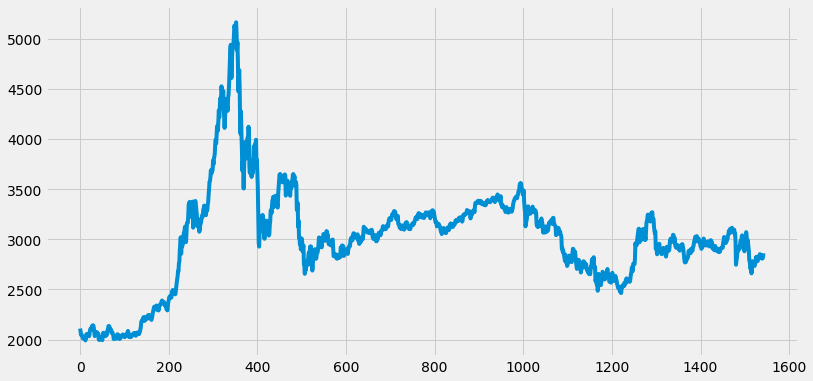

In [41]:
#展示一下看看
plt.figure(figsize=(12,6))
plt.plot(data['close'])

In [42]:
#区分特征和标签
y=data['close']
del data['close']
x=data
y=np.reshape(y.values, (-1,1))  

In [43]:
#归一化
from sklearn.preprocessing import MinMaxScaler
mm_x= MinMaxScaler()
mm_y= MinMaxScaler()
x= mm_x.fit_transform(x)
y= mm_y.fit_transform(y)

In [44]:
#构建lstm输入
df=pd.concat([pd.DataFrame(x),pd.DataFrame(y)],axis=1)
stock=df
seq_len=windows
amount_of_features = len(stock.columns)#有几列
data = stock.as_matrix() #pd.DataFrame(stock) 表格转化为矩阵
sequence_length = seq_len + 1#序列长度
result = []
for index in range(len(data) - sequence_length):#循环数据长度-sequence_length次
    result.append(data[index: index + sequence_length])#第i行到i+sequence_length
result = np.array(result)#得到样本，样本形式为6天*3特征
train = result[:-cut, :]
x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
x_test = result[-cut:, :-1]
y_test = result[-cut:, -1][:,-1]
#reshape成 6天*3特征
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1439, 3, 8) (1439,) (100, 3, 8) (100,)


E:\anoconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [45]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def up_down_accuracy(y_true, y_pred):
    y_var_test=y_true[1:]-y_true[:len(y_true)-1]#实际涨跌
    y_var_predict=y_pred[1:]-y_pred[:len(y_pred)-1]#原始涨跌
    txt=np.zeros(len(y_var_test))
    for i in range(len(y_var_test-1)):#计算数量
        txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
    result=sum(txt)/len(txt)
    return result

In [46]:
#三维网格搜索
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
def model_result(lstm_size,batch_size,epoch,y_test):
    #建立训练模型过程
    model = Sequential()#建立层次模型
    model.add(LSTM(lstm_size, input_shape=(windows, amount_of_features), return_sequences=False))#建立LSTM层
    model.add(Dense(lstm_size,init='uniform',activation='relu'))   #建立全连接层     
    model.add(Dense(1,init='uniform',activation='relu'))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    #神经网络训练及结果
    history= model.fit(X_train, y_train, nb_epoch =epoch,
                       batch_size =batch_size,validation_split=validation_split) #训练模型nb_epoch次
    #在测试集上的预测
    y_test_predict=model.predict(X_test)
    # 反归一化
    y_test_predict=np.reshape(y_test_predict, (-1,1))  
    y_test_predict= mm_y.inverse_transform(y_test_predict)
    y_test=np.reshape(y_test, (-1,1))  
    y_test=mm_y.inverse_transform(y_test)
    y_test_predict=y_test_predict[:,0]
    #输出结果
    y_test=y_test.reshape(-1)
    y_testpredict=y_test_predict.reshape(-1)
    a,b,c,d=mean_absolute_error(y_test_predict, y_test), np.sqrt(mean_squared_error(y_test_predict, y_test) ),mape(y_test_predict,  y_test), up_down_accuracy(y_test_predict,y_test)
    return  a,b,c,d
lstm_size=[8,16,32,64,128]
batch_size = [8,16,32,64,128]
epochs = [10,50,100,200,500]
record=[]
for i in lstm_size:
    for j in batch_size:
        for k in epochs:
            a,b,c,d=model_result(i,j,k,y_test)
            record.append([i,j,k,a,b,c,d])

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 6s 4ms/step - loss: 0.0539 - accuracy: 7.7220e-04 - val_loss: 0.0056 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 1s 644us/step - loss: 0.0170 - accuracy: 7.7220e-04 - val_loss: 0.0106 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 1s 648us/step - loss: 0.0043 - accuracy: 0.0015 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 1s 661us/step - loss: 0.0013 - accuracy: 0.0015 - val_loss: 5.1677e-04 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 1s 637us/step - loss: 7.2020e-04 - accuracy: 0.0015 - val_loss: 3.1295e-04 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 1s 656us/step - loss: 6.7311e-04 - accuracy: 0.0015 - val_loss: 3.2787e-04 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [=====

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 6s 5ms/step - loss: 0.0572 - accuracy: 7.7220e-04 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 1s 684us/step - loss: 0.0161 - accuracy: 7.7220e-04 - val_loss: 0.0103 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 1s 778us/step - loss: 0.0037 - accuracy: 0.0015 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 1s 650us/step - loss: 0.0013 - accuracy: 0.0015 - val_loss: 2.9522e-04 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 1s 680us/step - loss: 9.6834e-04 - accuracy: 0.0015 - val_loss: 3.8489e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 1s 646us/step - loss: 7.6319e-04 - accuracy: 0.0015 - val_loss: 2.3790e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [=====

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 6s 5ms/step - loss: 0.0600 - accuracy: 7.7220e-04 - val_loss: 0.0049 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 1s 803us/step - loss: 0.0203 - accuracy: 7.7220e-04 - val_loss: 0.0046 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 1s 824us/step - loss: 0.0056 - accuracy: 0.0015 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 1s 790us/step - loss: 0.0020 - accuracy: 0.0015 - val_loss: 5.0275e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 1s 823us/step - loss: 0.0010 - accuracy: 0.0015 - val_loss: 4.7316e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 1s 779us/step - loss: 7.6763e-04 - accuracy: 0.0015 - val_loss: 3.1012e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1295 [==

Epoch 52/100
1295/1295 [==============================] - 1s 791us/step - loss: 3.2561e-04 - accuracy: 0.0015 - val_loss: 1.5234e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 1s 816us/step - loss: 3.0731e-04 - accuracy: 0.0015 - val_loss: 1.7436e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 1s 813us/step - loss: 3.5438e-04 - accuracy: 0.0015 - val_loss: 2.8566e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 1s 794us/step - loss: 3.1633e-04 - accuracy: 0.0015 - val_loss: 1.7129e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 1s 830us/step - loss: 3.2129e-04 - accuracy: 0.0015 - val_loss: 1.4726e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 1s 772us/step - loss: 3.2696e-04 - accuracy: 0.0015 - val_loss: 2.1640e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 8s 6ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 1s 828us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 1s 796us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 1s 822us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 1s 789us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 1s 819us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [==

1295/1295 [==============================] - 1s 798us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 1s 782us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 1s 821us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 1s 804us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 1s 806us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [==============================] - 1s 801us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 59/200
1295/1295 [==============================] - 1s 802us/step - los

1295/1295 [==============================] - 1s 819us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 1s 822us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 1s 796us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 1s 812us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [==============================] - 1s 800us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 110/200
1295/1295 [==============================] - 1s 816us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 111/200
1295/1295 [==============================] - 1s 805us/step

1295/1295 [==============================] - 1s 798us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 1s 796us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 1s 818us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [==============================] - 1s 813us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 161/200
1295/1295 [==============================] - 1s 845us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 162/200
1295/1295 [==============================] - 1s 793us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 163/200
1295/1295 [==============================] - 1s 803us/step

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 9s 7ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 1s 829us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 1s 839us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 1s 819us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 1s 822us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 1s 824us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [==

1295/1295 [==============================] - 1s 850us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 1s 809us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 1s 837us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 1s 840us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 1s 813us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [==============================] - 1s 828us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 59/500
1295/1295 [==============================] - 1s 806us/step - los

1295/1295 [==============================] - 1s 836us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 1s 806us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 1s 819us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 1s 824us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [==============================] - 1s 815us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 110/500
1295/1295 [==============================] - 1s 841us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 111/500
1295/1295 [==============================] - 1s 819us/step

1295/1295 [==============================] - 1s 832us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 1s 826us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [==============================] - 1s 811us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 160/500
1295/1295 [==============================] - 1s 825us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 161/500
1295/1295 [==============================] - 1s 805us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 162/500
1295/1295 [==============================] - 1s 824us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 163/500
1295/1295 [==============================] - 1s 817us/step

1295/1295 [==============================] - 1s 817us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 210/500
1295/1295 [==============================] - 1s 822us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 211/500
1295/1295 [==============================] - 1s 811us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 212/500
1295/1295 [==============================] - 1s 819us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 213/500
1295/1295 [==============================] - 1s 830us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 214/500
1295/1295 [==============================] - 1s 806us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 215/500
1295/1295 [==============================] - 1s 839us/step

Epoch 261/500
1295/1295 [==============================] - 1s 795us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 262/500
1295/1295 [==============================] - 1s 809us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 263/500
1295/1295 [==============================] - 1s 823us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 264/500
1295/1295 [==============================] - 1s 830us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 265/500
1295/1295 [==============================] - 1s 819us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 266/500
1295/1295 [==============================] - 1s 819us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 267/500
1295/1295 [==============================] -

1295/1295 [==============================] - 1s 847us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 314/500
1295/1295 [==============================] - 1s 829us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 315/500
1295/1295 [==============================] - 1s 838us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 316/500
1295/1295 [==============================] - 1s 803us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 317/500
1295/1295 [==============================] - 1s 816us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 318/500
1295/1295 [==============================] - 1s 853us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 319/500
1295/1295 [==============================] - 1s 826us/step

Epoch 365/500
1295/1295 [==============================] - 1s 810us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 366/500
1295/1295 [==============================] - 1s 842us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 367/500
1295/1295 [==============================] - 1s 826us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 368/500
1295/1295 [==============================] - 1s 828us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 369/500
1295/1295 [==============================] - 1s 828us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 370/500
1295/1295 [==============================] - 1s 839us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 371/500
1295/1295 [==============================] -

1295/1295 [==============================] - 1s 836us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 417/500
1295/1295 [==============================] - 1s 820us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 418/500
1295/1295 [==============================] - 1s 838us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 419/500
1295/1295 [==============================] - 1s 808us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 420/500
1295/1295 [==============================] - 1s 844us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 421/500
1295/1295 [==============================] - 1s 811us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 422/500
1295/1295 [==============================] - 1s 838us/step

1295/1295 [==============================] - 1s 657us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 469/500
1295/1295 [==============================] - 1s 685us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 470/500
1295/1295 [==============================] - 1s 658us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 471/500
1295/1295 [==============================] - 1s 658us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 472/500
1295/1295 [==============================] - 1s 663us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 473/500
1295/1295 [==============================] - 1s 672us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 474/500
1295/1295 [==============================] - 1s 671us/step

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 6s 5ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 0s 359us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 0s 341us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 0s 360us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 1s 447us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 1s 463us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 6s 5ms/step - loss: 0.0944 - accuracy: 7.7220e-04 - val_loss: 0.0038 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 0s 348us/step - loss: 0.0270 - accuracy: 7.7220e-04 - val_loss: 0.0037 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 0s 339us/step - loss: 0.0208 - accuracy: 7.7220e-04 - val_loss: 0.0074 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 0s 350us/step - loss: 0.0128 - accuracy: 7.7220e-04 - val_loss: 0.0068 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 0s 359us/step - loss: 0.0049 - accuracy: 0.0015 - val_loss: 0.0051 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 0s 359us/step - loss: 0.0019 - accuracy: 0.0015 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [=================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 7s 5ms/step - loss: 0.0852 - accuracy: 7.7220e-04 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 0s 345us/step - loss: 0.0242 - accuracy: 7.7220e-04 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 0s 352us/step - loss: 0.0137 - accuracy: 0.0015 - val_loss: 0.0034 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 0s 351us/step - loss: 0.0029 - accuracy: 0.0015 - val_loss: 3.6648e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 0s 338us/step - loss: 0.0011 - accuracy: 0.0015 - val_loss: 2.6403e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 0s 344us/step - loss: 8.9993e-04 - accuracy: 0.0015 - val_loss: 2.7458e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1295 [==

1295/1295 [==============================] - 0s 349us/step - loss: 3.9181e-04 - accuracy: 0.0015 - val_loss: 1.6661e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 0s 332us/step - loss: 3.8086e-04 - accuracy: 0.0015 - val_loss: 1.6318e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 0s 337us/step - loss: 3.5917e-04 - accuracy: 0.0015 - val_loss: 1.3393e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 0s 357us/step - loss: 3.6839e-04 - accuracy: 0.0015 - val_loss: 1.3872e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 0s 361us/step - loss: 3.6065e-04 - accuracy: 0.0015 - val_loss: 1.5299e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 0s 347us/step - loss: 3.5386e-04 - accuracy: 0.0015 - val_loss: 1.5174e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [=============================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 9s 7ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 1s 440us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 1s 444us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 1s 423us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 1s 443us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 1s 420us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [==

Epoch 53/200
1295/1295 [==============================] - 1s 427us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 1s 434us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 1s 441us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 1s 430us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 1s 417us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [==============================] - 1s 451us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 59/200
1295/1295 [==============================] - 1s 432

1295/1295 [==============================] - 0s 352us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 0s 360us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 0s 355us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 0s 360us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [==============================] - 0s 357us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 110/200
1295/1295 [==============================] - 0s 357us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 111/200
1295/1295 [==============================] - 0s 346us/step

1295/1295 [==============================] - 0s 343us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 0s 367us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 1s 410us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [==============================] - 1s 420us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 161/200
1295/1295 [==============================] - 1s 420us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 162/200
1295/1295 [==============================] - 1s 431us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 163/200
1295/1295 [==============================] - 1s 446us/step

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 9s 7ms/step - loss: 0.0804 - accuracy: 7.7220e-04 - val_loss: 0.0048 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 1s 421us/step - loss: 0.0232 - accuracy: 7.7220e-04 - val_loss: 0.0054 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 1s 439us/step - loss: 0.0119 - accuracy: 0.0015 - val_loss: 0.0134 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 1s 444us/step - loss: 0.0041 - accuracy: 0.0015 - val_loss: 0.0115 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 1s 409us/step - loss: 0.0023 - accuracy: 0.0015 - val_loss: 0.0036 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 1s 439us/step - loss: 0.0014 - accuracy: 0.0015 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [==================

Epoch 52/500
1295/1295 [==============================] - 1s 436us/step - loss: 3.6311e-04 - accuracy: 0.0015 - val_loss: 1.1486e-04 - val_accuracy: 0.0000e+00
Epoch 53/500
1295/1295 [==============================] - 1s 436us/step - loss: 3.8036e-04 - accuracy: 0.0015 - val_loss: 1.6983e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 1s 434us/step - loss: 3.5338e-04 - accuracy: 0.0015 - val_loss: 1.1722e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 1s 434us/step - loss: 3.6179e-04 - accuracy: 0.0015 - val_loss: 1.2000e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 1s 438us/step - loss: 3.4916e-04 - accuracy: 0.0015 - val_loss: 2.2702e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 1s 431us/step - loss: 3.5933e-04 - accuracy: 0.0015 - val_loss: 1.3981e-04 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [================

Epoch 103/500
1295/1295 [==============================] - 1s 436us/step - loss: 3.0703e-04 - accuracy: 0.0015 - val_loss: 1.4378e-04 - val_accuracy: 0.0000e+00
Epoch 104/500
1295/1295 [==============================] - 1s 419us/step - loss: 2.8756e-04 - accuracy: 0.0015 - val_loss: 1.3965e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 1s 432us/step - loss: 2.9824e-04 - accuracy: 0.0015 - val_loss: 2.5426e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 1s 441us/step - loss: 2.9774e-04 - accuracy: 0.0015 - val_loss: 9.5066e-05 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 1s 431us/step - loss: 2.7605e-04 - accuracy: 0.0015 - val_loss: 1.9328e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 1s 435us/step - loss: 3.2013e-04 - accuracy: 0.0015 - val_loss: 1.2137e-04 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [=========

Epoch 154/500
1295/1295 [==============================] - 1s 437us/step - loss: 2.6098e-04 - accuracy: 0.0015 - val_loss: 9.5844e-05 - val_accuracy: 0.0000e+00
Epoch 155/500
1295/1295 [==============================] - 1s 440us/step - loss: 2.7314e-04 - accuracy: 0.0015 - val_loss: 1.6745e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 1s 428us/step - loss: 2.7107e-04 - accuracy: 0.0015 - val_loss: 1.0538e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 1s 438us/step - loss: 2.9119e-04 - accuracy: 0.0015 - val_loss: 1.5675e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 1s 439us/step - loss: 2.7372e-04 - accuracy: 0.0015 - val_loss: 9.8456e-05 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [==============================] - 1s 425us/step - loss: 2.7429e-04 - accuracy: 0.0015 - val_loss: 1.2868e-04 - val_accuracy: 0.0000e+00
Epoch 160/500
1295/1295 [=========

1295/1295 [==============================] - 1s 437us/step - loss: 2.5022e-04 - accuracy: 0.0015 - val_loss: 1.1301e-04 - val_accuracy: 0.0000e+00
Epoch 205/500
1295/1295 [==============================] - 1s 417us/step - loss: 2.7772e-04 - accuracy: 0.0015 - val_loss: 1.0119e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
1295/1295 [==============================] - 1s 440us/step - loss: 2.5837e-04 - accuracy: 0.0015 - val_loss: 9.7000e-05 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 1s 447us/step - loss: 2.5725e-04 - accuracy: 0.0015 - val_loss: 1.0817e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 1s 514us/step - loss: 2.6857e-04 - accuracy: 0.0015 - val_loss: 1.0656e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [==============================] - 1s 447us/step - loss: 2.5725e-04 - accuracy: 0.0015 - val_loss: 9.8746e-05 - val_accuracy: 0.0000e+00
Epoch 210/500
1295/1295 [=======================

Epoch 255/500
1295/1295 [==============================] - 1s 434us/step - loss: 2.5446e-04 - accuracy: 0.0015 - val_loss: 1.0239e-04 - val_accuracy: 0.0000e+00
Epoch 256/500
1295/1295 [==============================] - 1s 438us/step - loss: 2.7318e-04 - accuracy: 0.0015 - val_loss: 1.6024e-04 - val_accuracy: 0.0000e+00
Epoch 257/500
1295/1295 [==============================] - 1s 436us/step - loss: 2.6298e-04 - accuracy: 0.0015 - val_loss: 1.6472e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 1s 444us/step - loss: 2.5674e-04 - accuracy: 0.0015 - val_loss: 1.0257e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [==============================] - 1s 431us/step - loss: 2.5759e-04 - accuracy: 0.0015 - val_loss: 9.9712e-05 - val_accuracy: 0.0000e+00
Epoch 260/500
1295/1295 [==============================] - 1s 453us/step - loss: 2.4678e-04 - accuracy: 0.0015 - val_loss: 9.9836e-05 - val_accuracy: 0.0000e+00
Epoch 261/500
1295/1295 [=========

Epoch 306/500
1295/1295 [==============================] - 1s 427us/step - loss: 2.7305e-04 - accuracy: 0.0015 - val_loss: 1.0968e-04 - val_accuracy: 0.0000e+00
Epoch 307/500
1295/1295 [==============================] - 1s 444us/step - loss: 2.6531e-04 - accuracy: 0.0015 - val_loss: 1.0986e-04 - val_accuracy: 0.0000e+00
Epoch 308/500
1295/1295 [==============================] - 1s 432us/step - loss: 2.7130e-04 - accuracy: 0.0015 - val_loss: 1.5603e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [==============================] - 1s 434us/step - loss: 2.5966e-04 - accuracy: 0.0015 - val_loss: 1.4737e-04 - val_accuracy: 0.0000e+00
Epoch 310/500
1295/1295 [==============================] - 1s 404us/step - loss: 2.5698e-04 - accuracy: 0.0015 - val_loss: 1.0492e-04 - val_accuracy: 0.0000e+00
Epoch 311/500
1295/1295 [==============================] - 1s 474us/step - loss: 2.6288e-04 - accuracy: 0.0015 - val_loss: 1.0316e-04 - val_accuracy: 0.0000e+00
Epoch 312/500
1295/1295 [=========

1295/1295 [==============================] - 0s 351us/step - loss: 2.5368e-04 - accuracy: 0.0015 - val_loss: 1.2584e-04 - val_accuracy: 0.0000e+00
Epoch 357/500
1295/1295 [==============================] - 0s 343us/step - loss: 2.5455e-04 - accuracy: 0.0015 - val_loss: 1.0230e-04 - val_accuracy: 0.0000e+00
Epoch 358/500
1295/1295 [==============================] - 0s 353us/step - loss: 2.5270e-04 - accuracy: 0.0015 - val_loss: 2.4364e-04 - val_accuracy: 0.0000e+00
Epoch 359/500
1295/1295 [==============================] - 0s 349us/step - loss: 2.4401e-04 - accuracy: 0.0015 - val_loss: 1.3697e-04 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [==============================] - 0s 354us/step - loss: 2.4705e-04 - accuracy: 0.0015 - val_loss: 1.4318e-04 - val_accuracy: 0.0000e+00
Epoch 361/500
1295/1295 [==============================] - 0s 355us/step - loss: 2.4626e-04 - accuracy: 0.0015 - val_loss: 2.2585e-04 - val_accuracy: 0.0000e+00
Epoch 362/500
1295/1295 [=======================

Epoch 407/500
1295/1295 [==============================] - 0s 367us/step - loss: 2.4257e-04 - accuracy: 0.0015 - val_loss: 1.4381e-04 - val_accuracy: 0.0000e+00
Epoch 408/500
1295/1295 [==============================] - 0s 353us/step - loss: 2.6962e-04 - accuracy: 0.0015 - val_loss: 2.0513e-04 - val_accuracy: 0.0000e+00
Epoch 409/500
1295/1295 [==============================] - 0s 354us/step - loss: 2.4867e-04 - accuracy: 0.0015 - val_loss: 1.1565e-04 - val_accuracy: 0.0000e+00
Epoch 410/500
1295/1295 [==============================] - 0s 350us/step - loss: 2.4085e-04 - accuracy: 0.0015 - val_loss: 1.2170e-04 - val_accuracy: 0.0000e+00
Epoch 411/500
1295/1295 [==============================] - 0s 345us/step - loss: 2.4552e-04 - accuracy: 0.0015 - val_loss: 1.0095e-04 - val_accuracy: 0.0000e+00
Epoch 412/500
1295/1295 [==============================] - 0s 366us/step - loss: 2.4372e-04 - accuracy: 0.0015 - val_loss: 1.0312e-04 - val_accuracy: 0.0000e+00
Epoch 413/500
1295/1295 [=========

Epoch 458/500
1295/1295 [==============================] - 0s 348us/step - loss: 2.5015e-04 - accuracy: 0.0015 - val_loss: 1.0612e-04 - val_accuracy: 0.0000e+00
Epoch 459/500
1295/1295 [==============================] - 0s 352us/step - loss: 2.4020e-04 - accuracy: 0.0015 - val_loss: 1.0414e-04 - val_accuracy: 0.0000e+00
Epoch 460/500
1295/1295 [==============================] - ETA: 0s - loss: 2.4857e-04 - accuracy: 0.00 - 0s 351us/step - loss: 2.5104e-04 - accuracy: 0.0015 - val_loss: 1.1230e-04 - val_accuracy: 0.0000e+00
Epoch 461/500
1295/1295 [==============================] - 0s 347us/step - loss: 2.4957e-04 - accuracy: 0.0015 - val_loss: 1.2829e-04 - val_accuracy: 0.0000e+00
Epoch 462/500
1295/1295 [==============================] - 0s 341us/step - loss: 2.4128e-04 - accuracy: 0.0015 - val_loss: 1.3391e-04 - val_accuracy: 0.0000e+00
Epoch 463/500
1295/1295 [==============================] - 0s 368us/step - loss: 2.3246e-04 - accuracy: 0.0015 - val_loss: 1.0753e-04 - val_accuracy:

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 6s 5ms/step - loss: 0.1174 - accuracy: 7.7220e-04 - val_loss: 0.0455 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 0s 180us/step - loss: 0.0524 - accuracy: 7.7220e-04 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 0s 168us/step - loss: 0.0259 - accuracy: 7.7220e-04 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 0s 186us/step - loss: 0.0213 - accuracy: 7.7220e-04 - val_loss: 0.0055 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 0s 188us/step - loss: 0.0157 - accuracy: 7.7220e-04 - val_loss: 0.0102 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 0s 183us/step - loss: 0.0090 - accuracy: 0.0015 - val_loss: 0.0119 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [=============

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 8s 6ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 0s 178us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 0s 173us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 0s 193us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 0s 199us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 0s 194us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 9s 7ms/step - loss: 0.1203 - accuracy: 7.7220e-04 - val_loss: 0.0514 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 0s 220us/step - loss: 0.0695 - accuracy: 7.7220e-04 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 0s 240us/step - loss: 0.0287 - accuracy: 7.7220e-04 - val_loss: 0.0045 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 0s 230us/step - loss: 0.0254 - accuracy: 7.7220e-04 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 0s 235us/step - loss: 0.0220 - accuracy: 7.7220e-04 - val_loss: 0.0047 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 0s 233us/step - loss: 0.0173 - accuracy: 7.7220e-04 - val_loss: 0.0102 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1295 [==

Epoch 52/100
1295/1295 [==============================] - 0s 231us/step - loss: 4.2569e-04 - accuracy: 0.0015 - val_loss: 1.2845e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 0s 235us/step - loss: 4.1904e-04 - accuracy: 0.0015 - val_loss: 1.5860e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 0s 213us/step - loss: 4.0322e-04 - accuracy: 0.0015 - val_loss: 2.5867e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 0s 230us/step - loss: 4.0788e-04 - accuracy: 0.0015 - val_loss: 1.5741e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 0s 228us/step - loss: 4.0101e-04 - accuracy: 0.0015 - val_loss: 1.4375e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 0s 236us/step - loss: 3.8525e-04 - accuracy: 0.0015 - val_loss: 1.2057e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 6s 5ms/step - loss: 0.1181 - accuracy: 7.7220e-04 - val_loss: 0.0470 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 0s 198us/step - loss: 0.0590 - accuracy: 7.7220e-04 - val_loss: 3.6076e-04 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 0s 197us/step - loss: 0.0279 - accuracy: 7.7220e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 0s 208us/step - loss: 0.0247 - accuracy: 7.7220e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 0s 185us/step - loss: 0.0194 - accuracy: 7.7220e-04 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 0s 186us/step - loss: 0.0102 - accuracy: 0.0015 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [==

1295/1295 [==============================] - 0s 245us/step - loss: 4.0416e-04 - accuracy: 0.0015 - val_loss: 1.3037e-04 - val_accuracy: 0.0000e+00
Epoch 53/200
1295/1295 [==============================] - 0s 241us/step - loss: 4.1729e-04 - accuracy: 0.0015 - val_loss: 1.2522e-04 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 0s 241us/step - loss: 4.0822e-04 - accuracy: 0.0015 - val_loss: 1.1819e-04 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 0s 227us/step - loss: 4.3024e-04 - accuracy: 0.0015 - val_loss: 1.1599e-04 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 0s 236us/step - loss: 4.2491e-04 - accuracy: 0.0015 - val_loss: 1.5045e-04 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 0s 230us/step - loss: 4.0983e-04 - accuracy: 0.0015 - val_loss: 1.2011e-04 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [=============================

Epoch 103/200
1295/1295 [==============================] - 0s 235us/step - loss: 3.2939e-04 - accuracy: 0.0015 - val_loss: 1.6424e-04 - val_accuracy: 0.0000e+00
Epoch 104/200
1295/1295 [==============================] - 0s 229us/step - loss: 3.3457e-04 - accuracy: 0.0015 - val_loss: 1.1543e-04 - val_accuracy: 0.0000e+00
Epoch 105/200
1295/1295 [==============================] - 0s 234us/step - loss: 3.2630e-04 - accuracy: 0.0015 - val_loss: 1.1583e-04 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 0s 235us/step - loss: 3.1597e-04 - accuracy: 0.0015 - val_loss: 1.1840e-04 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 0s 250us/step - loss: 3.2370e-04 - accuracy: 0.0015 - val_loss: 1.3736e-04 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 0s 223us/step - loss: 3.1701e-04 - accuracy: 0.0015 - val_loss: 1.0894e-04 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [=========

1295/1295 [==============================] - 0s 227us/step - loss: 3.0427e-04 - accuracy: 0.0015 - val_loss: 1.7276e-04 - val_accuracy: 0.0000e+00
Epoch 154/200
1295/1295 [==============================] - 0s 244us/step - loss: 3.2432e-04 - accuracy: 0.0015 - val_loss: 2.5561e-04 - val_accuracy: 0.0000e+00
Epoch 155/200
1295/1295 [==============================] - 0s 232us/step - loss: 2.9878e-04 - accuracy: 0.0015 - val_loss: 1.1250e-04 - val_accuracy: 0.0000e+00
Epoch 156/200
1295/1295 [==============================] - 0s 232us/step - loss: 2.9327e-04 - accuracy: 0.0015 - val_loss: 1.0834e-04 - val_accuracy: 0.0000e+00
Epoch 157/200
1295/1295 [==============================] - 0s 240us/step - loss: 3.3169e-04 - accuracy: 0.0015 - val_loss: 1.3842e-04 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 0s 236us/step - loss: 2.9037e-04 - accuracy: 0.0015 - val_loss: 1.0348e-04 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [=======================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 9s 7ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 0s 239us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 0s 236us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 0s 226us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 0s 224us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 0s 239us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [==

1295/1295 [==============================] - 0s 233us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 0s 243us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 0s 231us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 0s 226us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 0s 228us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [==============================] - 0s 239us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 59/500
1295/1295 [==============================] - 0s 231us/step - los

1295/1295 [==============================] - 0s 247us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 0s 246us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 0s 251us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 0s 236us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [==============================] - 0s 243us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 110/500
1295/1295 [==============================] - 0s 257us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 111/500
1295/1295 [==============================] - 0s 255us/step

1295/1295 [==============================] - 0s 204us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 0s 196us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [==============================] - 0s 199us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 160/500
1295/1295 [==============================] - 0s 189us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 161/500
1295/1295 [==============================] - 0s 190us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 162/500
1295/1295 [==============================] - 0s 186us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 163/500
1295/1295 [==============================] - 0s 199us/step

1295/1295 [==============================] - 0s 201us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 210/500
1295/1295 [==============================] - 0s 195us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 211/500
1295/1295 [==============================] - 0s 194us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 212/500
1295/1295 [==============================] - 0s 201us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 213/500
1295/1295 [==============================] - 0s 203us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 214/500
1295/1295 [==============================] - 0s 207us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 215/500
1295/1295 [==============================] - 0s 203us/step

1295/1295 [==============================] - 0s 206us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 262/500
1295/1295 [==============================] - 0s 206us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 263/500
1295/1295 [==============================] - 0s 195us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 264/500
1295/1295 [==============================] - 0s 195us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 265/500
1295/1295 [==============================] - 0s 193us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 266/500
1295/1295 [==============================] - 0s 202us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 267/500
1295/1295 [==============================] - 0s 192us/step

1295/1295 [==============================] - 0s 206us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 314/500
1295/1295 [==============================] - 0s 205us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 315/500
1295/1295 [==============================] - 0s 201us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 316/500
1295/1295 [==============================] - 0s 189us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 317/500
1295/1295 [==============================] - 0s 196us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 318/500
1295/1295 [==============================] - 0s 202us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 319/500
1295/1295 [==============================] - 0s 197us/step

1295/1295 [==============================] - 0s 204us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 366/500
1295/1295 [==============================] - 0s 203us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 367/500
1295/1295 [==============================] - 0s 213us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 368/500
1295/1295 [==============================] - 0s 208us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 369/500
1295/1295 [==============================] - 0s 213us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 370/500
1295/1295 [==============================] - 0s 202us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 371/500
1295/1295 [==============================] - 0s 199us/step

1295/1295 [==============================] - 0s 196us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 418/500
1295/1295 [==============================] - 0s 204us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 419/500
1295/1295 [==============================] - 0s 206us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 420/500
1295/1295 [==============================] - 0s 202us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 421/500
1295/1295 [==============================] - 0s 186us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 422/500
1295/1295 [==============================] - 0s 203us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 423/500
1295/1295 [==============================] - 0s 196us/step

1295/1295 [==============================] - 0s 248us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 470/500
1295/1295 [==============================] - 0s 245us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 471/500
1295/1295 [==============================] - 0s 256us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 472/500
1295/1295 [==============================] - 0s 251us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 473/500
1295/1295 [==============================] - 0s 253us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 474/500
1295/1295 [==============================] - 0s 246us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 475/500
1295/1295 [==============================] - 0s 245us/step

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 9s 7ms/step - loss: 0.1294 - accuracy: 7.7220e-04 - val_loss: 0.0703 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 0s 129us/step - loss: 0.1061 - accuracy: 7.7220e-04 - val_loss: 0.0438 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 0s 138us/step - loss: 0.0689 - accuracy: 7.7220e-04 - val_loss: 0.0094 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 0s 129us/step - loss: 0.0323 - accuracy: 7.7220e-04 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 0s 126us/step - loss: 0.0255 - accuracy: 7.7220e-04 - val_loss: 0.0036 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 0s 123us/step - loss: 0.0236 - accuracy: 7.7220e-04 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 7s 6ms/step - loss: 0.1298 - accuracy: 7.7220e-04 - val_loss: 0.0718 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 0s 142us/step - loss: 0.1081 - accuracy: 7.7220e-04 - val_loss: 0.0486 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 0s 142us/step - loss: 0.0732 - accuracy: 7.7220e-04 - val_loss: 0.0140 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 0s 133us/step - loss: 0.0343 - accuracy: 7.7220e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 0s 133us/step - loss: 0.0244 - accuracy: 7.7220e-04 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 0s 126us/step - loss: 0.0210 - accuracy: 7.7220e-04 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 7s 5ms/step - loss: 0.1286 - accuracy: 7.7220e-04 - val_loss: 0.0701 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 0s 109us/step - loss: 0.1085 - accuracy: 7.7220e-04 - val_loss: 0.0498 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 0s 107us/step - loss: 0.0817 - accuracy: 7.7220e-04 - val_loss: 0.0239 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 0s 106us/step - loss: 0.0502 - accuracy: 7.7220e-04 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 0s 97us/step - loss: 0.0301 - accuracy: 7.7220e-04 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 0s 102us/step - loss: 0.0264 - accuracy: 7.7220e-04 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1295 [===

1295/1295 [==============================] - 0s 109us/step - loss: 5.1258e-04 - accuracy: 0.0015 - val_loss: 1.9313e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 0s 106us/step - loss: 5.1498e-04 - accuracy: 0.0015 - val_loss: 1.8458e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 0s 110us/step - loss: 5.0627e-04 - accuracy: 0.0015 - val_loss: 1.8176e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 0s 106us/step - loss: 5.1819e-04 - accuracy: 0.0015 - val_loss: 1.7769e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 0s 101us/step - loss: 4.9856e-04 - accuracy: 0.0015 - val_loss: 1.8171e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 0s 109us/step - loss: 4.9529e-04 - accuracy: 0.0015 - val_loss: 1.7708e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [=============================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 9s 7ms/step - loss: 0.1300 - accuracy: 7.7220e-04 - val_loss: 0.0719 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 0s 127us/step - loss: 0.1092 - accuracy: 7.7220e-04 - val_loss: 0.0477 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 0s 136us/step - loss: 0.0730 - accuracy: 7.7220e-04 - val_loss: 0.0118 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 0s 138us/step - loss: 0.0314 - accuracy: 7.7220e-04 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 0s 121us/step - loss: 0.0226 - accuracy: 7.7220e-04 - val_loss: 0.0042 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 0s 127us/step - loss: 0.0192 - accuracy: 7.7220e-04 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [==

1295/1295 [==============================] - 0s 136us/step - loss: 4.8923e-04 - accuracy: 0.0015 - val_loss: 2.1157e-04 - val_accuracy: 0.0000e+00
Epoch 53/200
1295/1295 [==============================] - 0s 130us/step - loss: 4.8551e-04 - accuracy: 0.0015 - val_loss: 1.8596e-04 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 0s 136us/step - loss: 4.7486e-04 - accuracy: 0.0015 - val_loss: 1.5391e-04 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 0s 134us/step - loss: 4.7842e-04 - accuracy: 0.0015 - val_loss: 2.6075e-04 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 0s 141us/step - loss: 4.7430e-04 - accuracy: 0.0015 - val_loss: 1.5430e-04 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 0s 137us/step - loss: 4.6792e-04 - accuracy: 0.0015 - val_loss: 1.7967e-04 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [=============================

Epoch 103/200
1295/1295 [==============================] - 0s 122us/step - loss: 3.8548e-04 - accuracy: 0.0015 - val_loss: 2.0007e-04 - val_accuracy: 0.0000e+00
Epoch 104/200
1295/1295 [==============================] - 0s 128us/step - loss: 3.8490e-04 - accuracy: 0.0015 - val_loss: 1.6502e-04 - val_accuracy: 0.0000e+00
Epoch 105/200
1295/1295 [==============================] - 0s 142us/step - loss: 3.8220e-04 - accuracy: 0.0015 - val_loss: 2.0024e-04 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 0s 142us/step - loss: 3.8530e-04 - accuracy: 0.0015 - val_loss: 1.7061e-04 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 0s 143us/step - loss: 3.7623e-04 - accuracy: 0.0015 - val_loss: 1.5974e-04 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 0s 135us/step - loss: 3.8731e-04 - accuracy: 0.0015 - val_loss: 2.1003e-04 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [=========

Epoch 154/200
1295/1295 [==============================] - 0s 143us/step - loss: 3.4222e-04 - accuracy: 0.0015 - val_loss: 1.6898e-04 - val_accuracy: 0.0000e+00
Epoch 155/200
1295/1295 [==============================] - 0s 139us/step - loss: 3.4684e-04 - accuracy: 0.0015 - val_loss: 2.9250e-04 - val_accuracy: 0.0000e+00
Epoch 156/200
1295/1295 [==============================] - 0s 146us/step - loss: 4.0931e-04 - accuracy: 0.0015 - val_loss: 1.4581e-04 - val_accuracy: 0.0000e+00
Epoch 157/200
1295/1295 [==============================] - 0s 151us/step - loss: 3.4430e-04 - accuracy: 0.0015 - val_loss: 2.3004e-04 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 0s 142us/step - loss: 3.5126e-04 - accuracy: 0.0015 - val_loss: 1.9951e-04 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 0s 145us/step - loss: 3.4501e-04 - accuracy: 0.0015 - val_loss: 2.0357e-04 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 7s 5ms/step - loss: 0.1303 - accuracy: 7.7220e-04 - val_loss: 0.0724 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 0s 109us/step - loss: 0.1117 - accuracy: 7.7220e-04 - val_loss: 0.0532 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 0s 108us/step - loss: 0.0858 - accuracy: 7.7220e-04 - val_loss: 0.0262 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 0s 109us/step - loss: 0.0509 - accuracy: 7.7220e-04 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 0s 116us/step - loss: 0.0267 - accuracy: 7.7220e-04 - val_loss: 0.0057 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 0s 107us/step - loss: 0.0239 - accuracy: 7.7220e-04 - val_loss: 0.0041 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [==

Epoch 53/500
1295/1295 [==============================] - 0s 110us/step - loss: 5.7322e-04 - accuracy: 0.0015 - val_loss: 2.3644e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 0s 110us/step - loss: 5.6814e-04 - accuracy: 0.0015 - val_loss: 2.1566e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 0s 108us/step - loss: 5.5499e-04 - accuracy: 0.0015 - val_loss: 3.2370e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 0s 108us/step - loss: 5.6789e-04 - accuracy: 0.0015 - val_loss: 2.2422e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 0s 109us/step - loss: 5.4641e-04 - accuracy: 0.0015 - val_loss: 4.0926e-04 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [==============================] - 0s 105us/step - loss: 5.5145e-04 - accuracy: 0.0015 - val_loss: 2.0035e-04 - val_accuracy: 0.0000e+00
Epoch 59/500
1295/1295 [================

1295/1295 [==============================] - 0s 115us/step - loss: 4.3081e-04 - accuracy: 0.0015 - val_loss: 1.9351e-04 - val_accuracy: 0.0000e+00
Epoch 104/500
1295/1295 [==============================] - 0s 115us/step - loss: 4.2392e-04 - accuracy: 0.0015 - val_loss: 3.0868e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 0s 116us/step - loss: 4.3424e-04 - accuracy: 0.0015 - val_loss: 1.8167e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 0s 108us/step - loss: 4.2393e-04 - accuracy: 0.0015 - val_loss: 1.9170e-04 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 0s 108us/step - loss: 4.2524e-04 - accuracy: 0.0015 - val_loss: 1.8503e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 0s 110us/step - loss: 4.2800e-04 - accuracy: 0.0015 - val_loss: 1.9947e-04 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [=======================

Epoch 154/500
1295/1295 [==============================] - 0s 99us/step - loss: 3.7789e-04 - accuracy: 0.0015 - val_loss: 1.5082e-04 - val_accuracy: 0.0000e+00
Epoch 155/500
1295/1295 [==============================] - 0s 99us/step - loss: 3.6329e-04 - accuracy: 0.0015 - val_loss: 1.3430e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 0s 106us/step - loss: 3.7417e-04 - accuracy: 0.0015 - val_loss: 1.5649e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 0s 111us/step - loss: 3.6118e-04 - accuracy: 0.0015 - val_loss: 1.7224e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 0s 109us/step - loss: 3.6617e-04 - accuracy: 0.0015 - val_loss: 2.6454e-04 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [==============================] - 0s 112us/step - loss: 3.6583e-04 - accuracy: 0.0015 - val_loss: 1.4922e-04 - val_accuracy: 0.0000e+00
Epoch 160/500
1295/1295 [===========

1295/1295 [==============================] - 0s 103us/step - loss: 3.1505e-04 - accuracy: 0.0015 - val_loss: 1.8163e-04 - val_accuracy: 0.0000e+00
Epoch 205/500
1295/1295 [==============================] - 0s 107us/step - loss: 3.3621e-04 - accuracy: 0.0015 - val_loss: 1.7856e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
1295/1295 [==============================] - 0s 109us/step - loss: 3.2777e-04 - accuracy: 0.0015 - val_loss: 1.3608e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 0s 104us/step - loss: 3.1817e-04 - accuracy: 0.0015 - val_loss: 1.2630e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 0s 102us/step - loss: 3.3678e-04 - accuracy: 0.0015 - val_loss: 1.3903e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [==============================] - 0s 99us/step - loss: 3.2320e-04 - accuracy: 0.0015 - val_loss: 1.4590e-04 - val_accuracy: 0.0000e+00
Epoch 210/500
1295/1295 [========================

1295/1295 [==============================] - 0s 129us/step - loss: 2.9030e-04 - accuracy: 0.0015 - val_loss: 1.1285e-04 - val_accuracy: 0.0000e+00
Epoch 255/500
1295/1295 [==============================] - 0s 126us/step - loss: 3.1869e-04 - accuracy: 0.0015 - val_loss: 1.2221e-04 - val_accuracy: 0.0000e+00
Epoch 256/500
1295/1295 [==============================] - 0s 109us/step - loss: 3.0447e-04 - accuracy: 0.0015 - val_loss: 1.0335e-04 - val_accuracy: 0.0000e+00
Epoch 257/500
1295/1295 [==============================] - 0s 102us/step - loss: 2.9743e-04 - accuracy: 0.0015 - val_loss: 1.4445e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 0s 109us/step - loss: 2.9804e-04 - accuracy: 0.0015 - val_loss: 1.2579e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [==============================] - 0s 97us/step - loss: 2.8261e-04 - accuracy: 0.0015 - val_loss: 1.0976e-04 - val_accuracy: 0.0000e+00
Epoch 260/500
1295/1295 [========================

1295/1295 [==============================] - 0s 131us/step - loss: 2.7781e-04 - accuracy: 0.0015 - val_loss: 1.0913e-04 - val_accuracy: 0.0000e+00
Epoch 306/500
1295/1295 [==============================] - 0s 133us/step - loss: 2.7352e-04 - accuracy: 0.0015 - val_loss: 2.3698e-04 - val_accuracy: 0.0000e+00
Epoch 307/500
1295/1295 [==============================] - 0s 136us/step - loss: 3.1928e-04 - accuracy: 0.0015 - val_loss: 1.2163e-04 - val_accuracy: 0.0000e+00
Epoch 308/500
1295/1295 [==============================] - 0s 145us/step - loss: 2.6890e-04 - accuracy: 0.0015 - val_loss: 1.0199e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [==============================] - 0s 120us/step - loss: 2.7976e-04 - accuracy: 0.0015 - val_loss: 1.0424e-04 - val_accuracy: 0.0000e+00
Epoch 310/500
1295/1295 [==============================] - 0s 132us/step - loss: 2.7118e-04 - accuracy: 0.0015 - val_loss: 1.3188e-04 - val_accuracy: 0.0000e+00
Epoch 311/500
1295/1295 [=======================

Epoch 356/500
1295/1295 [==============================] - 0s 112us/step - loss: 2.6324e-04 - accuracy: 0.0015 - val_loss: 1.0080e-04 - val_accuracy: 0.0000e+00
Epoch 357/500
1295/1295 [==============================] - 0s 112us/step - loss: 2.6349e-04 - accuracy: 0.0015 - val_loss: 1.0316e-04 - val_accuracy: 0.0000e+00
Epoch 358/500
1295/1295 [==============================] - 0s 102us/step - loss: 2.6006e-04 - accuracy: 0.0015 - val_loss: 1.8141e-04 - val_accuracy: 0.0000e+00
Epoch 359/500
1295/1295 [==============================] - 0s 99us/step - loss: 2.6760e-04 - accuracy: 0.0015 - val_loss: 1.6121e-04 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [==============================] - 0s 101us/step - loss: 2.7230e-04 - accuracy: 0.0015 - val_loss: 1.0221e-04 - val_accuracy: 0.0000e+00
Epoch 361/500
1295/1295 [==============================] - 0s 107us/step - loss: 2.6108e-04 - accuracy: 0.0015 - val_loss: 1.0057e-04 - val_accuracy: 0.0000e+00
Epoch 362/500
1295/1295 [==========

Epoch 407/500
1295/1295 [==============================] - 0s 106us/step - loss: 2.9253e-04 - accuracy: 0.0015 - val_loss: 1.0290e-04 - val_accuracy: 0.0000e+00
Epoch 408/500
1295/1295 [==============================] - 0s 106us/step - loss: 2.5556e-04 - accuracy: 0.0015 - val_loss: 1.0637e-04 - val_accuracy: 0.0000e+00
Epoch 409/500
1295/1295 [==============================] - 0s 106us/step - loss: 2.7139e-04 - accuracy: 0.0015 - val_loss: 9.9252e-05 - val_accuracy: 0.0000e+00
Epoch 410/500
1295/1295 [==============================] - 0s 112us/step - loss: 2.6341e-04 - accuracy: 0.0015 - val_loss: 1.0326e-04 - val_accuracy: 0.0000e+00
Epoch 411/500
1295/1295 [==============================] - 0s 109us/step - loss: 2.5456e-04 - accuracy: 0.0015 - val_loss: 9.8760e-05 - val_accuracy: 0.0000e+00
Epoch 412/500
1295/1295 [==============================] - 0s 101us/step - loss: 2.5766e-04 - accuracy: 0.0015 - val_loss: 9.8822e-05 - val_accuracy: 0.0000e+00
Epoch 413/500
1295/1295 [=========

1295/1295 [==============================] - 0s 112us/step - loss: 2.5791e-04 - accuracy: 0.0015 - val_loss: 1.0067e-04 - val_accuracy: 0.0000e+00
Epoch 458/500
1295/1295 [==============================] - 0s 112us/step - loss: 2.5194e-04 - accuracy: 0.0015 - val_loss: 1.0122e-04 - val_accuracy: 0.0000e+00
Epoch 459/500
1295/1295 [==============================] - 0s 102us/step - loss: 2.4642e-04 - accuracy: 0.0015 - val_loss: 1.0730e-04 - val_accuracy: 0.0000e+00
Epoch 460/500
1295/1295 [==============================] - 0s 106us/step - loss: 2.5220e-04 - accuracy: 0.0015 - val_loss: 1.1624e-04 - val_accuracy: 0.0000e+00
Epoch 461/500
1295/1295 [==============================] - 0s 119us/step - loss: 2.4618e-04 - accuracy: 0.0015 - val_loss: 1.2789e-04 - val_accuracy: 0.0000e+00
Epoch 462/500
1295/1295 [==============================] - 0s 115us/step - loss: 2.6897e-04 - accuracy: 0.0015 - val_loss: 1.1621e-04 - val_accuracy: 0.0000e+00
Epoch 463/500
1295/1295 [=======================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 7s 5ms/step - loss: 0.1332 - accuracy: 7.7220e-04 - val_loss: 0.0782 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 0s 65us/step - loss: 0.1238 - accuracy: 7.7220e-04 - val_loss: 0.0688 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 0s 66us/step - loss: 0.1128 - accuracy: 7.7220e-04 - val_loss: 0.0579 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 0s 74us/step - loss: 0.0997 - accuracy: 7.7220e-04 - val_loss: 0.0446 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 0s 72us/step - loss: 0.0832 - accuracy: 7.7220e-04 - val_loss: 0.0292 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 0s 69us/step - loss: 0.0641 - accuracy: 7.7220e-04 - val_loss: 0.0135 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [==============

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 9s 7ms/step - loss: 0.1321 - accuracy: 7.7220e-04 - val_loss: 0.0777 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 0s 69us/step - loss: 0.1224 - accuracy: 7.7220e-04 - val_loss: 0.0686 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 0s 68us/step - loss: 0.1114 - accuracy: 7.7220e-04 - val_loss: 0.0580 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 0s 70us/step - loss: 0.0982 - accuracy: 7.7220e-04 - val_loss: 0.0456 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 0s 70us/step - loss: 0.0827 - accuracy: 7.7220e-04 - val_loss: 0.0315 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 0s 72us/step - loss: 0.0653 - accuracy: 7.7220e-04 - val_loss: 0.0173 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [==============

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 11s 8ms/step - loss: 0.1338 - accuracy: 7.7220e-04 - val_loss: 0.0797 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 0s 86us/step - loss: 0.1255 - accuracy: 7.7220e-04 - val_loss: 0.0718 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 0s 86us/step - loss: 0.1163 - accuracy: 7.7220e-04 - val_loss: 0.0630 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 0s 93us/step - loss: 0.1057 - accuracy: 7.7220e-04 - val_loss: 0.0529 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 0s 93us/step - loss: 0.0931 - accuracy: 7.7220e-04 - val_loss: 0.0412 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 0s 92us/step - loss: 0.0782 - accuracy: 7.7220e-04 - val_loss: 0.0277 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1295 [======

Epoch 53/100
1295/1295 [==============================] - 0s 95us/step - loss: 6.9178e-04 - accuracy: 0.0015 - val_loss: 1.8981e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - ETA: 0s - loss: 6.6611e-04 - accuracy: 0.00 - 0s 87us/step - loss: 6.6315e-04 - accuracy: 0.0015 - val_loss: 2.1984e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 0s 83us/step - loss: 6.5745e-04 - accuracy: 0.0015 - val_loss: 1.8110e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 0s 88us/step - loss: 6.3939e-04 - accuracy: 0.0015 - val_loss: 1.7938e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 0s 84us/step - loss: 6.3562e-04 - accuracy: 0.0015 - val_loss: 2.1627e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [==============================] - 0s 99us/step - loss: 6.3816e-04 - accuracy: 0.0015 - val_loss: 1.7832e-04 - val_accuracy: 0.0000e+00


E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 7s 6ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 0s 75us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 0s 73us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 0s 68us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 0s 73us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 0s 72us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [=======

1295/1295 [==============================] - 0s 78us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 0s 75us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 0s 72us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 0s 72us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 0s 75us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [==============================] - 0s 92us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 59/200
1295/1295 [==============================] - 0s 74us/step - loss: 0.13

Epoch 106/200
1295/1295 [==============================] - 0s 79us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 0s 77us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 0s 79us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [==============================] - 0s 76us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 110/200
1295/1295 [==============================] - 0s 76us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 111/200
1295/1295 [==============================] - 0s 81us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 112/200
1295/1295 [==============================] - 0s 82

1295/1295 [==============================] - 0s 73us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 0s 72us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [==============================] - 0s 75us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 161/200
1295/1295 [==============================] - 0s 74us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 162/200
1295/1295 [==============================] - 0s 74us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 163/200
1295/1295 [==============================] - 0s 72us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 164/200
1295/1295 [==============================] - 0s 75us/step - loss

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 7s 6ms/step - loss: 0.1329 - accuracy: 7.7220e-04 - val_loss: 0.0781 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 0s 69us/step - loss: 0.1231 - accuracy: 7.7220e-04 - val_loss: 0.0684 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 0s 68us/step - loss: 0.1114 - accuracy: 7.7220e-04 - val_loss: 0.0565 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 0s 72us/step - loss: 0.0963 - accuracy: 7.7220e-04 - val_loss: 0.0414 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 0s 73us/step - loss: 0.0775 - accuracy: 7.7220e-04 - val_loss: 0.0237 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 0s 75us/step - loss: 0.0556 - accuracy: 7.7220e-04 - val_loss: 0.0074 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [=======

1295/1295 [==============================] - 0s 83us/step - loss: 5.6286e-04 - accuracy: 0.0015 - val_loss: 1.6586e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 0s 75us/step - loss: 5.5696e-04 - accuracy: 0.0015 - val_loss: 1.5653e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 0s 69us/step - loss: 5.5587e-04 - accuracy: 0.0015 - val_loss: 1.9160e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 0s 70us/step - loss: 5.4766e-04 - accuracy: 0.0015 - val_loss: 2.0691e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 0s 69us/step - loss: 5.6218e-04 - accuracy: 0.0015 - val_loss: 1.5761e-04 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [==============================] - 0s 67us/step - loss: 5.5257e-04 - accuracy: 0.0015 - val_loss: 2.0597e-04 - val_accuracy: 0.0000e+00
Epoch 59/500
1295/1295 [==============================] - 0

1295/1295 [==============================] - 0s 92us/step - loss: 4.5967e-04 - accuracy: 0.0015 - val_loss: 2.4964e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 0s 89us/step - loss: 4.4574e-04 - accuracy: 0.0015 - val_loss: 2.4065e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 0s 78us/step - loss: 4.4552e-04 - accuracy: 0.0015 - val_loss: 2.3337e-04 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 0s 88us/step - loss: 4.4559e-04 - accuracy: 0.0015 - val_loss: 2.7607e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 0s 86us/step - loss: 4.4407e-04 - accuracy: 0.0015 - val_loss: 2.1670e-04 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [==============================] - 0s 90us/step - loss: 4.5558e-04 - accuracy: 0.0015 - val_loss: 2.2953e-04 - val_accuracy: 0.0000e+00
Epoch 110/500
1295/1295 [=============================

1295/1295 [==============================] - 0s 94us/step - loss: 4.2028e-04 - accuracy: 0.0015 - val_loss: 2.4014e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 0s 84us/step - loss: 4.1731e-04 - accuracy: 0.0015 - val_loss: 2.2419e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 0s 84us/step - loss: 4.0987e-04 - accuracy: 0.0015 - val_loss: 2.3027e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 0s 83us/step - loss: 4.0923e-04 - accuracy: 0.0015 - val_loss: 2.2346e-04 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [==============================] - 0s 87us/step - loss: 4.2304e-04 - accuracy: 0.0015 - val_loss: 2.1062e-04 - val_accuracy: 0.0000e+00
Epoch 160/500
1295/1295 [==============================] - 0s 88us/step - loss: 4.1484e-04 - accuracy: 0.0015 - val_loss: 2.0333e-04 - val_accuracy: 0.0000e+00
Epoch 161/500
1295/1295 [=============================

1295/1295 [==============================] - 0s 82us/step - loss: 3.8041e-04 - accuracy: 0.0015 - val_loss: 1.8791e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 0s 82us/step - loss: 3.8515e-04 - accuracy: 0.0015 - val_loss: 2.1041e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 0s 89us/step - loss: 3.8140e-04 - accuracy: 0.0015 - val_loss: 1.9708e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [==============================] - 0s 91us/step - loss: 3.8006e-04 - accuracy: 0.0015 - val_loss: 1.9146e-04 - val_accuracy: 0.0000e+00
Epoch 210/500
1295/1295 [==============================] - 0s 89us/step - loss: 3.8155e-04 - accuracy: 0.0015 - val_loss: 2.1241e-04 - val_accuracy: 0.0000e+00
Epoch 211/500
1295/1295 [==============================] - 0s 90us/step - loss: 3.7981e-04 - accuracy: 0.0015 - val_loss: 2.1577e-04 - val_accuracy: 0.0000e+00
Epoch 212/500
1295/1295 [=============================

1295/1295 [==============================] - 0s 87us/step - loss: 3.6117e-04 - accuracy: 0.0015 - val_loss: 1.8756e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 0s 90us/step - loss: 3.6032e-04 - accuracy: 0.0015 - val_loss: 1.8658e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [==============================] - ETA: 0s - loss: 3.3465e-04 - accuracy: 0.0022   - 0s 88us/step - loss: 3.5772e-04 - accuracy: 0.0015 - val_loss: 1.8562e-04 - val_accuracy: 0.0000e+00
Epoch 260/500
1295/1295 [==============================] - 0s 89us/step - loss: 3.4887e-04 - accuracy: 0.0015 - val_loss: 1.8806e-04 - val_accuracy: 0.0000e+00
Epoch 261/500
1295/1295 [==============================] - 0s 92us/step - loss: 3.4999e-04 - accuracy: 0.0015 - val_loss: 1.8767e-04 - val_accuracy: 0.0000e+00
Epoch 262/500
1295/1295 [==============================] - 0s 92us/step - loss: 3.7395e-04 - accuracy: 0.0015 - val_loss: 1.7693e-04 - val_accuracy: 0.0000e+00
Epoc

Epoch 308/500
1295/1295 [==============================] - 0s 88us/step - loss: 3.2721e-04 - accuracy: 0.0015 - val_loss: 1.5970e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [==============================] - 0s 86us/step - loss: 3.2683e-04 - accuracy: 0.0015 - val_loss: 1.6439e-04 - val_accuracy: 0.0000e+00
Epoch 310/500
1295/1295 [==============================] - 0s 90us/step - loss: 3.3250e-04 - accuracy: 0.0015 - val_loss: 1.6309e-04 - val_accuracy: 0.0000e+00
Epoch 311/500
1295/1295 [==============================] - 0s 85us/step - loss: 3.2632e-04 - accuracy: 0.0015 - val_loss: 1.6619e-04 - val_accuracy: 0.0000e+00
Epoch 312/500
1295/1295 [==============================] - 0s 87us/step - loss: 3.2287e-04 - accuracy: 0.0015 - val_loss: 1.6810e-04 - val_accuracy: 0.0000e+00
Epoch 313/500
1295/1295 [==============================] - 0s 89us/step - loss: 3.3077e-04 - accuracy: 0.0015 - val_loss: 1.6799e-04 - val_accuracy: 0.0000e+00
Epoch 314/500
1295/1295 [===============

1295/1295 [==============================] - 0s 92us/step - loss: 3.0691e-04 - accuracy: 0.0015 - val_loss: 1.6178e-04 - val_accuracy: 0.0000e+00
Epoch 359/500
1295/1295 [==============================] - 0s 83us/step - loss: 2.9496e-04 - accuracy: 0.0015 - val_loss: 1.6177e-04 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [==============================] - 0s 91us/step - loss: 3.0187e-04 - accuracy: 0.0015 - val_loss: 1.5246e-04 - val_accuracy: 0.0000e+00
Epoch 361/500
1295/1295 [==============================] - 0s 89us/step - loss: 3.0331e-04 - accuracy: 0.0015 - val_loss: 1.5382e-04 - val_accuracy: 0.0000e+00
Epoch 362/500
1295/1295 [==============================] - 0s 89us/step - loss: 2.9638e-04 - accuracy: 0.0015 - val_loss: 1.5393e-04 - val_accuracy: 0.0000e+00
Epoch 363/500
1295/1295 [==============================] - 0s 94us/step - loss: 3.0543e-04 - accuracy: 0.0015 - val_loss: 1.6183e-04 - val_accuracy: 0.0000e+00
Epoch 364/500
1295/1295 [=============================

Epoch 409/500
1295/1295 [==============================] - 0s 88us/step - loss: 2.8218e-04 - accuracy: 0.0015 - val_loss: 1.6582e-04 - val_accuracy: 0.0000e+00
Epoch 410/500
1295/1295 [==============================] - 0s 88us/step - loss: 2.9002e-04 - accuracy: 0.0015 - val_loss: 2.0580e-04 - val_accuracy: 0.0000e+00
Epoch 411/500
1295/1295 [==============================] - 0s 87us/step - loss: 2.7845e-04 - accuracy: 0.0015 - val_loss: 1.6414e-04 - val_accuracy: 0.0000e+00
Epoch 412/500
1295/1295 [==============================] - 0s 87us/step - loss: 2.7774e-04 - accuracy: 0.0015 - val_loss: 1.6192e-04 - val_accuracy: 0.0000e+00
Epoch 413/500
1295/1295 [==============================] - 0s 85us/step - loss: 2.8002e-04 - accuracy: 0.0015 - val_loss: 1.5640e-04 - val_accuracy: 0.0000e+00
Epoch 414/500
1295/1295 [==============================] - 0s 85us/step - loss: 2.8285e-04 - accuracy: 0.0015 - val_loss: 1.5287e-04 - val_accuracy: 0.0000e+00
Epoch 415/500
1295/1295 [===============

Epoch 460/500
1295/1295 [==============================] - 0s 92us/step - loss: 2.6488e-04 - accuracy: 0.0015 - val_loss: 1.5717e-04 - val_accuracy: 0.0000e+00
Epoch 461/500
1295/1295 [==============================] - 0s 89us/step - loss: 2.6627e-04 - accuracy: 0.0015 - val_loss: 1.5281e-04 - val_accuracy: 0.0000e+00
Epoch 462/500
1295/1295 [==============================] - 0s 85us/step - loss: 2.6745e-04 - accuracy: 0.0015 - val_loss: 1.7378e-04 - val_accuracy: 0.0000e+00
Epoch 463/500
1295/1295 [==============================] - 0s 82us/step - loss: 2.7971e-04 - accuracy: 0.0015 - val_loss: 1.6572e-04 - val_accuracy: 0.0000e+00
Epoch 464/500
1295/1295 [==============================] - 0s 91us/step - loss: 2.7879e-04 - accuracy: 0.0015 - val_loss: 1.9631e-04 - val_accuracy: 0.0000e+00
Epoch 465/500
1295/1295 [==============================] - 0s 94us/step - loss: 2.7040e-04 - accuracy: 0.0015 - val_loss: 1.8941e-04 - val_accuracy: 0.0000e+00
Epoch 466/500
1295/1295 [===============

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 8s 6ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 1s 892us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 1s 902us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 1s 826us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 1s 837us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 1s 832us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 12s 9ms/step - loss: 0.0484 - accuracy: 7.7220e-04 - val_loss: 0.0043 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 1s 997us/step - loss: 0.0086 - accuracy: 0.0015 - val_loss: 0.0043 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 1s 1ms/step - loss: 0.0011 - accuracy: 0.0015 - val_loss: 4.2220e-04 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 1s 987us/step - loss: 7.0574e-04 - accuracy: 0.0015 - val_loss: 1.8523e-04 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 1s 1ms/step - loss: 6.8036e-04 - accuracy: 0.0015 - val_loss: 3.7125e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 1s 990us/step - loss: 5.8636e-04 - accuracy: 0.0015 - val_loss: 2.0540e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [====

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 12s 9ms/step - loss: 0.0436 - accuracy: 7.7220e-04 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 1s 1ms/step - loss: 0.0051 - accuracy: 0.0015 - val_loss: 3.5498e-04 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 1s 989us/step - loss: 7.5146e-04 - accuracy: 0.0015 - val_loss: 2.8304e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 1s 1ms/step - loss: 7.0124e-04 - accuracy: 0.0015 - val_loss: 2.9462e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 1s 988us/step - loss: 6.1213e-04 - accuracy: 0.0015 - val_loss: 1.6713e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 1s 1ms/step - loss: 6.1530e-04 - accuracy: 0.0015 - val_loss: 2.6682e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
12

1295/1295 [==============================] - 1s 1ms/step - loss: 3.3238e-04 - accuracy: 0.0015 - val_loss: 1.3696e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 1s 994us/step - loss: 3.6598e-04 - accuracy: 0.0015 - val_loss: 1.8407e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 1s 1ms/step - loss: 3.5902e-04 - accuracy: 0.0015 - val_loss: 1.2485e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 1s 1ms/step - loss: 3.5799e-04 - accuracy: 0.0015 - val_loss: 1.1886e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 1s 1ms/step - loss: 3.4800e-04 - accuracy: 0.0015 - val_loss: 2.1130e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 1s 1ms/step - loss: 3.4191e-04 - accuracy: 0.0015 - val_loss: 1.6590e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [==============================] - 1s 1m

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 12s 9ms/step - loss: 0.0433 - accuracy: 7.7220e-04 - val_loss: 0.0036 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 1s 1ms/step - loss: 0.0051 - accuracy: 0.0015 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 1s 1ms/step - loss: 0.0010 - accuracy: 0.0015 - val_loss: 8.5839e-04 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 1s 1ms/step - loss: 8.1005e-04 - accuracy: 0.0015 - val_loss: 3.3550e-04 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 1s 1ms/step - loss: 7.0597e-04 - accuracy: 0.0015 - val_loss: 2.6832e-04 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 1s 1ms/step - loss: 6.6994e-04 - accuracy: 0.0015 - val_loss: 1.9636e-04 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [===

1295/1295 [==============================] - 1s 837us/step - loss: 3.4031e-04 - accuracy: 0.0015 - val_loss: 4.3998e-04 - val_accuracy: 0.0000e+00
Epoch 53/200
1295/1295 [==============================] - 1s 911us/step - loss: 3.9524e-04 - accuracy: 0.0015 - val_loss: 2.2182e-04 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 1s 869us/step - loss: 3.4853e-04 - accuracy: 0.0015 - val_loss: 2.8186e-04 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 1s 861us/step - loss: 3.1680e-04 - accuracy: 0.0015 - val_loss: 1.7509e-04 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 1s 843us/step - loss: 3.3424e-04 - accuracy: 0.0015 - val_loss: 1.7957e-04 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 1s 896us/step - loss: 3.5006e-04 - accuracy: 0.0015 - val_loss: 1.6229e-04 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [=============================

1295/1295 [==============================] - 1s 1ms/step - loss: 2.6648e-04 - accuracy: 0.0015 - val_loss: 1.3306e-04 - val_accuracy: 0.0000e+00
Epoch 104/200
1295/1295 [==============================] - 1s 1ms/step - loss: 2.6692e-04 - accuracy: 0.0015 - val_loss: 1.3082e-04 - val_accuracy: 0.0000e+00
Epoch 105/200
1295/1295 [==============================] - 1s 1ms/step - loss: 2.8843e-04 - accuracy: 0.0015 - val_loss: 1.8777e-04 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 1s 1ms/step - loss: 2.8680e-04 - accuracy: 0.0015 - val_loss: 1.7295e-04 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 1s 1ms/step - loss: 2.7362e-04 - accuracy: 0.0015 - val_loss: 1.2313e-04 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 1s 1ms/step - loss: 2.9740e-04 - accuracy: 0.0015 - val_loss: 1.2364e-04 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [==============================] - 1

1295/1295 [==============================] - 1s 1ms/step - loss: 2.7184e-04 - accuracy: 0.0015 - val_loss: 1.3892e-04 - val_accuracy: 0.0000e+00
Epoch 155/200
1295/1295 [==============================] - 1s 1ms/step - loss: 2.6507e-04 - accuracy: 0.0015 - val_loss: 1.2624e-04 - val_accuracy: 0.0000e+00
Epoch 156/200
1295/1295 [==============================] - 1s 1ms/step - loss: 2.7578e-04 - accuracy: 0.0015 - val_loss: 2.7831e-04 - val_accuracy: 0.0000e+00
Epoch 157/200
1295/1295 [==============================] - 1s 1ms/step - loss: 3.0129e-04 - accuracy: 0.0015 - val_loss: 1.2101e-04 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 1s 1ms/step - loss: 2.4630e-04 - accuracy: 0.0015 - val_loss: 1.5034e-04 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 1s 1ms/step - loss: 2.6039e-04 - accuracy: 0.0015 - val_loss: 2.4346e-04 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [==============================] - 1

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 13s 10ms/step - loss: 0.0511 - accuracy: 7.7220e-04 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 1s 1ms/step - loss: 0.0088 - accuracy: 0.0015 - val_loss: 0.0087 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 1s 1ms/step - loss: 0.0017 - accuracy: 0.0015 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 1s 1ms/step - loss: 0.0010 - accuracy: 0.0015 - val_loss: 4.0678e-04 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 1s 1ms/step - loss: 8.9245e-04 - accuracy: 0.0015 - val_loss: 3.9960e-04 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 1s 1ms/step - loss: 7.4929e-04 - accuracy: 0.0015 - val_loss: 2.2170e-04 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [==========

1295/1295 [==============================] - 1s 1ms/step - loss: 3.6398e-04 - accuracy: 0.0015 - val_loss: 2.2552e-04 - val_accuracy: 0.0000e+00
Epoch 53/500
1295/1295 [==============================] - 1s 1ms/step - loss: 3.7856e-04 - accuracy: 0.0015 - val_loss: 1.5561e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 1s 1ms/step - loss: 3.5951e-04 - accuracy: 0.0015 - val_loss: 1.5015e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 1s 1ms/step - loss: 3.4400e-04 - accuracy: 0.0015 - val_loss: 1.3757e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 1s 1ms/step - loss: 3.2025e-04 - accuracy: 0.0015 - val_loss: 1.8480e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 1s 1ms/step - loss: 3.2847e-04 - accuracy: 0.0015 - val_loss: 5.1629e-04 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [==============================] - 1s 1ms/

1295/1295 [==============================] - 1s 1ms/step - loss: 2.7382e-04 - accuracy: 0.0015 - val_loss: 1.4199e-04 - val_accuracy: 0.0000e+00
Epoch 104/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.6463e-04 - accuracy: 0.0015 - val_loss: 1.3113e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.6050e-04 - accuracy: 0.0015 - val_loss: 2.6767e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.6289e-04 - accuracy: 0.0015 - val_loss: 1.2981e-04 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 1s 1ms/step - loss: 3.0567e-04 - accuracy: 0.0015 - val_loss: 1.2796e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.9628e-04 - accuracy: 0.0015 - val_loss: 1.2853e-04 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [==============================] - 1

1295/1295 [==============================] - 1s 1ms/step - loss: 2.6481e-04 - accuracy: 0.0015 - val_loss: 2.9644e-04 - val_accuracy: 0.0000e+00
Epoch 155/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.7029e-04 - accuracy: 0.0015 - val_loss: 1.3010e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.6091e-04 - accuracy: 0.0015 - val_loss: 1.3869e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.8133e-04 - accuracy: 0.0015 - val_loss: 1.5075e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.6428e-04 - accuracy: 0.0015 - val_loss: 1.2648e-04 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.5841e-04 - accuracy: 0.0015 - val_loss: 1.2796e-04 - val_accuracy: 0.0000e+00
Epoch 160/500
1295/1295 [==============================] - 1

1295/1295 [==============================] - 1s 1ms/step - loss: 2.5987e-04 - accuracy: 0.0015 - val_loss: 1.3491e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.4809e-04 - accuracy: 0.0015 - val_loss: 1.3176e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.5709e-04 - accuracy: 0.0015 - val_loss: 1.1392e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.4531e-04 - accuracy: 0.0015 - val_loss: 1.3240e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.4885e-04 - accuracy: 0.0015 - val_loss: 1.2080e-04 - val_accuracy: 0.0000e+00
Epoch 210/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.6550e-04 - accuracy: 0.0015 - val_loss: 1.2932e-04 - val_accuracy: 0.0000e+00
Epoch 211/500
1295/1295 [==============================] - 1

1295/1295 [==============================] - 1s 1ms/step - loss: 2.7127e-04 - accuracy: 0.0015 - val_loss: 1.4638e-04 - val_accuracy: 0.0000e+00
Epoch 257/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.5054e-04 - accuracy: 0.0015 - val_loss: 1.7129e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.5786e-04 - accuracy: 0.0015 - val_loss: 1.9208e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.6950e-04 - accuracy: 0.0015 - val_loss: 1.2780e-04 - val_accuracy: 0.0000e+00
Epoch 260/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.5398e-04 - accuracy: 0.0015 - val_loss: 1.5750e-04 - val_accuracy: 0.0000e+00
Epoch 261/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.5359e-04 - accuracy: 0.0015 - val_loss: 1.2046e-04 - val_accuracy: 0.0000e+00
Epoch 262/500
1295/1295 [==============================] - 1

Epoch 307/500
1295/1295 [==============================] - 1s 876us/step - loss: 2.6594e-04 - accuracy: 0.0015 - val_loss: 3.1023e-04 - val_accuracy: 0.0000e+00
Epoch 308/500
1295/1295 [==============================] - 1s 842us/step - loss: 2.5921e-04 - accuracy: 0.0015 - val_loss: 1.1108e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [==============================] - 1s 880us/step - loss: 2.4763e-04 - accuracy: 0.0015 - val_loss: 1.2320e-04 - val_accuracy: 0.0000e+00
Epoch 310/500
1295/1295 [==============================] - 1s 901us/step - loss: 2.5826e-04 - accuracy: 0.0015 - val_loss: 1.2907e-04 - val_accuracy: 0.0000e+00
Epoch 311/500
1295/1295 [==============================] - 1s 878us/step - loss: 2.6307e-04 - accuracy: 0.0015 - val_loss: 1.4933e-04 - val_accuracy: 0.0000e+00
Epoch 312/500
1295/1295 [==============================] - 1s 873us/step - loss: 2.4966e-04 - accuracy: 0.0015 - val_loss: 1.4654e-04 - val_accuracy: 0.0000e+00
Epoch 313/500
1295/1295 [=========

Epoch 358/500
1295/1295 [==============================] - 1s 857us/step - loss: 2.4754e-04 - accuracy: 0.0015 - val_loss: 1.4847e-04 - val_accuracy: 0.0000e+00
Epoch 359/500
1295/1295 [==============================] - 1s 886us/step - loss: 2.4161e-04 - accuracy: 0.0015 - val_loss: 1.3678e-04 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [==============================] - 1s 887us/step - loss: 2.5487e-04 - accuracy: 0.0015 - val_loss: 1.2012e-04 - val_accuracy: 0.0000e+00
Epoch 361/500
1295/1295 [==============================] - 1s 880us/step - loss: 2.6204e-04 - accuracy: 0.0015 - val_loss: 1.5217e-04 - val_accuracy: 0.0000e+00
Epoch 362/500
1295/1295 [==============================] - 1s 841us/step - loss: 2.5680e-04 - accuracy: 0.0015 - val_loss: 1.1891e-04 - val_accuracy: 0.0000e+00
Epoch 363/500
1295/1295 [==============================] - 1s 862us/step - loss: 2.4628e-04 - accuracy: 0.0015 - val_loss: 1.6589e-04 - val_accuracy: 0.0000e+00
Epoch 364/500
1295/1295 [=========

1295/1295 [==============================] - 1s 903us/step - loss: 2.4624e-04 - accuracy: 0.0015 - val_loss: 1.2342e-04 - val_accuracy: 0.0000e+00
Epoch 410/500
1295/1295 [==============================] - 1s 943us/step - loss: 2.3639e-04 - accuracy: 0.0015 - val_loss: 1.3595e-04 - val_accuracy: 0.0000e+00
Epoch 411/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.3832e-04 - accuracy: 0.0015 - val_loss: 1.2376e-04 - val_accuracy: 0.0000e+00
Epoch 412/500
1295/1295 [==============================] - 1s 930us/step - loss: 2.3677e-04 - accuracy: 0.0015 - val_loss: 1.2072e-04 - val_accuracy: 0.0000e+00
Epoch 413/500
1295/1295 [==============================] - 1s 847us/step - loss: 2.5716e-04 - accuracy: 0.0015 - val_loss: 1.4124e-04 - val_accuracy: 0.0000e+00
Epoch 414/500
1295/1295 [==============================] - 1s 869us/step - loss: 2.3770e-04 - accuracy: 0.0015 - val_loss: 1.2843e-04 - val_accuracy: 0.0000e+00
Epoch 415/500
1295/1295 [=========================

Epoch 460/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.3601e-04 - accuracy: 0.0015 - val_loss: 1.6533e-04 - val_accuracy: 0.0000e+00
Epoch 461/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.5277e-04 - accuracy: 0.0015 - val_loss: 3.0952e-04 - val_accuracy: 0.0000e+00
Epoch 462/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.3640e-04 - accuracy: 0.0015 - val_loss: 1.4496e-04 - val_accuracy: 0.0000e+00
Epoch 463/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.3824e-04 - accuracy: 0.0015 - val_loss: 1.6877e-04 - val_accuracy: 0.0000e+00
Epoch 464/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.6081e-04 - accuracy: 0.0015 - val_loss: 1.4485e-04 - val_accuracy: 0.0000e+00
Epoch 465/500
1295/1295 [==============================] - 1s 1ms/step - loss: 2.3888e-04 - accuracy: 0.0015 - val_loss: 1.7144e-04 - val_accuracy: 0.0000e+00
Epoch 466/500
1295/1295 [=====================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 11s 8ms/step - loss: 0.0698 - accuracy: 7.7220e-04 - val_loss: 0.0051 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 1s 524us/step - loss: 0.0191 - accuracy: 0.0015 - val_loss: 0.0042 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 1s 528us/step - loss: 0.0063 - accuracy: 0.0015 - val_loss: 0.0057 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 1s 542us/step - loss: 0.0019 - accuracy: 0.0015 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 1s 514us/step - loss: 0.0012 - accuracy: 0.0015 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 1s 533us/step - loss: 9.8973e-04 - accuracy: 0.0015 - val_loss: 5.5753e-04 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [====================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 12s 9ms/step - loss: 0.0600 - accuracy: 7.7220e-04 - val_loss: 0.0052 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 1s 526us/step - loss: 0.0140 - accuracy: 7.7220e-04 - val_loss: 0.0054 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 1s 538us/step - loss: 0.0024 - accuracy: 0.0015 - val_loss: 8.1645e-04 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 1s 541us/step - loss: 6.5574e-04 - accuracy: 0.0015 - val_loss: 3.2511e-04 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 1s 518us/step - loss: 5.7032e-04 - accuracy: 0.0015 - val_loss: 2.1029e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 1s 530us/step - loss: 5.8893e-04 - accuracy: 0.0015 - val_loss: 1.8033e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/12

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 9s 7ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 1s 468us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 1s 473us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 1s 444us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 1s 445us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 1s 449us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1295 [==

Epoch 53/100
1295/1295 [==============================] - 1s 541us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 1s 555us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 1s 545us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 1s 555us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 1s 553us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [==============================] - 1s 543us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 59/100
1295/1295 [==============================] - 1s 560

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 12s 9ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 1s 544us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 1s 552us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 1s 541us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 1s 551us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 1s 553us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [=

1295/1295 [==============================] - 1s 561us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 1s 584us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 1s 558us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 1s 541us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 1s 541us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [==============================] - 1s 556us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 59/200
1295/1295 [==============================] - 1s 535us/step - los

1295/1295 [==============================] - 1s 553us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 1s 544us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 1s 545us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 1s 543us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [==============================] - 1s 538us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 110/200
1295/1295 [==============================] - 1s 543us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 111/200
1295/1295 [==============================] - 1s 558us/step

1295/1295 [==============================] - 1s 565us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 1s 544us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 1s 550us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [==============================] - 1s 558us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 161/200
1295/1295 [==============================] - 1s 554us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 162/200
1295/1295 [==============================] - 1s 565us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 163/200
1295/1295 [==============================] - 1s 531us/step

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 11s 8ms/step - loss: 0.0873 - accuracy: 7.7220e-04 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 1s 467us/step - loss: 0.0236 - accuracy: 7.7220e-04 - val_loss: 0.0057 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 1s 447us/step - loss: 0.0130 - accuracy: 7.7220e-04 - val_loss: 0.0100 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 1s 441us/step - loss: 0.0040 - accuracy: 0.0015 - val_loss: 0.0073 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 1s 465us/step - loss: 0.0020 - accuracy: 0.0015 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 1s 476us/step - loss: 0.0013 - accuracy: 0.0015 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [=============

1295/1295 [==============================] - 1s 461us/step - loss: 3.5590e-04 - accuracy: 0.0015 - val_loss: 1.5104e-04 - val_accuracy: 0.0000e+00
Epoch 52/500
1295/1295 [==============================] - 1s 469us/step - loss: 4.0260e-04 - accuracy: 0.0015 - val_loss: 2.4951e-04 - val_accuracy: 0.0000e+00
Epoch 53/500
1295/1295 [==============================] - 1s 467us/step - loss: 3.8166e-04 - accuracy: 0.0015 - val_loss: 1.3771e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 1s 477us/step - loss: 3.6311e-04 - accuracy: 0.0015 - val_loss: 1.7675e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 1s 489us/step - loss: 3.7979e-04 - accuracy: 0.0015 - val_loss: 1.6065e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 1s 467us/step - loss: 3.6026e-04 - accuracy: 0.0015 - val_loss: 2.4299e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [=============================

1295/1295 [==============================] - 1s 471us/step - loss: 3.0399e-04 - accuracy: 0.0015 - val_loss: 1.1650e-04 - val_accuracy: 0.0000e+00
Epoch 102/500
1295/1295 [==============================] - 1s 481us/step - loss: 2.9405e-04 - accuracy: 0.0015 - val_loss: 1.1555e-04 - val_accuracy: 0.0000e+00
Epoch 103/500
1295/1295 [==============================] - 1s 457us/step - loss: 2.9365e-04 - accuracy: 0.0015 - val_loss: 1.1188e-04 - val_accuracy: 0.0000e+00
Epoch 104/500
1295/1295 [==============================] - 1s 453us/step - loss: 3.1231e-04 - accuracy: 0.0015 - val_loss: 1.1375e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 1s 482us/step - loss: 2.8680e-04 - accuracy: 0.0015 - val_loss: 1.4027e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 1s 474us/step - loss: 2.8258e-04 - accuracy: 0.0015 - val_loss: 1.2159e-04 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [=======================

Epoch 152/500
1295/1295 [==============================] - 1s 467us/step - loss: 2.5333e-04 - accuracy: 0.0015 - val_loss: 1.1521e-04 - val_accuracy: 0.0000e+00
Epoch 153/500
1295/1295 [==============================] - 1s 445us/step - loss: 2.5302e-04 - accuracy: 0.0015 - val_loss: 1.2617e-04 - val_accuracy: 0.0000e+00
Epoch 154/500
1295/1295 [==============================] - 1s 458us/step - loss: 2.4645e-04 - accuracy: 0.0015 - val_loss: 1.1328e-04 - val_accuracy: 0.0000e+00
Epoch 155/500
1295/1295 [==============================] - 1s 450us/step - loss: 2.5050e-04 - accuracy: 0.0015 - val_loss: 1.1972e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 1s 466us/step - loss: 2.4501e-04 - accuracy: 0.0015 - val_loss: 1.2492e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 1s 488us/step - loss: 2.4950e-04 - accuracy: 0.0015 - val_loss: 1.1932e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [=========

Epoch 203/500
1295/1295 [==============================] - 1s 561us/step - loss: 2.5124e-04 - accuracy: 0.0015 - val_loss: 1.2879e-04 - val_accuracy: 0.0000e+00
Epoch 204/500
1295/1295 [==============================] - 1s 531us/step - loss: 2.4477e-04 - accuracy: 0.0015 - val_loss: 1.2115e-04 - val_accuracy: 0.0000e+00
Epoch 205/500
1295/1295 [==============================] - 1s 452us/step - loss: 2.5057e-04 - accuracy: 0.0015 - val_loss: 1.1983e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
1295/1295 [==============================] - 1s 457us/step - loss: 2.4407e-04 - accuracy: 0.0015 - val_loss: 1.1330e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 1s 451us/step - loss: 2.4534e-04 - accuracy: 0.0015 - val_loss: 1.1794e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 1s 476us/step - loss: 2.6158e-04 - accuracy: 0.0015 - val_loss: 1.1526e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [=========

Epoch 254/500
1295/1295 [==============================] - 1s 489us/step - loss: 2.5481e-04 - accuracy: 0.0015 - val_loss: 1.4230e-04 - val_accuracy: 0.0000e+00
Epoch 255/500
1295/1295 [==============================] - 1s 469us/step - loss: 2.5432e-04 - accuracy: 0.0015 - val_loss: 1.1971e-04 - val_accuracy: 0.0000e+00
Epoch 256/500
1295/1295 [==============================] - 1s 487us/step - loss: 2.4458e-04 - accuracy: 0.0015 - val_loss: 1.2535e-04 - val_accuracy: 0.0000e+00
Epoch 257/500
1295/1295 [==============================] - 1s 485us/step - loss: 2.4591e-04 - accuracy: 0.0015 - val_loss: 1.4602e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 1s 452us/step - loss: 2.6353e-04 - accuracy: 0.0015 - val_loss: 1.2254e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [==============================] - 1s 469us/step - loss: 2.4295e-04 - accuracy: 0.0015 - val_loss: 1.3134e-04 - val_accuracy: 0.0000e+00
Epoch 260/500
1295/1295 [=========

1295/1295 [==============================] - 1s 548us/step - loss: 2.4013e-04 - accuracy: 0.0015 - val_loss: 1.5220e-04 - val_accuracy: 0.0000e+00
Epoch 305/500
1295/1295 [==============================] - 1s 575us/step - loss: 2.4748e-04 - accuracy: 0.0015 - val_loss: 1.8154e-04 - val_accuracy: 0.0000e+00
Epoch 306/500
1295/1295 [==============================] - 1s 576us/step - loss: 2.4001e-04 - accuracy: 0.0015 - val_loss: 1.5699e-04 - val_accuracy: 0.0000e+00
Epoch 307/500
1295/1295 [==============================] - 1s 554us/step - loss: 2.3403e-04 - accuracy: 0.0015 - val_loss: 1.3425e-04 - val_accuracy: 0.0000e+00
Epoch 308/500
1295/1295 [==============================] - 1s 545us/step - loss: 2.5701e-04 - accuracy: 0.0015 - val_loss: 1.2619e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [==============================] - 1s 591us/step - loss: 2.4374e-04 - accuracy: 0.0015 - val_loss: 1.3394e-04 - val_accuracy: 0.0000e+00
Epoch 310/500
1295/1295 [=======================

Epoch 355/500
1295/1295 [==============================] - 1s 495us/step - loss: 2.3505e-04 - accuracy: 0.0015 - val_loss: 1.7427e-04 - val_accuracy: 0.0000e+00
Epoch 356/500
1295/1295 [==============================] - 1s 447us/step - loss: 2.5995e-04 - accuracy: 0.0015 - val_loss: 1.3358e-04 - val_accuracy: 0.0000e+00
Epoch 357/500
1295/1295 [==============================] - 1s 461us/step - loss: 2.3075e-04 - accuracy: 0.0015 - val_loss: 1.2619e-04 - val_accuracy: 0.0000e+00
Epoch 358/500
1295/1295 [==============================] - 1s 461us/step - loss: 2.4323e-04 - accuracy: 0.0015 - val_loss: 1.3287e-04 - val_accuracy: 0.0000e+00
Epoch 359/500
1295/1295 [==============================] - 1s 437us/step - loss: 2.3339e-04 - accuracy: 0.0015 - val_loss: 1.6558e-04 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [==============================] - 1s 509us/step - loss: 2.4031e-04 - accuracy: 0.0015 - val_loss: 2.4854e-04 - val_accuracy: 0.0000e+00
Epoch 361/500
1295/1295 [=========

Epoch 406/500
1295/1295 [==============================] - 1s 472us/step - loss: 2.3747e-04 - accuracy: 0.0015 - val_loss: 1.4252e-04 - val_accuracy: 0.0000e+00
Epoch 407/500
1295/1295 [==============================] - 1s 483us/step - loss: 2.3286e-04 - accuracy: 0.0015 - val_loss: 1.2818e-04 - val_accuracy: 0.0000e+00
Epoch 408/500
1295/1295 [==============================] - 1s 491us/step - loss: 2.3585e-04 - accuracy: 0.0015 - val_loss: 1.4393e-04 - val_accuracy: 0.0000e+00
Epoch 409/500
1295/1295 [==============================] - 1s 504us/step - loss: 2.4313e-04 - accuracy: 0.0015 - val_loss: 1.4286e-04 - val_accuracy: 0.0000e+00
Epoch 410/500
1295/1295 [==============================] - 1s 508us/step - loss: 2.3668e-04 - accuracy: 0.0015 - val_loss: 1.3232e-04 - val_accuracy: 0.0000e+00
Epoch 411/500
1295/1295 [==============================] - 1s 524us/step - loss: 2.4085e-04 - accuracy: 0.0015 - val_loss: 2.7087e-04 - val_accuracy: 0.0000e+00
Epoch 412/500
1295/1295 [=========

Epoch 457/500
1295/1295 [==============================] - 1s 647us/step - loss: 2.3573e-04 - accuracy: 0.0015 - val_loss: 2.0017e-04 - val_accuracy: 0.0000e+00
Epoch 458/500
1295/1295 [==============================] - 1s 634us/step - loss: 2.3148e-04 - accuracy: 0.0015 - val_loss: 1.3986e-04 - val_accuracy: 0.0000e+00
Epoch 459/500
1295/1295 [==============================] - 1s 652us/step - loss: 2.3813e-04 - accuracy: 0.0015 - val_loss: 1.4748e-04 - val_accuracy: 0.0000e+00
Epoch 460/500
1295/1295 [==============================] - 1s 644us/step - loss: 2.3198e-04 - accuracy: 0.0015 - val_loss: 1.8959e-04 - val_accuracy: 0.0000e+00
Epoch 461/500
1295/1295 [==============================] - 1s 645us/step - loss: 2.3264e-04 - accuracy: 0.0015 - val_loss: 1.7329e-04 - val_accuracy: 0.0000e+00
Epoch 462/500
1295/1295 [==============================] - 1s 662us/step - loss: 2.3271e-04 - accuracy: 0.0015 - val_loss: 1.3146e-04 - val_accuracy: 0.0000e+00
Epoch 463/500
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 9s 7ms/step - loss: 0.1034 - accuracy: 7.7220e-04 - val_loss: 0.0124 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 0s 247us/step - loss: 0.0282 - accuracy: 7.7220e-04 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 0s 254us/step - loss: 0.0198 - accuracy: 7.7220e-04 - val_loss: 0.0036 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 0s 259us/step - loss: 0.0129 - accuracy: 7.7220e-04 - val_loss: 0.0070 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 0s 236us/step - loss: 0.0051 - accuracy: 0.0015 - val_loss: 0.0060 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 0s 233us/step - loss: 0.0017 - accuracy: 0.0015 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [=================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 13s 10ms/step - loss: 0.1108 - accuracy: 7.7220e-04 - val_loss: 0.0227 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 0s 273us/step - loss: 0.0306 - accuracy: 7.7220e-04 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 0s 295us/step - loss: 0.0185 - accuracy: 0.0015 - val_loss: 0.0060 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 0s 285us/step - loss: 0.0125 - accuracy: 0.0015 - val_loss: 0.0121 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 0s 297us/step - loss: 0.0062 - accuracy: 0.0015 - val_loss: 0.0087 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 0s 295us/step - loss: 0.0024 - accuracy: 0.0015 - val_loss: 0.0041 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [=======================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 12s 10ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 0s 290us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 0s 291us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 0s 292us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 0s 286us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 0s 271us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1295 [

1295/1295 [==============================] - 0s 293us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 0s 300us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 0s 288us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 0s 284us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 0s 319us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [==============================] - 0s 288us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 59/100
1295/1295 [==============================] - 0s 294us/step - los

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 9s 7ms/step - loss: 0.1062 - accuracy: 7.7220e-04 - val_loss: 0.0197 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 0s 248us/step - loss: 0.0325 - accuracy: 7.7220e-04 - val_loss: 0.0040 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 0s 256us/step - loss: 0.0217 - accuracy: 7.7220e-04 - val_loss: 0.0065 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 0s 246us/step - loss: 0.0154 - accuracy: 0.0015 - val_loss: 0.0065 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 0s 247us/step - loss: 0.0063 - accuracy: 0.0015 - val_loss: 0.0073 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 0s 260us/step - loss: 0.0020 - accuracy: 0.0015 - val_loss: 0.0046 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [==============

1295/1295 [==============================] - 0s 260us/step - loss: 4.5036e-04 - accuracy: 0.0015 - val_loss: 2.9715e-04 - val_accuracy: 0.0000e+00
Epoch 53/200
1295/1295 [==============================] - 0s 263us/step - loss: 4.8668e-04 - accuracy: 0.0015 - val_loss: 1.4858e-04 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 0s 232us/step - loss: 4.3827e-04 - accuracy: 0.0015 - val_loss: 1.6735e-04 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 0s 235us/step - loss: 4.6052e-04 - accuracy: 0.0015 - val_loss: 1.4213e-04 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 0s 235us/step - loss: 4.3106e-04 - accuracy: 0.0015 - val_loss: 1.4404e-04 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 0s 249us/step - loss: 4.2569e-04 - accuracy: 0.0015 - val_loss: 2.1727e-04 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [=============================

1295/1295 [==============================] - 0s 253us/step - loss: 3.4786e-04 - accuracy: 0.0015 - val_loss: 1.4971e-04 - val_accuracy: 0.0000e+00
Epoch 104/200
1295/1295 [==============================] - 0s 246us/step - loss: 3.3596e-04 - accuracy: 0.0015 - val_loss: 2.0436e-04 - val_accuracy: 0.0000e+00
Epoch 105/200
1295/1295 [==============================] - 0s 258us/step - loss: 3.7785e-04 - accuracy: 0.0015 - val_loss: 2.3779e-04 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 0s 258us/step - loss: 3.3536e-04 - accuracy: 0.0015 - val_loss: 1.2912e-04 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 0s 260us/step - loss: 3.3614e-04 - accuracy: 0.0015 - val_loss: 2.1385e-04 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 0s 250us/step - loss: 3.3627e-04 - accuracy: 0.0015 - val_loss: 1.2546e-04 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [=======================

Epoch 154/200
1295/1295 [==============================] - 0s 245us/step - loss: 2.8037e-04 - accuracy: 0.0015 - val_loss: 1.4082e-04 - val_accuracy: 0.0000e+00
Epoch 155/200
1295/1295 [==============================] - 0s 250us/step - loss: 3.0777e-04 - accuracy: 0.0015 - val_loss: 1.6695e-04 - val_accuracy: 0.0000e+00
Epoch 156/200
1295/1295 [==============================] - 0s 252us/step - loss: 2.9290e-04 - accuracy: 0.0015 - val_loss: 1.1665e-04 - val_accuracy: 0.0000e+00
Epoch 157/200
1295/1295 [==============================] - 0s 250us/step - loss: 2.7957e-04 - accuracy: 0.0015 - val_loss: 1.6570e-04 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 0s 242us/step - loss: 3.5675e-04 - accuracy: 0.0015 - val_loss: 4.0856e-04 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 0s 255us/step - loss: 2.9434e-04 - accuracy: 0.0015 - val_loss: 1.2900e-04 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 9s 7ms/step - loss: 0.1071 - accuracy: 7.7220e-04 - val_loss: 0.0177 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 0s 261us/step - loss: 0.0306 - accuracy: 7.7220e-04 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 0s 257us/step - loss: 0.0204 - accuracy: 7.7220e-04 - val_loss: 0.0044 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 0s 261us/step - loss: 0.0123 - accuracy: 0.0015 - val_loss: 0.0089 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 0s 252us/step - loss: 0.0041 - accuracy: 0.0015 - val_loss: 0.0088 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 0s 233us/step - loss: 0.0016 - accuracy: 0.0015 - val_loss: 0.0034 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [==============

1295/1295 [==============================] - 0s 296us/step - loss: 4.4852e-04 - accuracy: 0.0015 - val_loss: 2.8751e-04 - val_accuracy: 0.0000e+00
Epoch 53/500
1295/1295 [==============================] - 0s 303us/step - loss: 4.4004e-04 - accuracy: 0.0015 - val_loss: 1.9452e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 0s 316us/step - loss: 4.5126e-04 - accuracy: 0.0015 - val_loss: 1.6828e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 0s 309us/step - loss: 4.3511e-04 - accuracy: 0.0015 - val_loss: 1.6656e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 0s 300us/step - loss: 4.4500e-04 - accuracy: 0.0015 - val_loss: 2.2046e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 0s 299us/step - loss: 4.4191e-04 - accuracy: 0.0015 - val_loss: 1.6110e-04 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [=============================

1295/1295 [==============================] - 0s 303us/step - loss: 3.4348e-04 - accuracy: 0.0015 - val_loss: 1.5341e-04 - val_accuracy: 0.0000e+00
Epoch 104/500
1295/1295 [==============================] - 0s 313us/step - loss: 3.3040e-04 - accuracy: 0.0015 - val_loss: 1.4743e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 0s 287us/step - loss: 3.4213e-04 - accuracy: 0.0015 - val_loss: 1.3692e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 0s 310us/step - loss: 3.2372e-04 - accuracy: 0.0015 - val_loss: 1.3697e-04 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 0s 300us/step - loss: 3.7654e-04 - accuracy: 0.0015 - val_loss: 2.4233e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 0s 303us/step - loss: 3.3810e-04 - accuracy: 0.0015 - val_loss: 1.6684e-04 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [=======================

Epoch 154/500
1295/1295 [==============================] - 0s 241us/step - loss: 3.0144e-04 - accuracy: 0.0015 - val_loss: 1.3440e-04 - val_accuracy: 0.0000e+00
Epoch 155/500
1295/1295 [==============================] - 0s 248us/step - loss: 2.8960e-04 - accuracy: 0.0015 - val_loss: 1.2280e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 0s 235us/step - loss: 3.0527e-04 - accuracy: 0.0015 - val_loss: 1.2422e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 0s 230us/step - loss: 3.3783e-04 - accuracy: 0.0015 - val_loss: 1.3489e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 0s 247us/step - loss: 3.1481e-04 - accuracy: 0.0015 - val_loss: 1.2915e-04 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [==============================] - 0s 253us/step - loss: 2.8159e-04 - accuracy: 0.0015 - val_loss: 1.5088e-04 - val_accuracy: 0.0000e+00
Epoch 160/500
1295/1295 [=========

Epoch 205/500
1295/1295 [==============================] - 0s 237us/step - loss: 2.5985e-04 - accuracy: 0.0015 - val_loss: 1.3355e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
1295/1295 [==============================] - 0s 246us/step - loss: 2.7284e-04 - accuracy: 0.0015 - val_loss: 1.6293e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 0s 240us/step - loss: 2.7221e-04 - accuracy: 0.0015 - val_loss: 1.3236e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 0s 235us/step - loss: 2.8461e-04 - accuracy: 0.0015 - val_loss: 1.8221e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [==============================] - 0s 247us/step - loss: 2.8870e-04 - accuracy: 0.0015 - val_loss: 1.2965e-04 - val_accuracy: 0.0000e+00
Epoch 210/500
1295/1295 [==============================] - 0s 245us/step - loss: 2.7930e-04 - accuracy: 0.0015 - val_loss: 1.2091e-04 - val_accuracy: 0.0000e+00
Epoch 211/500
1295/1295 [=========

1295/1295 [==============================] - 0s 260us/step - loss: 2.4779e-04 - accuracy: 0.0015 - val_loss: 1.2043e-04 - val_accuracy: 0.0000e+00
Epoch 256/500
1295/1295 [==============================] - 0s 258us/step - loss: 2.5239e-04 - accuracy: 0.0015 - val_loss: 1.1763e-04 - val_accuracy: 0.0000e+00
Epoch 257/500
1295/1295 [==============================] - 0s 262us/step - loss: 2.4963e-04 - accuracy: 0.0015 - val_loss: 1.2842e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 0s 236us/step - loss: 2.4949e-04 - accuracy: 0.0015 - val_loss: 1.7992e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [==============================] - 0s 260us/step - loss: 2.5393e-04 - accuracy: 0.0015 - val_loss: 1.2365e-04 - val_accuracy: 0.0000e+00
Epoch 260/500
1295/1295 [==============================] - 0s 242us/step - loss: 2.6393e-04 - accuracy: 0.0015 - val_loss: 1.9404e-04 - val_accuracy: 0.0000e+00
Epoch 261/500
1295/1295 [=======================

1295/1295 [==============================] - 0s 306us/step - loss: 2.7777e-04 - accuracy: 0.0015 - val_loss: 1.2646e-04 - val_accuracy: 0.0000e+00
Epoch 306/500
1295/1295 [==============================] - 0s 301us/step - loss: 2.9865e-04 - accuracy: 0.0015 - val_loss: 1.1494e-04 - val_accuracy: 0.0000e+00
Epoch 307/500
1295/1295 [==============================] - 0s 310us/step - loss: 2.6100e-04 - accuracy: 0.0015 - val_loss: 1.1643e-04 - val_accuracy: 0.0000e+00
Epoch 308/500
1295/1295 [==============================] - 0s 316us/step - loss: 2.6679e-04 - accuracy: 0.0015 - val_loss: 2.9251e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [==============================] - 0s 310us/step - loss: 2.7571e-04 - accuracy: 0.0015 - val_loss: 1.2126e-04 - val_accuracy: 0.0000e+00
Epoch 310/500
1295/1295 [==============================] - 0s 320us/step - loss: 2.4673e-04 - accuracy: 0.0015 - val_loss: 1.6198e-04 - val_accuracy: 0.0000e+00
Epoch 311/500
1295/1295 [=======================

Epoch 356/500
1295/1295 [==============================] - 0s 297us/step - loss: 2.3727e-04 - accuracy: 0.0015 - val_loss: 1.3038e-04 - val_accuracy: 0.0000e+00
Epoch 357/500
1295/1295 [==============================] - 0s 310us/step - loss: 2.4828e-04 - accuracy: 0.0015 - val_loss: 1.2861e-04 - val_accuracy: 0.0000e+00
Epoch 358/500
1295/1295 [==============================] - 0s 315us/step - loss: 2.5931e-04 - accuracy: 0.0015 - val_loss: 1.7617e-04 - val_accuracy: 0.0000e+00
Epoch 359/500
1295/1295 [==============================] - 0s 293us/step - loss: 2.5040e-04 - accuracy: 0.0015 - val_loss: 1.2685e-04 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [==============================] - 0s 303us/step - loss: 2.4073e-04 - accuracy: 0.0015 - val_loss: 1.3083e-04 - val_accuracy: 0.0000e+00
Epoch 361/500
1295/1295 [==============================] - 0s 302us/step - loss: 2.4650e-04 - accuracy: 0.0015 - val_loss: 2.3601e-04 - val_accuracy: 0.0000e+00
Epoch 362/500
1295/1295 [=========

1295/1295 [==============================] - 0s 307us/step - loss: 2.5980e-04 - accuracy: 0.0015 - val_loss: 1.7983e-04 - val_accuracy: 0.0000e+00
Epoch 407/500
1295/1295 [==============================] - 0s 313us/step - loss: 2.5156e-04 - accuracy: 0.0015 - val_loss: 1.1823e-04 - val_accuracy: 0.0000e+00
Epoch 408/500
1295/1295 [==============================] - 0s 306us/step - loss: 2.7396e-04 - accuracy: 0.0015 - val_loss: 1.3928e-04 - val_accuracy: 0.0000e+00
Epoch 409/500
1295/1295 [==============================] - 0s 299us/step - loss: 2.6431e-04 - accuracy: 0.0015 - val_loss: 1.1966e-04 - val_accuracy: 0.0000e+00
Epoch 410/500
1295/1295 [==============================] - 0s 320us/step - loss: 2.4607e-04 - accuracy: 0.0015 - val_loss: 1.6275e-04 - val_accuracy: 0.0000e+00
Epoch 411/500
1295/1295 [==============================] - 0s 310us/step - loss: 2.4389e-04 - accuracy: 0.0015 - val_loss: 1.2727e-04 - val_accuracy: 0.0000e+00
Epoch 412/500
1295/1295 [=======================

Epoch 457/500
1295/1295 [==============================] - 0s 250us/step - loss: 2.6083e-04 - accuracy: 0.0015 - val_loss: 1.7153e-04 - val_accuracy: 0.0000e+00
Epoch 458/500
1295/1295 [==============================] - 0s 249us/step - loss: 2.4206e-04 - accuracy: 0.0015 - val_loss: 1.2460e-04 - val_accuracy: 0.0000e+00
Epoch 459/500
1295/1295 [==============================] - 0s 242us/step - loss: 2.5308e-04 - accuracy: 0.0015 - val_loss: 1.1926e-04 - val_accuracy: 0.0000e+00
Epoch 460/500
1295/1295 [==============================] - 0s 250us/step - loss: 2.4988e-04 - accuracy: 0.0015 - val_loss: 1.5374e-04 - val_accuracy: 0.0000e+00
Epoch 461/500
1295/1295 [==============================] - 0s 235us/step - loss: 2.8038e-04 - accuracy: 0.0015 - val_loss: 1.9774e-04 - val_accuracy: 0.0000e+00
Epoch 462/500
1295/1295 [==============================] - 0s 253us/step - loss: 2.3835e-04 - accuracy: 0.0015 - val_loss: 1.2803e-04 - val_accuracy: 0.0000e+00
Epoch 463/500
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 14s 10ms/step - loss: 0.1233 - accuracy: 7.7220e-04 - val_loss: 0.0558 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 0s 203us/step - loss: 0.0734 - accuracy: 7.7220e-04 - val_loss: 0.0036 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 0s 193us/step - loss: 0.0283 - accuracy: 7.7220e-04 - val_loss: 0.0073 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 0s 206us/step - loss: 0.0233 - accuracy: 7.7220e-04 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 0s 213us/step - loss: 0.0197 - accuracy: 7.7220e-04 - val_loss: 0.0042 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 0s 213us/step - loss: 0.0155 - accuracy: 0.0015 - val_loss: 0.0038 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [===========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 14s 11ms/step - loss: 0.1259 - accuracy: 7.7220e-04 - val_loss: 0.0603 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 0s 213us/step - loss: 0.0844 - accuracy: 7.7220e-04 - val_loss: 0.0112 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 0s 212us/step - loss: 0.0317 - accuracy: 7.7220e-04 - val_loss: 0.0130 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 0s 203us/step - loss: 0.0255 - accuracy: 7.7220e-04 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 0s 206us/step - loss: 0.0221 - accuracy: 7.7220e-04 - val_loss: 0.0060 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 0s 202us/step - loss: 0.0190 - accuracy: 7.7220e-04 - val_loss: 0.0076 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [=======

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 10s 8ms/step - loss: 0.1289 - accuracy: 7.7220e-04 - val_loss: 0.0684 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 0s 204us/step - loss: 0.1002 - accuracy: 7.7220e-04 - val_loss: 0.0302 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 0s 211us/step - loss: 0.0457 - accuracy: 7.7220e-04 - val_loss: 0.0043 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 0s 213us/step - loss: 0.0254 - accuracy: 7.7220e-04 - val_loss: 0.0040 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 0s 203us/step - loss: 0.0222 - accuracy: 7.7220e-04 - val_loss: 0.0051 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 0s 166us/step - loss: 0.0196 - accuracy: 7.7220e-04 - val_loss: 0.0067 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1295 [=

1295/1295 [==============================] - 0s 174us/step - loss: 4.6127e-04 - accuracy: 0.0015 - val_loss: 2.1038e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 0s 173us/step - loss: 4.5239e-04 - accuracy: 0.0015 - val_loss: 2.6792e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 0s 174us/step - loss: 4.4872e-04 - accuracy: 0.0015 - val_loss: 2.2223e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 0s 171us/step - loss: 4.4463e-04 - accuracy: 0.0015 - val_loss: 1.9410e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 0s 157us/step - loss: 4.3832e-04 - accuracy: 0.0015 - val_loss: 1.9650e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 0s 159us/step - loss: 4.4134e-04 - accuracy: 0.0015 - val_loss: 2.3579e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [=============================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 10s 8ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 0s 147us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 0s 149us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 0s 166us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 0s 163us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 0s 164us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [=

1295/1295 [==============================] - 0s 174us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 0s 175us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 0s 169us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 0s 172us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 0s 169us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [==============================] - 0s 166us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 59/200
1295/1295 [==============================] - 0s 163us/step - los

1295/1295 [==============================] - 0s 175us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 0s 164us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 0s 159us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 0s 146us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [==============================] - 0s 168us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 110/200
1295/1295 [==============================] - 0s 169us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 111/200
1295/1295 [==============================] - 0s 176us/step

1295/1295 [==============================] - 0s 175us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 0s 172us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 0s 171us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [==============================] - 0s 165us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 161/200
1295/1295 [==============================] - 0s 173us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 162/200
1295/1295 [==============================] - 0s 172us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 163/200
1295/1295 [==============================] - 0s 171us/step

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 10s 8ms/step - loss: 0.1289 - accuracy: 7.7220e-04 - val_loss: 0.0693 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 0s 164us/step - loss: 0.1018 - accuracy: 7.7220e-04 - val_loss: 0.0339 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 0s 169us/step - loss: 0.0494 - accuracy: 7.7220e-04 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 0s 170us/step - loss: 0.0262 - accuracy: 7.7220e-04 - val_loss: 0.0040 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 0s 174us/step - loss: 0.0233 - accuracy: 7.7220e-04 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 0s 169us/step - loss: 0.0205 - accuracy: 7.7220e-04 - val_loss: 0.0058 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [=

1295/1295 [==============================] - 0s 165us/step - loss: 4.9148e-04 - accuracy: 0.0015 - val_loss: 3.5258e-04 - val_accuracy: 0.0000e+00
Epoch 53/500
1295/1295 [==============================] - 0s 168us/step - loss: 4.8709e-04 - accuracy: 0.0015 - val_loss: 2.5933e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 0s 167us/step - loss: 4.7599e-04 - accuracy: 0.0015 - val_loss: 2.2072e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 0s 168us/step - loss: 5.0478e-04 - accuracy: 0.0015 - val_loss: 5.7989e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 0s 170us/step - loss: 4.8814e-04 - accuracy: 0.0015 - val_loss: 2.6161e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 0s 169us/step - loss: 4.7822e-04 - accuracy: 0.0015 - val_loss: 2.5314e-04 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [=============================

1295/1295 [==============================] - 0s 199us/step - loss: 4.1619e-04 - accuracy: 0.0015 - val_loss: 2.3044e-04 - val_accuracy: 0.0000e+00
Epoch 104/500
1295/1295 [==============================] - 0s 203us/step - loss: 4.1847e-04 - accuracy: 0.0015 - val_loss: 2.8735e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 0s 210us/step - loss: 4.2145e-04 - accuracy: 0.0015 - val_loss: 3.4869e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 0s 188us/step - loss: 4.3312e-04 - accuracy: 0.0015 - val_loss: 2.2096e-04 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 0s 205us/step - loss: 4.4362e-04 - accuracy: 0.0015 - val_loss: 2.1683e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 0s 213us/step - loss: 4.1424e-04 - accuracy: 0.0015 - val_loss: 4.2282e-04 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [=======================

Epoch 154/500
1295/1295 [==============================] - 0s 208us/step - loss: 3.7428e-04 - accuracy: 0.0015 - val_loss: 2.4398e-04 - val_accuracy: 0.0000e+00
Epoch 155/500
1295/1295 [==============================] - 0s 210us/step - loss: 3.6869e-04 - accuracy: 0.0015 - val_loss: 2.3317e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 0s 196us/step - loss: 3.5790e-04 - accuracy: 0.0015 - val_loss: 2.2432e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 0s 196us/step - loss: 3.7440e-04 - accuracy: 0.0015 - val_loss: 3.0924e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 0s 206us/step - loss: 3.6438e-04 - accuracy: 0.0015 - val_loss: 2.6017e-04 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [==============================] - 0s 210us/step - loss: 3.5628e-04 - accuracy: 0.0015 - val_loss: 2.0847e-04 - val_accuracy: 0.0000e+00
Epoch 160/500
1295/1295 [=========

1295/1295 [==============================] - 0s 198us/step - loss: 3.2479e-04 - accuracy: 0.0015 - val_loss: 2.3214e-04 - val_accuracy: 0.0000e+00
Epoch 205/500
1295/1295 [==============================] - 0s 196us/step - loss: 3.1857e-04 - accuracy: 0.0015 - val_loss: 2.5680e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
1295/1295 [==============================] - 0s 209us/step - loss: 3.4198e-04 - accuracy: 0.0015 - val_loss: 2.0464e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 0s 212us/step - loss: 3.7914e-04 - accuracy: 0.0015 - val_loss: 2.1942e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 0s 216us/step - loss: 3.1282e-04 - accuracy: 0.0015 - val_loss: 1.9819e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [==============================] - 0s 216us/step - loss: 3.0994e-04 - accuracy: 0.0015 - val_loss: 1.8011e-04 - val_accuracy: 0.0000e+00
Epoch 210/500
1295/1295 [=======================

Epoch 255/500
1295/1295 [==============================] - 0s 190us/step - loss: 3.0641e-04 - accuracy: 0.0015 - val_loss: 3.1083e-04 - val_accuracy: 0.0000e+00
Epoch 256/500
1295/1295 [==============================] - 0s 224us/step - loss: 2.9381e-04 - accuracy: 0.0015 - val_loss: 1.7361e-04 - val_accuracy: 0.0000e+00
Epoch 257/500
1295/1295 [==============================] - 0s 207us/step - loss: 2.9057e-04 - accuracy: 0.0015 - val_loss: 3.4951e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 0s 202us/step - loss: 2.9728e-04 - accuracy: 0.0015 - val_loss: 4.4110e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [==============================] - 0s 218us/step - loss: 3.1649e-04 - accuracy: 0.0015 - val_loss: 1.5862e-04 - val_accuracy: 0.0000e+00
Epoch 260/500
1295/1295 [==============================] - 0s 219us/step - loss: 2.9722e-04 - accuracy: 0.0015 - val_loss: 2.4120e-04 - val_accuracy: 0.0000e+00
Epoch 261/500
1295/1295 [=========

Epoch 306/500
1295/1295 [==============================] - 0s 203us/step - loss: 2.7848e-04 - accuracy: 0.0015 - val_loss: 1.6689e-04 - val_accuracy: 0.0000e+00
Epoch 307/500
1295/1295 [==============================] - 0s 164us/step - loss: 2.6607e-04 - accuracy: 0.0015 - val_loss: 3.1445e-04 - val_accuracy: 0.0000e+00
Epoch 308/500
1295/1295 [==============================] - 0s 189us/step - loss: 2.7023e-04 - accuracy: 0.0015 - val_loss: 2.0184e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [==============================] - 0s 173us/step - loss: 2.8048e-04 - accuracy: 0.0015 - val_loss: 2.0700e-04 - val_accuracy: 0.0000e+00
Epoch 310/500
1295/1295 [==============================] - 0s 173us/step - loss: 2.6349e-04 - accuracy: 0.0015 - val_loss: 1.4362e-04 - val_accuracy: 0.0000e+00
Epoch 311/500
1295/1295 [==============================] - 0s 174us/step - loss: 2.8632e-04 - accuracy: 0.0015 - val_loss: 2.1507e-04 - val_accuracy: 0.0000e+00
Epoch 312/500
1295/1295 [=========

Epoch 357/500
1295/1295 [==============================] - 0s 165us/step - loss: 2.5846e-04 - accuracy: 0.0015 - val_loss: 1.5489e-04 - val_accuracy: 0.0000e+00
Epoch 358/500
1295/1295 [==============================] - 0s 163us/step - loss: 2.4688e-04 - accuracy: 0.0015 - val_loss: 1.8595e-04 - val_accuracy: 0.0000e+00
Epoch 359/500
1295/1295 [==============================] - 0s 153us/step - loss: 2.5092e-04 - accuracy: 0.0015 - val_loss: 1.9246e-04 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [==============================] - 0s 147us/step - loss: 2.5086e-04 - accuracy: 0.0015 - val_loss: 1.7961e-04 - val_accuracy: 0.0000e+00
Epoch 361/500
1295/1295 [==============================] - 0s 159us/step - loss: 2.4871e-04 - accuracy: 0.0015 - val_loss: 1.5466e-04 - val_accuracy: 0.0000e+00
Epoch 362/500
1295/1295 [==============================] - 0s 165us/step - loss: 2.6019e-04 - accuracy: 0.0015 - val_loss: 1.5197e-04 - val_accuracy: 0.0000e+00
Epoch 363/500
1295/1295 [=========

Epoch 408/500
1295/1295 [==============================] - 0s 171us/step - loss: 2.4764e-04 - accuracy: 0.0015 - val_loss: 2.1871e-04 - val_accuracy: 0.0000e+00
Epoch 409/500
1295/1295 [==============================] - 0s 173us/step - loss: 2.4667e-04 - accuracy: 0.0015 - val_loss: 1.4821e-04 - val_accuracy: 0.0000e+00
Epoch 410/500
1295/1295 [==============================] - 0s 169us/step - loss: 2.9779e-04 - accuracy: 0.0015 - val_loss: 1.4480e-04 - val_accuracy: 0.0000e+00
Epoch 411/500
1295/1295 [==============================] - 0s 177us/step - loss: 2.5529e-04 - accuracy: 0.0015 - val_loss: 1.4309e-04 - val_accuracy: 0.0000e+00
Epoch 412/500
1295/1295 [==============================] - 0s 169us/step - loss: 2.5482e-04 - accuracy: 0.0015 - val_loss: 2.2870e-04 - val_accuracy: 0.0000e+00
Epoch 413/500
1295/1295 [==============================] - 0s 145us/step - loss: 2.5107e-04 - accuracy: 0.0015 - val_loss: 2.0718e-04 - val_accuracy: 0.0000e+00
Epoch 414/500
1295/1295 [=========

Epoch 459/500
1295/1295 [==============================] - 0s 164us/step - loss: 2.4499e-04 - accuracy: 0.0015 - val_loss: 1.4030e-04 - val_accuracy: 0.0000e+00
Epoch 460/500
1295/1295 [==============================] - 0s 166us/step - loss: 2.4018e-04 - accuracy: 0.0015 - val_loss: 1.7646e-04 - val_accuracy: 0.0000e+00
Epoch 461/500
1295/1295 [==============================] - 0s 166us/step - loss: 2.4872e-04 - accuracy: 0.0015 - val_loss: 2.5147e-04 - val_accuracy: 0.0000e+00
Epoch 462/500
1295/1295 [==============================] - 0s 169us/step - loss: 2.5472e-04 - accuracy: 0.0015 - val_loss: 1.8152e-04 - val_accuracy: 0.0000e+00
Epoch 463/500
1295/1295 [==============================] - 0s 173us/step - loss: 2.4673e-04 - accuracy: 0.0015 - val_loss: 1.4019e-04 - val_accuracy: 0.0000e+00
Epoch 464/500
1295/1295 [==============================] - 0s 170us/step - loss: 2.7383e-04 - accuracy: 0.0015 - val_loss: 2.2079e-04 - val_accuracy: 0.0000e+00
Epoch 465/500
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 14s 11ms/step - loss: 0.1319 - accuracy: 7.7220e-04 - val_loss: 0.0760 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 0s 142us/step - loss: 0.1190 - accuracy: 7.7220e-04 - val_loss: 0.0629 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 0s 136us/step - loss: 0.1021 - accuracy: 7.7220e-04 - val_loss: 0.0451 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 0s 139us/step - loss: 0.0782 - accuracy: 7.7220e-04 - val_loss: 0.0225 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 0s 141us/step - loss: 0.0496 - accuracy: 7.7220e-04 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 0s 140us/step - loss: 0.0285 - accuracy: 7.7220e-04 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [=======

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 10s 8ms/step - loss: 0.1335 - accuracy: 7.7220e-04 - val_loss: 0.0786 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 0s 116us/step - loss: 0.1233 - accuracy: 7.7220e-04 - val_loss: 0.0679 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 0s 116us/step - loss: 0.1091 - accuracy: 7.7220e-04 - val_loss: 0.0523 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 0s 115us/step - loss: 0.0876 - accuracy: 7.7220e-04 - val_loss: 0.0295 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 0s 123us/step - loss: 0.0570 - accuracy: 7.7220e-04 - val_loss: 0.0052 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 0s 112us/step - loss: 0.0300 - accuracy: 7.7220e-04 - val_loss: 0.0039 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 11s 8ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 0s 122us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 0s 129us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 0s 136us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 0s 136us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 0s 127us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1295 [=

1295/1295 [==============================] - 0s 132us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 0s 138us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 0s 137us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 0s 135us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 0s 133us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [==============================] - 0s 136us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 59/100
1295/1295 [==============================] - 0s 135us/step - los

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 14s 11ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 0s 148us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 0s 163us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 0s 159us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 0s 139us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 0s 155us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [

1295/1295 [==============================] - 0s 149us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 0s 162us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 0s 146us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 0s 140us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 0s 162us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [==============================] - 0s 164us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 59/200
1295/1295 [==============================] - 0s 150us/step - los

Epoch 105/200
1295/1295 [==============================] - 0s 139us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 0s 132us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 0s 132us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 0s 132us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [==============================] - 0s 129us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 110/200
1295/1295 [==============================] - 0s 137us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 111/200
1295/1295 [==============================] -

1295/1295 [==============================] - 0s 137us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 0s 138us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 0s 138us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [==============================] - 0s 141us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 161/200
1295/1295 [==============================] - 0s 133us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 162/200
1295/1295 [==============================] - 0s 129us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 163/200
1295/1295 [==============================] - 0s 126us/step

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 14s 11ms/step - loss: 0.1336 - accuracy: 7.7220e-04 - val_loss: 0.0787 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 0s 144us/step - loss: 0.1234 - accuracy: 7.7220e-04 - val_loss: 0.0678 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 0s 169us/step - loss: 0.1099 - accuracy: 7.7220e-04 - val_loss: 0.0528 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 0s 166us/step - loss: 0.0903 - accuracy: 7.7220e-04 - val_loss: 0.0315 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 0s 167us/step - loss: 0.0629 - accuracy: 7.7220e-04 - val_loss: 0.0077 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 0s 162us/step - loss: 0.0342 - accuracy: 7.7220e-04 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [

1295/1295 [==============================] - 0s 155us/step - loss: 5.8490e-04 - accuracy: 0.0015 - val_loss: 1.7401e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 0s 172us/step - loss: 5.8299e-04 - accuracy: 0.0015 - val_loss: 1.8526e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 0s 164us/step - loss: 5.8288e-04 - accuracy: 0.0015 - val_loss: 1.7213e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 0s 166us/step - loss: 5.7453e-04 - accuracy: 0.0015 - val_loss: 1.7369e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 0s 167us/step - loss: 5.8055e-04 - accuracy: 0.0015 - val_loss: 1.6994e-04 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [==============================] - 0s 199us/step - loss: 5.6844e-04 - accuracy: 0.0015 - val_loss: 1.6752e-04 - val_accuracy: 0.0000e+00
Epoch 59/500
1295/1295 [=============================

1295/1295 [==============================] - 0s 164us/step - loss: 4.8538e-04 - accuracy: 0.0015 - val_loss: 2.0423e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 0s 149us/step - loss: 4.8768e-04 - accuracy: 0.0015 - val_loss: 1.5919e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 0s 149us/step - loss: 4.7960e-04 - accuracy: 0.0015 - val_loss: 1.6259e-04 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 0s 168us/step - loss: 4.8749e-04 - accuracy: 0.0015 - val_loss: 1.6210e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 0s 164us/step - loss: 4.7574e-04 - accuracy: 0.0015 - val_loss: 1.9428e-04 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [==============================] - 0s 165us/step - loss: 4.8709e-04 - accuracy: 0.0015 - val_loss: 1.8288e-04 - val_accuracy: 0.0000e+00
Epoch 110/500
1295/1295 [=======================

Epoch 155/500
1295/1295 [==============================] - 0s 165us/step - loss: 4.4438e-04 - accuracy: 0.0015 - val_loss: 1.8202e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 0s 169us/step - loss: 4.6682e-04 - accuracy: 0.0015 - val_loss: 1.4681e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 0s 151us/step - loss: 4.4137e-04 - accuracy: 0.0015 - val_loss: 1.4790e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 0s 150us/step - loss: 4.4230e-04 - accuracy: 0.0015 - val_loss: 1.7412e-04 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [==============================] - 0s 157us/step - loss: 4.4421e-04 - accuracy: 0.0015 - val_loss: 3.1272e-04 - val_accuracy: 0.0000e+00
Epoch 160/500
1295/1295 [==============================] - 0s 156us/step - loss: 4.9516e-04 - accuracy: 0.0015 - val_loss: 2.3308e-04 - val_accuracy: 0.0000e+00
Epoch 161/500
1295/1295 [=========

Epoch 206/500
1295/1295 [==============================] - 0s 176us/step - loss: 4.2205e-04 - accuracy: 0.0015 - val_loss: 1.8106e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 0s 169us/step - loss: 4.0550e-04 - accuracy: 0.0015 - val_loss: 1.8142e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 0s 170us/step - loss: 3.9615e-04 - accuracy: 0.0015 - val_loss: 2.0253e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [==============================] - 0s 154us/step - loss: 4.0596e-04 - accuracy: 0.0015 - val_loss: 1.4670e-04 - val_accuracy: 0.0000e+00
Epoch 210/500
1295/1295 [==============================] - 0s 148us/step - loss: 3.9623e-04 - accuracy: 0.0015 - val_loss: 1.5264e-04 - val_accuracy: 0.0000e+00
Epoch 211/500
1295/1295 [==============================] - 0s 154us/step - loss: 3.9091e-04 - accuracy: 0.0015 - val_loss: 1.7970e-04 - val_accuracy: 0.0000e+00
Epoch 212/500
1295/1295 [=========

Epoch 257/500
1295/1295 [==============================] - 0s 169us/step - loss: 3.6827e-04 - accuracy: 0.0015 - val_loss: 1.7007e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 0s 158us/step - loss: 3.6183e-04 - accuracy: 0.0015 - val_loss: 2.2010e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [==============================] - 0s 155us/step - loss: 3.8879e-04 - accuracy: 0.0015 - val_loss: 1.2908e-04 - val_accuracy: 0.0000e+00
Epoch 260/500
1295/1295 [==============================] - 0s 167us/step - loss: 3.8293e-04 - accuracy: 0.0015 - val_loss: 1.3132e-04 - val_accuracy: 0.0000e+00
Epoch 261/500
1295/1295 [==============================] - 0s 158us/step - loss: 3.5813e-04 - accuracy: 0.0015 - val_loss: 1.3186e-04 - val_accuracy: 0.0000e+00
Epoch 262/500
1295/1295 [==============================] - 0s 158us/step - loss: 3.6001e-04 - accuracy: 0.0015 - val_loss: 1.3173e-04 - val_accuracy: 0.0000e+00
Epoch 263/500
1295/1295 [=========

Epoch 308/500
1295/1295 [==============================] - 0s 140us/step - loss: 3.3451e-04 - accuracy: 0.0015 - val_loss: 1.3561e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [==============================] - 0s 167us/step - loss: 3.3635e-04 - accuracy: 0.0015 - val_loss: 1.2606e-04 - val_accuracy: 0.0000e+00
Epoch 310/500
1295/1295 [==============================] - 0s 167us/step - loss: 3.3848e-04 - accuracy: 0.0015 - val_loss: 1.5372e-04 - val_accuracy: 0.0000e+00
Epoch 311/500
1295/1295 [==============================] - 0s 168us/step - loss: 3.4368e-04 - accuracy: 0.0015 - val_loss: 1.5425e-04 - val_accuracy: 0.0000e+00
Epoch 312/500
1295/1295 [==============================] - 0s 176us/step - loss: 3.5543e-04 - accuracy: 0.0015 - val_loss: 1.6159e-04 - val_accuracy: 0.0000e+00
Epoch 313/500
1295/1295 [==============================] - 0s 167us/step - loss: 3.6041e-04 - accuracy: 0.0015 - val_loss: 1.2249e-04 - val_accuracy: 0.0000e+00
Epoch 314/500
1295/1295 [=========

Epoch 359/500
1295/1295 [==============================] - 0s 147us/step - loss: 3.1097e-04 - accuracy: 0.0015 - val_loss: 1.5806e-04 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [==============================] - 0s 146us/step - loss: 3.0613e-04 - accuracy: 0.0015 - val_loss: 1.6630e-04 - val_accuracy: 0.0000e+00
Epoch 361/500
1295/1295 [==============================] - 0s 163us/step - loss: 3.1415e-04 - accuracy: 0.0015 - val_loss: 1.2666e-04 - val_accuracy: 0.0000e+00
Epoch 362/500
1295/1295 [==============================] - 0s 163us/step - loss: 3.1035e-04 - accuracy: 0.0015 - val_loss: 1.1768e-04 - val_accuracy: 0.0000e+00
Epoch 363/500
1295/1295 [==============================] - 0s 164us/step - loss: 3.0788e-04 - accuracy: 0.0015 - val_loss: 1.5867e-04 - val_accuracy: 0.0000e+00
Epoch 364/500
1295/1295 [==============================] - 0s 168us/step - loss: 3.0447e-04 - accuracy: 0.0015 - val_loss: 1.1916e-04 - val_accuracy: 0.0000e+00
Epoch 365/500
1295/1295 [=========

Epoch 410/500
1295/1295 [==============================] - 0s 166us/step - loss: 2.9152e-04 - accuracy: 0.0015 - val_loss: 1.1638e-04 - val_accuracy: 0.0000e+00
Epoch 411/500
1295/1295 [==============================] - 0s 164us/step - loss: 2.8672e-04 - accuracy: 0.0015 - val_loss: 1.6152e-04 - val_accuracy: 0.0000e+00
Epoch 412/500
1295/1295 [==============================] - 0s 161us/step - loss: 2.8686e-04 - accuracy: 0.0015 - val_loss: 1.1939e-04 - val_accuracy: 0.0000e+00
Epoch 413/500
1295/1295 [==============================] - 0s 163us/step - loss: 2.8522e-04 - accuracy: 0.0015 - val_loss: 1.3250e-04 - val_accuracy: 0.0000e+00
Epoch 414/500
1295/1295 [==============================] - 0s 173us/step - loss: 3.2551e-04 - accuracy: 0.0015 - val_loss: 1.6197e-04 - val_accuracy: 0.0000e+00
Epoch 415/500
1295/1295 [==============================] - 0s 154us/step - loss: 2.9917e-04 - accuracy: 0.0015 - val_loss: 1.1240e-04 - val_accuracy: 0.0000e+00
Epoch 416/500
1295/1295 [=========

Epoch 461/500
1295/1295 [==============================] - 0s 167us/step - loss: 3.0770e-04 - accuracy: 0.0015 - val_loss: 1.0977e-04 - val_accuracy: 0.0000e+00
Epoch 462/500
1295/1295 [==============================] - 0s 169us/step - loss: 2.8099e-04 - accuracy: 0.0015 - val_loss: 1.1483e-04 - val_accuracy: 0.0000e+00
Epoch 463/500
1295/1295 [==============================] - 0s 172us/step - loss: 2.8129e-04 - accuracy: 0.0015 - val_loss: 1.5483e-04 - val_accuracy: 0.0000e+00
Epoch 464/500
1295/1295 [==============================] - 0s 181us/step - loss: 2.7331e-04 - accuracy: 0.0015 - val_loss: 1.1832e-04 - val_accuracy: 0.0000e+00
Epoch 465/500
1295/1295 [==============================] - 0s 142us/step - loss: 2.8573e-04 - accuracy: 0.0015 - val_loss: 1.5194e-04 - val_accuracy: 0.0000e+00
Epoch 466/500
1295/1295 [==============================] - 0s 171us/step - loss: 2.7118e-04 - accuracy: 0.0015 - val_loss: 1.4898e-04 - val_accuracy: 0.0000e+00
Epoch 467/500
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 13s 10ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 2s 1ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 2s 1ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 2s 1ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 2s 1ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 2s 1ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [=================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 16s 12ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 2s 2ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 2s 2ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 2s 2ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 2s 2ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 2s 2ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [=================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 16s 12ms/step - loss: 0.0336 - accuracy: 0.0015 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 2s 2ms/step - loss: 0.0024 - accuracy: 0.0015 - val_loss: 3.0496e-04 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 2s 2ms/step - loss: 8.6644e-04 - accuracy: 0.0015 - val_loss: 1.7308e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 2s 2ms/step - loss: 6.7799e-04 - accuracy: 0.0015 - val_loss: 2.8923e-04 - val_accuracy: 0.0000e+0000
Epoch 5/100
1295/1295 [==============================] - 2s 2ms/step - loss: 6.5491e-04 - accuracy: 0.0015 - val_loss: 6.7999e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 2s 2ms/step - loss: 6.7724e-04 - accuracy: 0.0015 - val_loss: 1.6785e-04 - val_accuracy: 0.0000e+00.994
Epoch 7/100
129

1295/1295 [==============================] - 2s 2ms/step - loss: 3.7417e-04 - accuracy: 0.0015 - val_loss: 5.5441e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 2s 2ms/step - loss: 4.0674e-04 - accuracy: 0.0015 - val_loss: 1.7956e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 2s 2ms/step - loss: 3.2992e-04 - accuracy: 0.0015 - val_loss: 2.4873e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 2s 2ms/step - loss: 3.5116e-04 - accuracy: 0.0015 - val_loss: 1.5144e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 2s 2ms/step - loss: 3.4178e-04 - accuracy: 0.0015 - val_loss: 1.3294e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 2s 1ms/step - loss: 3.1096e-04 - accuracy: 0.0015 - val_loss: 2.2164e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [==============================] - 2s 1ms/

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 16s 13ms/step - loss: 0.0329 - accuracy: 0.0015 - val_loss: 0.0052 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 2s 2ms/step - loss: 0.0018 - accuracy: 0.0015 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 2s 2ms/step - loss: 7.7092e-04 - accuracy: 0.0015 - val_loss: 8.6601e-04 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 2s 2ms/step - loss: 6.5235e-04 - accuracy: 0.0015 - val_loss: 4.5275e-04 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 2s 2ms/step - loss: 5.5964e-04 - accuracy: 0.0015 - val_loss: 1.8397e-04 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 2s 2ms/step - loss: 5.3386e-04 - accuracy: 0.0015 - val_loss: 1.9259e-04 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [==

1295/1295 [==============================] - 2s 2ms/step - loss: 4.0568e-04 - accuracy: 0.0015 - val_loss: 1.5011e-04 - val_accuracy: 0.0000e+00
Epoch 53/200
1295/1295 [==============================] - 2s 2ms/step - loss: 3.4123e-04 - accuracy: 0.0015 - val_loss: 4.0967e-04 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 2s 2ms/step - loss: 3.1118e-04 - accuracy: 0.0015 - val_loss: 1.8966e-04 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 2s 2ms/step - loss: 3.2228e-04 - accuracy: 0.0015 - val_loss: 1.5396e-04 - val_accuracy: 0.0000e+00 - ETA: 0s - loss: 3.2985e-04 - accuracy:  - ETA: 0s - loss: 3.3045e-04 - accuracy
Epoch 56/200
1295/1295 [==============================] - 2s 2ms/step - loss: 3.3164e-04 - accuracy: 0.0015 - val_loss: 1.3512e-04 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 2s 2ms/step - loss: 3.4026e-04 - accuracy: 0.0015 - val_loss: 1.4631e-04 - val_accu

Epoch 103/200
1295/1295 [==============================] - 2s 2ms/step - loss: 2.6555e-04 - accuracy: 0.0015 - val_loss: 3.6238e-04 - val_accuracy: 0.0000e+00
Epoch 104/200
1295/1295 [==============================] - 2s 2ms/step - loss: 2.7812e-04 - accuracy: 0.0015 - val_loss: 2.9650e-04 - val_accuracy: 0.0000e+00
Epoch 105/200
1295/1295 [==============================] - 2s 2ms/step - loss: 2.8533e-04 - accuracy: 0.0015 - val_loss: 3.3387e-04 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 2s 2ms/step - loss: 2.8639e-04 - accuracy: 0.0015 - val_loss: 1.2467e-04 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 2s 2ms/step - loss: 2.6661e-04 - accuracy: 0.0015 - val_loss: 1.8964e-04 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 2s 2ms/step - loss: 2.7359e-04 - accuracy: 0.0015 - val_loss: 1.1554e-04 - val_accuracy: 0.0000e+00 ETA: 0s - loss: 2.7811e-04 - accuracy: 
Epoch 

Epoch 154/200
1295/1295 [==============================] - 2s 2ms/step - loss: 2.7206e-04 - accuracy: 0.0015 - val_loss: 1.2521e-04 - val_accuracy: 0.0000e+00
Epoch 155/200
1295/1295 [==============================] - 2s 2ms/step - loss: 2.8671e-04 - accuracy: 0.0015 - val_loss: 1.3421e-04 - val_accuracy: 0.0000e+00
Epoch 156/200
1295/1295 [==============================] - 2s 2ms/step - loss: 2.4865e-04 - accuracy: 0.0015 - val_loss: 1.3231e-04 - val_accuracy: 0.0000e+00
Epoch 157/200
1295/1295 [==============================] - 2s 2ms/step - loss: 2.6774e-04 - accuracy: 0.0015 - val_loss: 1.1901e-04 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 2s 2ms/step - loss: 2.5035e-04 - accuracy: 0.0015 - val_loss: 1.6195e-04 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 2s 2ms/step - loss: 2.7758e-04 - accuracy: 0.0015 - val_loss: 1.6105e-04 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [=====================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 17s 13ms/step - loss: 0.0325 - accuracy: 7.7220e-04 - val_loss: 0.0035 - val_accuracy: 0.0000e+00 - loss: 0.0348 - accuracy: 8.38
Epoch 2/500
1295/1295 [==============================] - 2s 2ms/step - loss: 0.0016 - accuracy: 0.0015 - val_loss: 3.3990e-04 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 2s 2ms/step - loss: 7.1085e-04 - accuracy: 0.0015 - val_loss: 1.7230e-04 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 2s 2ms/step - loss: 6.1130e-04 - accuracy: 0.0015 - val_loss: 2.0565e-04 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 2s 2ms/step - loss: 5.7275e-04 - accuracy: 0.0015 - val_loss: 1.7652e-04 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - ETA: 0s - loss: 5.8919e-04 - accuracy: 0.00 - 2s 2ms/step - loss: 6.0337e-04 - accura

1295/1295 [==============================] - 2s 2ms/step - loss: 3.8618e-04 - accuracy: 0.0015 - val_loss: 1.7144e-04 - val_accuracy: 0.0000e+00
Epoch 51/500
1295/1295 [==============================] - 2s 2ms/step - loss: 3.3160e-04 - accuracy: 0.0015 - val_loss: 2.1015e-04 - val_accuracy: 0.0000e+00
Epoch 52/500
1295/1295 [==============================] - 2s 2ms/step - loss: 3.3738e-04 - accuracy: 0.0015 - val_loss: 4.0625e-04 - val_accuracy: 0.0000e+00
Epoch 53/500
1295/1295 [==============================] - 2s 2ms/step - loss: 3.6880e-04 - accuracy: 0.0015 - val_loss: 1.3752e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 2s 2ms/step - loss: 3.3413e-04 - accuracy: 0.0015 - val_loss: 2.5774e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 2s 2ms/step - loss: 3.2575e-04 - accuracy: 0.0015 - val_loss: 2.6729e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - ETA: 0s

1295/1295 [==============================] - 2s 2ms/step - loss: 2.8782e-04 - accuracy: 0.0015 - val_loss: 1.1957e-04 - val_accuracy: 0.0000e+00
Epoch 101/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.7694e-04 - accuracy: 0.0015 - val_loss: 1.2221e-04 - val_accuracy: 0.0000e+00
Epoch 102/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.7166e-04 - accuracy: 0.0015 - val_loss: 1.2731e-04 - val_accuracy: 0.0000e+00
Epoch 103/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.6888e-04 - accuracy: 0.0015 - val_loss: 1.2027e-04 - val_accuracy: 0.0000e+00
Epoch 104/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.5658e-04 - accuracy: 0.0015 - val_loss: 1.7467e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.9367e-04 - accuracy: 0.0015 - val_loss: 1.7201e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 2

1295/1295 [==============================] - 2s 2ms/step - loss: 2.6901e-04 - accuracy: 0.0015 - val_loss: 1.1511e-04 - val_accuracy: 0.0000e+00
Epoch 152/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.7726e-04 - accuracy: 0.0015 - val_loss: 1.3150e-04 - val_accuracy: 0.0000e+00
Epoch 153/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.6672e-04 - accuracy: 0.0015 - val_loss: 1.1268e-04 - val_accuracy: 0.0000e+00
Epoch 154/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.5415e-04 - accuracy: 0.0015 - val_loss: 1.3225e-04 - val_accuracy: 0.0000e+00
Epoch 155/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.6479e-04 - accuracy: 0.0015 - val_loss: 1.2269e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.7236e-04 - accuracy: 0.0015 - val_loss: 1.2582e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 2

1295/1295 [==============================] - 2s 1ms/step - loss: 2.6826e-04 - accuracy: 0.0015 - val_loss: 1.5160e-04 - val_accuracy: 0.0000e+00
Epoch 203/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.5628e-04 - accuracy: 0.0015 - val_loss: 1.4590e-04 - val_accuracy: 0.0000e+00
Epoch 204/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.5312e-04 - accuracy: 0.0015 - val_loss: 2.4682e-04 - val_accuracy: 0.0000e+00
Epoch 205/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.6523e-04 - accuracy: 0.0015 - val_loss: 2.1036e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
1295/1295 [==============================] - ETA: 0s - loss: 2.5833e-04 - accuracy: 0.0016   - 2s 1ms/step - loss: 2.5755e-04 - accuracy: 0.0015 - val_loss: 1.2369e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.5648e-04 - accuracy: 0.0015 - val_loss: 1.7911e-04 - val_accuracy: 0.0000e+00
Epoch 208/

1295/1295 [==============================] - 2s 2ms/step - loss: 2.5046e-04 - accuracy: 0.0015 - val_loss: 2.3225e-04 - val_accuracy: 0.0000e+00
Epoch 254/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.6088e-04 - accuracy: 0.0015 - val_loss: 1.5667e-04 - val_accuracy: 0.0000e+00
Epoch 255/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.5524e-04 - accuracy: 0.0015 - val_loss: 1.9376e-04 - val_accuracy: 0.0000e+00
Epoch 256/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.6015e-04 - accuracy: 0.0015 - val_loss: 1.7456e-04 - val_accuracy: 0.0000e+00
Epoch 257/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.7065e-04 - accuracy: 0.0015 - val_loss: 1.6707e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.7191e-04 - accuracy: 0.0015 - val_loss: 1.8280e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [==============================] - 2

1295/1295 [==============================] - 2s 2ms/step - loss: 2.5793e-04 - accuracy: 0.0015 - val_loss: 2.2897e-04 - val_accuracy: 0.0000e+00
Epoch 305/500
1295/1295 [==============================] - ETA: 0s - loss: 2.5779e-04 - accuracy: 0.0016     ETA: 1s - - 2s 2ms/step - loss: 2.5362e-04 - accuracy: 0.0015 - val_loss: 1.9825e-04 - val_accuracy: 0.0000e+00
Epoch 306/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.4278e-04 - accuracy: 0.0015 - val_loss: 1.6599e-04 - val_accuracy: 0.0000e+00
Epoch 307/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.5945e-04 - accuracy: 0.0015 - val_loss: 3.1428e-04 - val_accuracy: 0.0000e+00
Epoch 308/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.6464e-04 - accuracy: 0.0015 - val_loss: 1.9758e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.5703e-04 - accuracy: 0.0015 - val_loss: 2.5177e-04 - val_accuracy: 0.0000e+0

1295/1295 [==============================] - 2s 1ms/step - loss: 2.3667e-04 - accuracy: 0.0015 - val_loss: 2.5858e-04 - val_accuracy: 0.0000e+00
Epoch 355/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.7535e-04 - accuracy: 0.0015 - val_loss: 2.2727e-04 - val_accuracy: 0.0000e+00
Epoch 356/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.4676e-04 - accuracy: 0.0015 - val_loss: 2.6849e-04 - val_accuracy: 0.0000e+00
Epoch 357/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.5297e-04 - accuracy: 0.0015 - val_loss: 3.1941e-04 - val_accuracy: 0.0000e+00
Epoch 358/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.5488e-04 - accuracy: 0.0015 - val_loss: 1.9808e-04 - val_accuracy: 0.0000e+00
Epoch 359/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.5094e-04 - accuracy: 0.0015 - val_loss: 2.1008e-04 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [==============================] - 2

1295/1295 [==============================] - ETA: 0s - loss: 2.5309e-04 - accuracy: 0.0016 ETA: 0s - loss: 2.4357e-04 - accuracy: 0. - 2s 2ms/step - loss: 2.5294e-04 - accuracy: 0.0015 - val_loss: 2.3233e-04 - val_accuracy: 0.0000e+00
Epoch 406/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.5782e-04 - accuracy: 0.0015 - val_loss: 2.5309e-04 - val_accuracy: 0.0000e+00
Epoch 407/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.5451e-04 - accuracy: 0.0015 - val_loss: 3.5014e-04 - val_accuracy: 0.0000e+00
Epoch 408/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.4309e-04 - accuracy: 0.0015 - val_loss: 4.6385e-04 - val_accuracy: 0.0000e+00
Epoch 409/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.3786e-04 - accuracy: 0.0015 - val_loss: 2.0242e-04 - val_accuracy: 0.0000e+00
Epoch 410/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.4915e-04 - accuracy: 0.0015 - val_loss: 2.6732e-

1295/1295 [==============================] - 2s 2ms/step - loss: 2.2898e-04 - accuracy: 0.0015 - val_loss: 1.8270e-04 - val_accuracy: 0.0000e+00
Epoch 456/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.3811e-04 - accuracy: 0.0015 - val_loss: 2.5324e-04 - val_accuracy: 0.0000e+00
Epoch 457/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.3722e-04 - accuracy: 0.0015 - val_loss: 2.1775e-04 - val_accuracy: 0.0000e+00
Epoch 458/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.4741e-04 - accuracy: 0.0015 - val_loss: 2.7570e-04 - val_accuracy: 0.0000e+00
Epoch 459/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.5895e-04 - accuracy: 0.0015 - val_loss: 2.8904e-04 - val_accuracy: 0.0000e+00
Epoch 460/500
1295/1295 [==============================] - 2s 2ms/step - loss: 2.2691e-04 - accuracy: 0.0015 - val_loss: 2.4514e-04 - val_accuracy: 0.0000e+00
Epoch 461/500
1295/1295 [==============================] - 2

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 16s 13ms/step - loss: 0.0554 - accuracy: 7.7220e-04 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 1s 821us/step - loss: 0.0114 - accuracy: 0.0015 - val_loss: 0.0115 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 1s 813us/step - loss: 0.0018 - accuracy: 0.0015 - val_loss: 0.0026 - val_accuracy: 0.0000e+00.0019 - accuracy: 8.4459
Epoch 4/10
1295/1295 [==============================] - 1s 866us/step - loss: 9.2661e-04 - accuracy: 0.0015 - val_loss: 8.8560e-04 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 1s 827us/step - loss: 7.6045e-04 - accuracy: 0.0015 - val_loss: 2.7585e-04 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 1s 847us/step - loss: 6.9583e-04 - accuracy: 0.0015 - val_loss: 3.2140e-04 - val_accuracy: 0.0000e+00
E

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 17s 13ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 1s 861us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 1s 881us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 1s 883us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 1s 876us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 1s 853us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [=======

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 17s 13ms/step - loss: 0.0532 - accuracy: 7.7220e-04 - val_loss: 0.0085 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 1s 856us/step - loss: 0.0113 - accuracy: 0.0015 - val_loss: 0.0061 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 1s 870us/step - loss: 0.0021 - accuracy: 0.0015 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 1s 888us/step - loss: 0.0011 - accuracy: 0.0015 - val_loss: 9.5895e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 1s 873us/step - loss: 8.1528e-04 - accuracy: 0.0015 - val_loss: 6.6531e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 1s 859us/step - loss: 6.6341e-04 - accuracy: 0.0015 - val_loss: 3.6399e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1295 [

1295/1295 [==============================] - 1s 857us/step - loss: 3.9933e-04 - accuracy: 0.0015 - val_loss: 1.5185e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 1s 876us/step - loss: 4.3027e-04 - accuracy: 0.0015 - val_loss: 1.4459e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 1s 878us/step - loss: 4.5207e-04 - accuracy: 0.0015 - val_loss: 1.4163e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 1s 861us/step - loss: 3.6356e-04 - accuracy: 0.0015 - val_loss: 1.7305e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 1s 885us/step - loss: 3.7102e-04 - accuracy: 0.0015 - val_loss: 1.4623e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 1s 846us/step - loss: 3.7195e-04 - accuracy: 0.0015 - val_loss: 2.1853e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [=============================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 13s 10ms/step - loss: 0.0506 - accuracy: 7.7220e-04 - val_loss: 0.0065 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 0.00 - 1s 752us/step - loss: 0.0077 - accuracy: 0.0015 - val_loss: 0.0105 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 1s 726us/step - loss: 0.0017 - accuracy: 0.0015 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 1s 725us/step - loss: 9.4829e-04 - accuracy: 0.0015 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 1s 756us/step - loss: 6.9853e-04 - accuracy: 0.0015 - val_loss: 7.4772e-04 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 1s 786us/step - loss: 6.0129e-04 - accuracy: 0.0015 - val_loss: 3.7624e-04 - val_ac

1295/1295 [==============================] - 1s 722us/step - loss: 4.3361e-04 - accuracy: 0.0015 - val_loss: 5.0649e-04 - val_accuracy: 0.0000e+00
Epoch 52/200
1295/1295 [==============================] - 1s 763us/step - loss: 4.8287e-04 - accuracy: 0.0015 - val_loss: 2.2958e-04 - val_accuracy: 0.0000e+00s: 4.7865e-04 - ac
Epoch 53/200
1295/1295 [==============================] - 1s 795us/step - loss: 3.8296e-04 - accuracy: 0.0015 - val_loss: 1.8875e-04 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 1s 772us/step - loss: 3.7113e-04 - accuracy: 0.0015 - val_loss: 2.4671e-04 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 1s 735us/step - loss: 3.9233e-04 - accuracy: 0.0015 - val_loss: 2.3393e-04 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 1s 717us/step - loss: 4.1007e-04 - accuracy: 0.0015 - val_loss: 1.9770e-04 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [===========

1295/1295 [==============================] - 1s 902us/step - loss: 2.9006e-04 - accuracy: 0.0015 - val_loss: 1.3443e-04 - val_accuracy: 0.0000e+00
Epoch 102/200
1295/1295 [==============================] - 1s 913us/step - loss: 3.0112e-04 - accuracy: 0.0015 - val_loss: 1.6690e-04 - val_accuracy: 0.0000e+00
Epoch 103/200
1295/1295 [==============================] - 1s 907us/step - loss: 2.8183e-04 - accuracy: 0.0015 - val_loss: 1.9393e-04 - val_accuracy: 0.0000e+00
Epoch 104/200
1295/1295 [==============================] - 1s 926us/step - loss: 2.9881e-04 - accuracy: 0.0015 - val_loss: 1.2118e-04 - val_accuracy: 0.0000e+00
Epoch 105/200
1295/1295 [==============================] - 1s 937us/step - loss: 2.6140e-04 - accuracy: 0.0015 - val_loss: 1.2351e-04 - val_accuracy: 0.0000e+00 2.8005e-04 - ac
Epoch 106/200
1295/1295 [==============================] - 1s 920us/step - loss: 2.8473e-04 - accuracy: 0.0015 - val_loss: 3.1866e-04 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [=======

1295/1295 [==============================] - 1s 696us/step - loss: 2.7403e-04 - accuracy: 0.0015 - val_loss: 1.6436e-04 - val_accuracy: 0.0000e+00
Epoch 151/200
1295/1295 [==============================] - 1s 725us/step - loss: 2.6156e-04 - accuracy: 0.0015 - val_loss: 2.1786e-04 - val_accuracy: 0.0000e+00
Epoch 152/200
1295/1295 [==============================] - 1s 714us/step - loss: 2.6722e-04 - accuracy: 0.0015 - val_loss: 1.9727e-04 - val_accuracy: 0.0000e+00
Epoch 153/200
1295/1295 [==============================] - 1s 778us/step - loss: 2.6664e-04 - accuracy: 0.0015 - val_loss: 2.2288e-04 - val_accuracy: 0.0000e+00
Epoch 154/200
1295/1295 [==============================] - 1s 793us/step - loss: 2.4983e-04 - accuracy: 0.0015 - val_loss: 1.8085e-04 - val_accuracy: 0.0000e+00
Epoch 155/200
1295/1295 [==============================] - 1s 803us/step - loss: 2.6035e-04 - accuracy: 0.0015 - val_loss: 1.2216e-04 - val_accuracy: 0.0000e+00
Epoch 156/200
1295/1295 [=======================

1295/1295 [==============================] - 1s 1ms/step - loss: 2.5547e-04 - accuracy: 0.0015 - val_loss: 2.8574e-04 - val_accuracy: 0.0000e+00


E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 13s 10ms/step - loss: 0.0526 - accuracy: 7.7220e-04 - val_loss: 0.0062 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 1s 716us/step - loss: 0.0081 - accuracy: 0.0015 - val_loss: 0.0066 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 1s 761us/step - loss: 0.0014 - accuracy: 0.0015 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 1s 769us/step - loss: 9.0551e-04 - accuracy: 0.0015 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 1s 785us/step - loss: 7.6043e-04 - accuracy: 0.0015 - val_loss: 1.6604e-04 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 1s 742us/step - loss: 6.9282e-04 - accuracy: 0.0015 - val_loss: 3.8584e-04 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [

1295/1295 [==============================] - 1s 903us/step - loss: 3.8340e-04 - accuracy: 0.0015 - val_loss: 2.2781e-04 - val_accuracy: 0.0000e+00
Epoch 53/500
1295/1295 [==============================] - 1s 910us/step - loss: 3.7581e-04 - accuracy: 0.0015 - val_loss: 1.4059e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - ETA: 0s - loss: 3.7849e-04 - accuracy: 0.0016   - 1s 903us/step - loss: 3.8300e-04 - accuracy: 0.0015 - val_loss: 1.7196e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 1s 1ms/step - loss: 3.7286e-04 - accuracy: 0.0015 - val_loss: 1.6466e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 1s 896us/step - loss: 3.7200e-04 - accuracy: 0.0015 - val_loss: 2.5211e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 1s 913us/step - loss: 3.9486e-04 - accuracy: 0.0015 - val_loss: 2.5961e-04 - val_accuracy: 0.0000e+00
Epoch

Epoch 103/500
1295/1295 [==============================] - 1s 903us/step - loss: 2.6355e-04 - accuracy: 0.0015 - val_loss: 1.5399e-04 - val_accuracy: 0.0000e+00
Epoch 104/500
1295/1295 [==============================] - ETA: 0s - loss: 2.6778e-04 - accuracy: 0.00 - 1s 912us/step - loss: 2.6866e-04 - accuracy: 0.0015 - val_loss: 1.1411e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 1s 900us/step - loss: 2.6815e-04 - accuracy: 0.0015 - val_loss: 1.2373e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 1s 887us/step - loss: 2.5912e-04 - accuracy: 0.0015 - val_loss: 1.3085e-04 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 1s 900us/step - loss: 2.5774e-04 - accuracy: 0.0015 - val_loss: 1.1185e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 1s 907us/step - loss: 2.7300e-04 - accuracy: 0.0015 - val_loss: 1.0953e-04 - val_accuracy:

1295/1295 [==============================] - 1s 893us/step - loss: 3.0148e-04 - accuracy: 0.0015 - val_loss: 1.2215e-04 - val_accuracy: 0.0000e+00
Epoch 154/500
1295/1295 [==============================] - 1s 906us/step - loss: 2.6872e-04 - accuracy: 0.0015 - val_loss: 1.2585e-04 - val_accuracy: 0.0000e+00
Epoch 155/500
1295/1295 [==============================] - 1s 954us/step - loss: 2.6436e-04 - accuracy: 0.0015 - val_loss: 1.1477e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 1s 912us/step - loss: 2.6330e-04 - accuracy: 0.0015 - val_loss: 1.1361e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 1s 943us/step - loss: 2.8448e-04 - accuracy: 0.0015 - val_loss: 2.2750e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 1s 914us/step - loss: 2.8390e-04 - accuracy: 0.0015 - val_loss: 1.2411e-04 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [=======================

1295/1295 [==============================] - 1s 742us/step - loss: 2.6871e-04 - accuracy: 0.0015 - val_loss: 1.7890e-04 - val_accuracy: 0.0000e+00
Epoch 204/500
1295/1295 [==============================] - 1s 766us/step - loss: 2.4494e-04 - accuracy: 0.0015 - val_loss: 1.3042e-04 - val_accuracy: 0.0000e+00
Epoch 205/500
1295/1295 [==============================] - 1s 757us/step - loss: 2.5952e-04 - accuracy: 0.0015 - val_loss: 1.3698e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
1295/1295 [==============================] - 1s 726us/step - loss: 2.5486e-04 - accuracy: 0.0015 - val_loss: 1.2573e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 1s 753us/step - loss: 2.5394e-04 - accuracy: 0.0015 - val_loss: 1.2772e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 1s 748us/step - loss: 2.6575e-04 - accuracy: 0.0015 - val_loss: 1.1951e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [=======================

1295/1295 [==============================] - 1s 906us/step - loss: 2.5880e-04 - accuracy: 0.0015 - val_loss: 1.4414e-04 - val_accuracy: 0.0000e+00
Epoch 254/500
1295/1295 [==============================] - 1s 910us/step - loss: 2.5547e-04 - accuracy: 0.0015 - val_loss: 1.1153e-04 - val_accuracy: 0.0000e+00
Epoch 255/500
1295/1295 [==============================] - 1s 908us/step - loss: 2.6904e-04 - accuracy: 0.0015 - val_loss: 1.2636e-04 - val_accuracy: 0.0000e+00
Epoch 256/500
1295/1295 [==============================] - 1s 909us/step - loss: 2.4947e-04 - accuracy: 0.0015 - val_loss: 1.2861e-04 - val_accuracy: 0.0000e+00
Epoch 257/500
1295/1295 [==============================] - 1s 938us/step - loss: 2.4931e-04 - accuracy: 0.0015 - val_loss: 2.1332e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 1s 910us/step - loss: 2.4545e-04 - accuracy: 0.0015 - val_loss: 1.2307e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [=======================

1295/1295 [==============================] - 1s 948us/step - loss: 2.5686e-04 - accuracy: 0.0015 - val_loss: 1.2338e-04 - val_accuracy: 0.0000e+00
Epoch 304/500
1295/1295 [==============================] - 1s 899us/step - loss: 2.6554e-04 - accuracy: 0.0015 - val_loss: 1.2017e-04 - val_accuracy: 0.0000e+00
Epoch 305/500
1295/1295 [==============================] - 1s 913us/step - loss: 2.4287e-04 - accuracy: 0.0015 - val_loss: 1.8764e-04 - val_accuracy: 0.0000e+00
Epoch 306/500
1295/1295 [==============================] - 1s 898us/step - loss: 2.5021e-04 - accuracy: 0.0015 - val_loss: 1.3281e-04 - val_accuracy: 0.0000e+00
Epoch 307/500
1295/1295 [==============================] - 1s 907us/step - loss: 2.4332e-04 - accuracy: 0.0015 - val_loss: 1.2885e-04 - val_accuracy: 0.0000e+00
Epoch 308/500
1295/1295 [==============================] - 1s 906us/step - loss: 2.9565e-04 - accuracy: 0.0015 - val_loss: 1.4406e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [=======================

1295/1295 [==============================] - 1s 923us/step - loss: 2.4931e-04 - accuracy: 0.0015 - val_loss: 1.2535e-04 - val_accuracy: 0.0000e+00
Epoch 353/500
1295/1295 [==============================] - 1s 907us/step - loss: 2.4685e-04 - accuracy: 0.0015 - val_loss: 1.3320e-04 - val_accuracy: 0.0000e+00
Epoch 354/500
1295/1295 [==============================] - 1s 903us/step - loss: 2.6949e-04 - accuracy: 0.0015 - val_loss: 1.7264e-04 - val_accuracy: 0.0000e+00
Epoch 355/500
1295/1295 [==============================] - 1s 918us/step - loss: 2.6199e-04 - accuracy: 0.0015 - val_loss: 1.6739e-04 - val_accuracy: 0.0000e+00
Epoch 356/500
1295/1295 [==============================] - 1s 892us/step - loss: 2.5188e-04 - accuracy: 0.0015 - val_loss: 1.4565e-04 - val_accuracy: 0.0000e+00
Epoch 357/500
1295/1295 [==============================] - 1s 931us/step - loss: 2.4387e-04 - accuracy: 0.0015 - val_loss: 1.2132e-04 - val_accuracy: 0.0000e+00
Epoch 358/500
1295/1295 [=======================

Epoch 403/500
1295/1295 [==============================] - 1s 899us/step - loss: 2.5983e-04 - accuracy: 0.0015 - val_loss: 2.0704e-04 - val_accuracy: 0.0000e+00
Epoch 404/500
1295/1295 [==============================] - 1s 910us/step - loss: 2.4358e-04 - accuracy: 0.0015 - val_loss: 1.4706e-04 - val_accuracy: 0.0000e+00
Epoch 405/500
1295/1295 [==============================] - 1s 910us/step - loss: 2.3529e-04 - accuracy: 0.0015 - val_loss: 1.2952e-04 - val_accuracy: 0.0000e+00
Epoch 406/500
1295/1295 [==============================] - 1s 896us/step - loss: 2.5866e-04 - accuracy: 0.0015 - val_loss: 1.3451e-04 - val_accuracy: 0.0000e+00
Epoch 407/500
1295/1295 [==============================] - 1s 923us/step - loss: 2.4435e-04 - accuracy: 0.0015 - val_loss: 1.2373e-04 - val_accuracy: 0.0000e+00
Epoch 408/500
1295/1295 [==============================] - 1s 913us/step - loss: 2.3800e-04 - accuracy: 0.0015 - val_loss: 1.2661e-04 - val_accuracy: 0.0000e+00
Epoch 409/500
1295/1295 [=========

1295/1295 [==============================] - 1s 893us/step - loss: 2.3656e-04 - accuracy: 0.0015 - val_loss: 1.3884e-04 - val_accuracy: 0.0000e+00
Epoch 454/500
1295/1295 [==============================] - 1s 910us/step - loss: 2.4677e-04 - accuracy: 0.0015 - val_loss: 1.5208e-04 - val_accuracy: 0.0000e+00
Epoch 455/500
1295/1295 [==============================] - 1s 887us/step - loss: 2.4283e-04 - accuracy: 0.0015 - val_loss: 1.3827e-04 - val_accuracy: 0.0000e+00
Epoch 456/500
1295/1295 [==============================] - 1s 914us/step - loss: 2.5535e-04 - accuracy: 0.0015 - val_loss: 1.8255e-04 - val_accuracy: 0.0000e+00
Epoch 457/500
1295/1295 [==============================] - 1s 896us/step - loss: 2.4494e-04 - accuracy: 0.0015 - val_loss: 1.4008e-04 - val_accuracy: 0.0000e+00
Epoch 458/500
1295/1295 [==============================] - 1s 893us/step - loss: 2.6920e-04 - accuracy: 0.0015 - val_loss: 1.4749e-04 - val_accuracy: 0.0000e+00
Epoch 459/500
1295/1295 [=======================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 13s 10ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 1s 514us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 1s 478us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 1s 444us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 1s 475us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 1s 481us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [=======

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 13s 10ms/step - loss: 0.0831 - accuracy: 7.7220e-04 - val_loss: 0.0128 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 1s 477us/step - loss: 0.0215 - accuracy: 7.7220e-04 - val_loss: 0.0071 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 1s 461us/step - loss: 0.0128 - accuracy: 0.0015 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 1s 471us/step - loss: 0.0035 - accuracy: 0.0015 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 1s 521us/step - loss: 0.0012 - accuracy: 0.0015 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 1s 527us/step - loss: 9.3545e-04 - accuracy: 0.0015 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [===================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 13s 10ms/step - loss: 0.0918 - accuracy: 7.7220e-04 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 1s 484us/step - loss: 0.0239 - accuracy: 7.7220e-04 - val_loss: 0.0049 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 1s 490us/step - loss: 0.0156 - accuracy: 0.0015 - val_loss: 0.0106 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 1s 483us/step - loss: 0.0067 - accuracy: 0.0015 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 1s 499us/step - loss: 0.0014 - accuracy: 0.0015 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 1s 500us/step - loss: 9.2059e-04 - accuracy: 0.0015 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1295 [============

Epoch 52/100
1295/1295 [==============================] - 1s 599us/step - loss: 4.4865e-04 - accuracy: 0.0015 - val_loss: 3.2942e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 1s 596us/step - loss: 4.5532e-04 - accuracy: 0.0015 - val_loss: 1.7972e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 1s 598us/step - loss: 4.2394e-04 - accuracy: 0.0015 - val_loss: 1.9365e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 1s 597us/step - loss: 4.1660e-04 - accuracy: 0.0015 - val_loss: 1.7498e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 1s 562us/step - loss: 4.3286e-04 - accuracy: 0.0015 - val_loss: 1.7556e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 1s 603us/step - loss: 4.5125e-04 - accuracy: 0.0015 - val_loss: 1.8409e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 15s 12ms/step - loss: 0.0774 - accuracy: 7.7220e-04 - val_loss: 0.0213 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 1s 590us/step - loss: 0.0224 - accuracy: 7.7220e-04 - val_loss: 0.0113 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 1s 599us/step - loss: 0.0125 - accuracy: 0.0015 - val_loss: 0.0098 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 1s 609us/step - loss: 0.0035 - accuracy: 0.0015 - val_loss: 0.0037 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 1s 608us/step - loss: 0.0016 - accuracy: 0.0015 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 1s 606us/step - loss: 0.0012 - accuracy: 0.0015 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [================

Epoch 52/200
1295/1295 [==============================] - 1s 612us/step - loss: 4.4261e-04 - accuracy: 0.0015 - val_loss: 1.9058e-04 - val_accuracy: 0.0000e+00
Epoch 53/200
1295/1295 [==============================] - 1s 613us/step - loss: 4.1574e-04 - accuracy: 0.0015 - val_loss: 1.6062e-04 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 1s 611us/step - loss: 4.1067e-04 - accuracy: 0.0015 - val_loss: 2.0070e-04 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 1s 602us/step - loss: 4.4174e-04 - accuracy: 0.0015 - val_loss: 2.3989e-04 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 1s 642us/step - loss: 4.0507e-04 - accuracy: 0.0015 - val_loss: 3.9595e-04 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 1s 658us/step - loss: 4.7361e-04 - accuracy: 0.0015 - val_loss: 1.5587e-04 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [================

1295/1295 [==============================] - 1s 594us/step - loss: 3.3955e-04 - accuracy: 0.0015 - val_loss: 2.4815e-04 - val_accuracy: 0.0000e+00
Epoch 104/200
1295/1295 [==============================] - 1s 613us/step - loss: 4.0385e-04 - accuracy: 0.0015 - val_loss: 2.5455e-04 - val_accuracy: 0.0000e+00
Epoch 105/200
1295/1295 [==============================] - 1s 622us/step - loss: 3.8463e-04 - accuracy: 0.0015 - val_loss: 3.0391e-04 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 1s 597us/step - loss: 3.4055e-04 - accuracy: 0.0015 - val_loss: 2.5736e-04 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 1s 605us/step - loss: 3.2646e-04 - accuracy: 0.0015 - val_loss: 1.6265e-04 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 1s 608us/step - loss: 3.2361e-04 - accuracy: 0.0015 - val_loss: 1.9967e-04 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [=======================

Epoch 154/200
1295/1295 [==============================] - 1s 520us/step - loss: 2.8940e-04 - accuracy: 0.0015 - val_loss: 1.2135e-04 - val_accuracy: 0.0000e+00
Epoch 155/200
1295/1295 [==============================] - 1s 517us/step - loss: 2.8870e-04 - accuracy: 0.0015 - val_loss: 1.2464e-04 - val_accuracy: 0.0000e+00
Epoch 156/200
1295/1295 [==============================] - 1s 507us/step - loss: 2.7856e-04 - accuracy: 0.0015 - val_loss: 1.2698e-04 - val_accuracy: 0.0000e+00
Epoch 157/200
1295/1295 [==============================] - 1s 521us/step - loss: 2.9125e-04 - accuracy: 0.0015 - val_loss: 1.8043e-04 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 1s 481us/step - loss: 2.8092e-04 - accuracy: 0.0015 - val_loss: 1.2311e-04 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 1s 478us/step - loss: 2.7840e-04 - accuracy: 0.0015 - val_loss: 2.1950e-04 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 17s 13ms/step - loss: 0.0861 - accuracy: 7.7220e-04 - val_loss: 0.0057 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 1s 600us/step - loss: 0.0201 - accuracy: 0.0015 - val_loss: 0.0041 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 1s 617us/step - loss: 0.0108 - accuracy: 0.0015 - val_loss: 0.0093 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 1s 593us/step - loss: 0.0026 - accuracy: 0.0015 - val_loss: 0.0045 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 1s 610us/step - loss: 0.0012 - accuracy: 0.0015 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 1s 585us/step - loss: 8.0304e-04 - accuracy: 0.0015 - val_loss: 7.2607e-04 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [============

Epoch 52/500
1295/1295 [==============================] - 1s 601us/step - loss: 4.5554e-04 - accuracy: 0.0015 - val_loss: 1.9656e-04 - val_accuracy: 0.0000e+00
Epoch 53/500
1295/1295 [==============================] - 1s 604us/step - loss: 5.0651e-04 - accuracy: 0.0015 - val_loss: 1.8534e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 1s 603us/step - loss: 4.8137e-04 - accuracy: 0.0015 - val_loss: 1.9306e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 1s 593us/step - loss: 4.4254e-04 - accuracy: 0.0015 - val_loss: 1.9182e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 1s 605us/step - loss: 4.2665e-04 - accuracy: 0.0015 - val_loss: 2.0309e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 1s 586us/step - loss: 4.2450e-04 - accuracy: 0.0015 - val_loss: 1.9179e-04 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [================

Epoch 103/500
1295/1295 [==============================] - 1s 591us/step - loss: 3.2358e-04 - accuracy: 0.0015 - val_loss: 1.4596e-04 - val_accuracy: 0.0000e+00
Epoch 104/500
1295/1295 [==============================] - 1s 601us/step - loss: 3.4398e-04 - accuracy: 0.0015 - val_loss: 1.4601e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - ETA: 0s - loss: 3.2539e-04 - accuracy: 0.00 - 1s 605us/step - loss: 3.2509e-04 - accuracy: 0.0015 - val_loss: 1.5187e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 1s 597us/step - loss: 3.9988e-04 - accuracy: 0.0015 - val_loss: 1.4162e-04 - val_accuracy: 0.0000e+00: 0s - loss: 4.5240e-04 - ac
Epoch 107/500
1295/1295 [==============================] - 1s 608us/step - loss: 3.2180e-04 - accuracy: 0.0015 - val_loss: 1.6533e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 1s 617us/step - loss: 3.6626e-04 - accuracy: 0.0015 - val_loss

1295/1295 [==============================] - 1s 607us/step - loss: 2.7445e-04 - accuracy: 0.0015 - val_loss: 1.3781e-04 - val_accuracy: 0.0000e+00
Epoch 154/500
1295/1295 [==============================] - 1s 601us/step - loss: 2.7825e-04 - accuracy: 0.0015 - val_loss: 1.1869e-04 - val_accuracy: 0.0000e+00
Epoch 155/500
1295/1295 [==============================] - 1s 607us/step - loss: 2.8019e-04 - accuracy: 0.0015 - val_loss: 1.8769e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 1s 614us/step - loss: 2.7045e-04 - accuracy: 0.0015 - val_loss: 1.9521e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 1s 582us/step - loss: 2.8114e-04 - accuracy: 0.0015 - val_loss: 1.2568e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 1s 602us/step - loss: 2.7395e-04 - accuracy: 0.0015 - val_loss: 1.4893e-04 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [=======================

1295/1295 [==============================] - 1s 596us/step - loss: 2.5394e-04 - accuracy: 0.0015 - val_loss: 1.2153e-04 - val_accuracy: 0.0000e+00
Epoch 204/500
1295/1295 [==============================] - 1s 595us/step - loss: 2.4821e-04 - accuracy: 0.0015 - val_loss: 1.1532e-04 - val_accuracy: 0.0000e+00
Epoch 205/500
1295/1295 [==============================] - 1s 599us/step - loss: 2.4545e-04 - accuracy: 0.0015 - val_loss: 1.8666e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
1295/1295 [==============================] - 1s 606us/step - loss: 3.0194e-04 - accuracy: 0.0015 - val_loss: 1.3406e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 1s 600us/step - loss: 2.5486e-04 - accuracy: 0.0015 - val_loss: 2.3429e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 1s 601us/step - loss: 2.9859e-04 - accuracy: 0.0015 - val_loss: 1.3231e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [=======================

1295/1295 [==============================] - 1s 499us/step - loss: 2.6188e-04 - accuracy: 0.0015 - val_loss: 2.2288e-04 - val_accuracy: 0.0000e+00
Epoch 254/500
1295/1295 [==============================] - 1s 485us/step - loss: 2.5048e-04 - accuracy: 0.0015 - val_loss: 1.2157e-04 - val_accuracy: 0.0000e+00
Epoch 255/500
1295/1295 [==============================] - 1s 476us/step - loss: 2.4359e-04 - accuracy: 0.0015 - val_loss: 1.1880e-04 - val_accuracy: 0.0000e+00
Epoch 256/500
1295/1295 [==============================] - 1s 466us/step - loss: 2.5381e-04 - accuracy: 0.0015 - val_loss: 1.3382e-04 - val_accuracy: 0.0000e+00
Epoch 257/500
1295/1295 [==============================] - 1s 461us/step - loss: 2.4941e-04 - accuracy: 0.0015 - val_loss: 1.2289e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 1s 478us/step - loss: 2.5316e-04 - accuracy: 0.0015 - val_loss: 1.4216e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [=======================

Epoch 304/500
1295/1295 [==============================] - 1s 514us/step - loss: 2.4341e-04 - accuracy: 0.0015 - val_loss: 2.3296e-04 - val_accuracy: 0.0000e+00
Epoch 305/500
1295/1295 [==============================] - 1s 515us/step - loss: 2.5440e-04 - accuracy: 0.0015 - val_loss: 1.1885e-04 - val_accuracy: 0.0000e+00
Epoch 306/500
1295/1295 [==============================] - 1s 501us/step - loss: 2.4220e-04 - accuracy: 0.0015 - val_loss: 1.1735e-04 - val_accuracy: 0.0000e+00
Epoch 307/500
1295/1295 [==============================] - 1s 480us/step - loss: 2.3714e-04 - accuracy: 0.0015 - val_loss: 1.1823e-04 - val_accuracy: 0.0000e+00
Epoch 308/500
1295/1295 [==============================] - 1s 465us/step - loss: 2.4319e-04 - accuracy: 0.0015 - val_loss: 2.1793e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [==============================] - 1s 464us/step - loss: 2.5532e-04 - accuracy: 0.0015 - val_loss: 1.3556e-04 - val_accuracy: 0.0000e+00
Epoch 310/500
1295/1295 [=========

Epoch 355/500
1295/1295 [==============================] - 1s 489us/step - loss: 2.6336e-04 - accuracy: 0.0015 - val_loss: 1.3169e-04 - val_accuracy: 0.0000e+00
Epoch 356/500
1295/1295 [==============================] - 1s 517us/step - loss: 2.4485e-04 - accuracy: 0.0015 - val_loss: 1.4142e-04 - val_accuracy: 0.0000e+00
Epoch 357/500
1295/1295 [==============================] - 1s 625us/step - loss: 2.4257e-04 - accuracy: 0.0015 - val_loss: 2.2055e-04 - val_accuracy: 0.0000e+00
Epoch 358/500
1295/1295 [==============================] - 1s 611us/step - loss: 2.6230e-04 - accuracy: 0.0015 - val_loss: 1.8500e-04 - val_accuracy: 0.0000e+00
Epoch 359/500
1295/1295 [==============================] - 1s 609us/step - loss: 2.6473e-04 - accuracy: 0.0015 - val_loss: 1.4788e-04 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [==============================] - 1s 605us/step - loss: 2.4138e-04 - accuracy: 0.0015 - val_loss: 1.6305e-04 - val_accuracy: 0.0000e+00
Epoch 361/500
1295/1295 [=========

1295/1295 [==============================] - 1s 469us/step - loss: 2.4317e-04 - accuracy: 0.0015 - val_loss: 1.4076e-04 - val_accuracy: 0.0000e+00
Epoch 406/500
1295/1295 [==============================] - 1s 457us/step - loss: 2.3791e-04 - accuracy: 0.0015 - val_loss: 1.2903e-04 - val_accuracy: 0.0000e+00
Epoch 407/500
1295/1295 [==============================] - 1s 470us/step - loss: 2.4780e-04 - accuracy: 0.0015 - val_loss: 1.2191e-04 - val_accuracy: 0.0000e+00
Epoch 408/500
1295/1295 [==============================] - 1s 490us/step - loss: 2.4326e-04 - accuracy: 0.0015 - val_loss: 1.4053e-04 - val_accuracy: 0.0000e+00
Epoch 409/500
1295/1295 [==============================] - 1s 500us/step - loss: 2.4097e-04 - accuracy: 0.0015 - val_loss: 1.1655e-04 - val_accuracy: 0.0000e+00
Epoch 410/500
1295/1295 [==============================] - 1s 514us/step - loss: 2.4895e-04 - accuracy: 0.0015 - val_loss: 1.6418e-04 - val_accuracy: 0.0000e+00
Epoch 411/500
1295/1295 [=======================

1295/1295 [==============================] - 1s 464us/step - loss: 2.5359e-04 - accuracy: 0.0015 - val_loss: 1.1792e-04 - val_accuracy: 0.0000e+00
Epoch 456/500
1295/1295 [==============================] - 1s 475us/step - loss: 2.3676e-04 - accuracy: 0.0015 - val_loss: 1.2921e-04 - val_accuracy: 0.0000e+00
Epoch 457/500
1295/1295 [==============================] - 1s 479us/step - loss: 2.3584e-04 - accuracy: 0.0015 - val_loss: 1.3378e-04 - val_accuracy: 0.0000e+00
Epoch 458/500
1295/1295 [==============================] - 1s 449us/step - loss: 2.3196e-04 - accuracy: 0.0015 - val_loss: 1.3247e-04 - val_accuracy: 0.0000e+00
Epoch 459/500
1295/1295 [==============================] - 1s 481us/step - loss: 2.6970e-04 - accuracy: 0.0015 - val_loss: 2.1132e-04 - val_accuracy: 0.0000e+00
Epoch 460/500
1295/1295 [==============================] - 1s 501us/step - loss: 2.6233e-04 - accuracy: 0.0015 - val_loss: 1.3743e-04 - val_accuracy: 0.0000e+00
Epoch 461/500
1295/1295 [=======================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 13s 10ms/step - loss: 0.1260 - accuracy: 7.7220e-04 - val_loss: 0.0566 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 0s 312us/step - loss: 0.0660 - accuracy: 7.7220e-04 - val_loss: 7.7799e-04 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 0s 303us/step - loss: 0.0247 - accuracy: 7.7220e-04 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 0s 297us/step - loss: 0.0196 - accuracy: 7.7220e-04 - val_loss: 0.0067 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 0s 301us/step - loss: 0.0146 - accuracy: 0.0015 - val_loss: 0.0064 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 0s 310us/step - loss: 0.0089 - accuracy: 0.0015 - val_loss: 0.0073 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [===========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 13s 10ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 0s 333us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 1s 392us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 1s 407us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 0s 347us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 0s 323us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [=======

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 16s 13ms/step - loss: 0.1220 - accuracy: 7.7220e-04 - val_loss: 0.0508 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 1s 441us/step - loss: 0.0603 - accuracy: 7.7220e-04 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 1s 439us/step - loss: 0.0227 - accuracy: 7.7220e-04 - val_loss: 0.0042 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 1s 416us/step - loss: 0.0180 - accuracy: 7.7220e-04 - val_loss: 0.0095 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 1s 414us/step - loss: 0.0133 - accuracy: 0.0015 - val_loss: 0.0080 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 0s 384us/step - loss: 0.0076 - accuracy: 0.0015 - val_loss: 0.0073 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1295 [========

1295/1295 [==============================] - 1s 404us/step - loss: 4.5953e-04 - accuracy: 0.0015 - val_loss: 2.2974e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 1s 406us/step - loss: 4.4743e-04 - accuracy: 0.0015 - val_loss: 2.2755e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 1s 397us/step - loss: 4.7917e-04 - accuracy: 0.0015 - val_loss: 2.1521e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 1s 404us/step - loss: 4.7449e-04 - accuracy: 0.0015 - val_loss: 2.5718e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 1s 404us/step - loss: 4.4577e-04 - accuracy: 0.0015 - val_loss: 2.3357e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 1s 400us/step - loss: 4.4120e-04 - accuracy: 0.0015 - val_loss: 2.1217e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [=============================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 14s 11ms/step - loss: 0.1202 - accuracy: 7.7220e-04 - val_loss: 0.0460 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 0s 372us/step - loss: 0.0527 - accuracy: 7.7220e-04 - val_loss: 0.0097 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 1s 404us/step - loss: 0.0242 - accuracy: 0.0015 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 1s 407us/step - loss: 0.0197 - accuracy: 0.0015 - val_loss: 0.0070 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 1s 411us/step - loss: 0.0155 - accuracy: 0.0015 - val_loss: 0.0057 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 1s 400us/step - loss: 0.0103 - accuracy: 0.0015 - val_loss: 0.0061 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [================

Epoch 52/200
1295/1295 [==============================] - 1s 414us/step - loss: 5.4236e-04 - accuracy: 0.0015 - val_loss: 3.0880e-04 - val_accuracy: 0.0000e+00
Epoch 53/200
1295/1295 [==============================] - 1s 409us/step - loss: 4.6418e-04 - accuracy: 0.0015 - val_loss: 2.2598e-04 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 1s 427us/step - loss: 4.5922e-04 - accuracy: 0.0015 - val_loss: 3.2881e-04 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 1s 451us/step - loss: 4.5414e-04 - accuracy: 0.0015 - val_loss: 5.1838e-04 - val_accuracy: 0.0000e+00s: 4.5499e-04 - accuracy: 0.00
Epoch 56/200
1295/1295 [==============================] - 1s 404us/step - loss: 4.9300e-04 - accuracy: 0.0015 - val_loss: 2.5931e-04 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 1s 394us/step - loss: 4.5092e-04 - accuracy: 0.0015 - val_loss: 2.1166e-04 - val_accuracy: 0.0000e+00
Epoch 58/2

1295/1295 [==============================] - 1s 407us/step - loss: 3.9957e-04 - accuracy: 0.0015 - val_loss: 2.7788e-04 - val_accuracy: 0.0000e+00
Epoch 103/200
1295/1295 [==============================] - 1s 430us/step - loss: 3.9172e-04 - accuracy: 0.0015 - val_loss: 2.3929e-04 - val_accuracy: 0.0000e+00
Epoch 104/200
1295/1295 [==============================] - 1s 388us/step - loss: 4.0306e-04 - accuracy: 0.0015 - val_loss: 1.9928e-04 - val_accuracy: 0.0000e+00
Epoch 105/200
1295/1295 [==============================] - 1s 414us/step - loss: 3.9903e-04 - accuracy: 0.0015 - val_loss: 3.0367e-04 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 1s 409us/step - loss: 3.8537e-04 - accuracy: 0.0015 - val_loss: 1.9436e-04 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 1s 427us/step - loss: 3.9447e-04 - accuracy: 0.0015 - val_loss: 2.2624e-04 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [=======================

1295/1295 [==============================] - 0s 383us/step - loss: 3.2414e-04 - accuracy: 0.0015 - val_loss: 1.7399e-04 - val_accuracy: 0.0000e+00
Epoch 153/200
1295/1295 [==============================] - 1s 420us/step - loss: 3.4948e-04 - accuracy: 0.0015 - val_loss: 2.0071e-04 - val_accuracy: 0.0000e+00
Epoch 154/200
1295/1295 [==============================] - 1s 404us/step - loss: 3.2869e-04 - accuracy: 0.0015 - val_loss: 1.8376e-04 - val_accuracy: 0.0000e+00
Epoch 155/200
1295/1295 [==============================] - 1s 427us/step - loss: 3.1943e-04 - accuracy: 0.0015 - val_loss: 1.8700e-04 - val_accuracy: 0.0000e+00
Epoch 156/200
1295/1295 [==============================] - 1s 404us/step - loss: 3.4273e-04 - accuracy: 0.0015 - val_loss: 1.9054e-04 - val_accuracy: 0.0000e+00
Epoch 157/200
1295/1295 [==============================] - 1s 412us/step - loss: 3.2818e-04 - accuracy: 0.0015 - val_loss: 1.7384e-04 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [=======================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 17s 13ms/step - loss: 0.1163 - accuracy: 7.7220e-04 - val_loss: 0.0369 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 1s 423us/step - loss: 0.0451 - accuracy: 7.7220e-04 - val_loss: 0.0185 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 1s 452us/step - loss: 0.0252 - accuracy: 7.7220e-04 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 1s 462us/step - loss: 0.0200 - accuracy: 0.0015 - val_loss: 0.0042 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 1s 444us/step - loss: 0.0157 - accuracy: 0.0015 - val_loss: 0.0072 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 1s 474us/step - loss: 0.0099 - accuracy: 0.0015 - val_loss: 0.0057 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [============

1295/1295 [==============================] - 1s 410us/step - loss: 4.8349e-04 - accuracy: 0.0015 - val_loss: 2.3840e-04 - val_accuracy: 0.0000e+00
Epoch 53/500
1295/1295 [==============================] - 0s 374us/step - loss: 4.8284e-04 - accuracy: 0.0015 - val_loss: 2.3983e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 0s 384us/step - loss: 5.3229e-04 - accuracy: 0.0015 - val_loss: 3.0971e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 1s 444us/step - loss: 5.3509e-04 - accuracy: 0.0015 - val_loss: 5.2966e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 1s 387us/step - loss: 5.1690e-04 - accuracy: 0.0015 - val_loss: 2.1951e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 0s 357us/step - loss: 4.7246e-04 - accuracy: 0.0015 - val_loss: 2.2214e-04 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [=============================

Epoch 103/500
1295/1295 [==============================] - 0s 293us/step - loss: 4.3347e-04 - accuracy: 0.0015 - val_loss: 2.2658e-04 - val_accuracy: 0.0000e+00
Epoch 104/500
1295/1295 [==============================] - 0s 302us/step - loss: 4.7495e-04 - accuracy: 0.0015 - val_loss: 2.0399e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 0s 306us/step - loss: 4.4275e-04 - accuracy: 0.0015 - val_loss: 2.2231e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 0s 281us/step - loss: 4.1012e-04 - accuracy: 0.0015 - val_loss: 2.2618e-04 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 0s 298us/step - loss: 4.2850e-04 - accuracy: 0.0015 - val_loss: 2.0063e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 0s 316us/step - loss: 4.4648e-04 - accuracy: 0.0015 - val_loss: 3.2880e-04 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [=========

1295/1295 [==============================] - 0s 318us/step - loss: 4.2153e-04 - accuracy: 0.0015 - val_loss: 1.7651e-04 - val_accuracy: 0.0000e+00
Epoch 154/500
1295/1295 [==============================] - 0s 314us/step - loss: 3.7135e-04 - accuracy: 0.0015 - val_loss: 1.6516e-04 - val_accuracy: 0.0000e+00
Epoch 155/500
1295/1295 [==============================] - 0s 311us/step - loss: 3.5173e-04 - accuracy: 0.0015 - val_loss: 1.6445e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 0s 293us/step - loss: 3.5628e-04 - accuracy: 0.0015 - val_loss: 1.7615e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 0s 310us/step - loss: 3.6581e-04 - accuracy: 0.0015 - val_loss: 2.2088e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 0s 315us/step - loss: 3.5626e-04 - accuracy: 0.0015 - val_loss: 1.8842e-04 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [=======================

1295/1295 [==============================] - 0s 303us/step - loss: 3.8488e-04 - accuracy: 0.0015 - val_loss: 1.2548e-04 - val_accuracy: 0.0000e+00
Epoch 204/500
1295/1295 [==============================] - 0s 303us/step - loss: 3.5966e-04 - accuracy: 0.0015 - val_loss: 3.2212e-04 - val_accuracy: 0.0000e+00
Epoch 205/500
1295/1295 [==============================] - 0s 286us/step - loss: 3.3858e-04 - accuracy: 0.0015 - val_loss: 1.8949e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
1295/1295 [==============================] - 0s 337us/step - loss: 3.1368e-04 - accuracy: 0.0015 - val_loss: 1.2262e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 0s 343us/step - loss: 3.0414e-04 - accuracy: 0.0015 - val_loss: 1.6119e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 0s 335us/step - loss: 3.0089e-04 - accuracy: 0.0015 - val_loss: 1.3837e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [=======================

1295/1295 [==============================] - 0s 313us/step - loss: 3.1731e-04 - accuracy: 0.0015 - val_loss: 3.8462e-04 - val_accuracy: 0.0000e+00
Epoch 254/500
1295/1295 [==============================] - 0s 342us/step - loss: 3.0777e-04 - accuracy: 0.0015 - val_loss: 1.3889e-04 - val_accuracy: 0.0000e+00
Epoch 255/500
1295/1295 [==============================] - 0s 342us/step - loss: 2.9648e-04 - accuracy: 0.0015 - val_loss: 1.1235e-04 - val_accuracy: 0.0000e+00
Epoch 256/500
1295/1295 [==============================] - 0s 373us/step - loss: 2.8844e-04 - accuracy: 0.0015 - val_loss: 4.5862e-04 - val_accuracy: 0.0000e+00
Epoch 257/500
1295/1295 [==============================] - 0s 364us/step - loss: 3.2576e-04 - accuracy: 0.0015 - val_loss: 1.1722e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 0s 354us/step - loss: 2.8726e-04 - accuracy: 0.0015 - val_loss: 1.2046e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [=======================

1295/1295 [==============================] - 0s 364us/step - loss: 2.7523e-04 - accuracy: 0.0015 - val_loss: 1.2800e-04 - val_accuracy: 0.0000e+00
Epoch 304/500
1295/1295 [==============================] - 0s 351us/step - loss: 2.6749e-04 - accuracy: 0.0015 - val_loss: 1.0887e-04 - val_accuracy: 0.0000e+00
Epoch 305/500
1295/1295 [==============================] - 0s 353us/step - loss: 2.6255e-04 - accuracy: 0.0015 - val_loss: 1.1289e-04 - val_accuracy: 0.0000e+00
Epoch 306/500
1295/1295 [==============================] - 0s 352us/step - loss: 2.6767e-04 - accuracy: 0.0015 - val_loss: 1.0479e-04 - val_accuracy: 0.0000e+00
Epoch 307/500
1295/1295 [==============================] - 0s 360us/step - loss: 2.5625e-04 - accuracy: 0.0015 - val_loss: 1.2898e-04 - val_accuracy: 0.0000e+00
Epoch 308/500
1295/1295 [==============================] - 0s 356us/step - loss: 2.6723e-04 - accuracy: 0.0015 - val_loss: 1.0892e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [=======================

Epoch 354/500
1295/1295 [==============================] - 0s 306us/step - loss: 2.4630e-04 - accuracy: 0.0015 - val_loss: 1.0886e-04 - val_accuracy: 0.0000e+00
Epoch 355/500
1295/1295 [==============================] - 0s 333us/step - loss: 2.3726e-04 - accuracy: 0.0015 - val_loss: 1.3621e-04 - val_accuracy: 0.0000e+00
Epoch 356/500
1295/1295 [==============================] - 0s 330us/step - loss: 2.7014e-04 - accuracy: 0.0015 - val_loss: 1.2879e-04 - val_accuracy: 0.0000e+00
Epoch 357/500
1295/1295 [==============================] - 0s 339us/step - loss: 2.8004e-04 - accuracy: 0.0015 - val_loss: 1.0746e-04 - val_accuracy: 0.0000e+00
Epoch 358/500
1295/1295 [==============================] - 0s 345us/step - loss: 2.4570e-04 - accuracy: 0.0015 - val_loss: 1.2636e-04 - val_accuracy: 0.0000e+00
Epoch 359/500
1295/1295 [==============================] - 0s 350us/step - loss: 2.4512e-04 - accuracy: 0.0015 - val_loss: 1.3760e-04 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [=========

1295/1295 [==============================] - 0s 337us/step - loss: 2.6783e-04 - accuracy: 0.0015 - val_loss: 1.1723e-04 - val_accuracy: 0.0000e+00
Epoch 405/500
1295/1295 [==============================] - 0s 326us/step - loss: 2.6356e-04 - accuracy: 0.0015 - val_loss: 1.0916e-04 - val_accuracy: 0.0000e+00
Epoch 406/500
1295/1295 [==============================] - 0s 313us/step - loss: 2.3992e-04 - accuracy: 0.0015 - val_loss: 1.2479e-04 - val_accuracy: 0.0000e+00
Epoch 407/500
1295/1295 [==============================] - 0s 293us/step - loss: 2.4369e-04 - accuracy: 0.0015 - val_loss: 1.4640e-04 - val_accuracy: 0.0000e+00
Epoch 408/500
1295/1295 [==============================] - 0s 304us/step - loss: 2.6294e-04 - accuracy: 0.0015 - val_loss: 1.2533e-04 - val_accuracy: 0.0000e+00
Epoch 409/500
1295/1295 [==============================] - 0s 298us/step - loss: 2.5959e-04 - accuracy: 0.0015 - val_loss: 1.7299e-04 - val_accuracy: 0.0000e+00
Epoch 410/500
1295/1295 [=======================

1295/1295 [==============================] - 0s 313us/step - loss: 2.4819e-04 - accuracy: 0.0015 - val_loss: 2.5964e-04 - val_accuracy: 0.0000e+00
Epoch 455/500
1295/1295 [==============================] - 0s 312us/step - loss: 2.5609e-04 - accuracy: 0.0015 - val_loss: 1.5342e-04 - val_accuracy: 0.0000e+00
Epoch 456/500
1295/1295 [==============================] - 0s 313us/step - loss: 2.4100e-04 - accuracy: 0.0015 - val_loss: 1.0912e-04 - val_accuracy: 0.0000e+00
Epoch 457/500
1295/1295 [==============================] - 0s 315us/step - loss: 2.4913e-04 - accuracy: 0.0015 - val_loss: 1.0754e-04 - val_accuracy: 0.0000e+00
Epoch 458/500
1295/1295 [==============================] - 0s 310us/step - loss: 2.5901e-04 - accuracy: 0.0015 - val_loss: 1.2119e-04 - val_accuracy: 0.0000e+00
Epoch 459/500
1295/1295 [==============================] - 0s 289us/step - loss: 2.5594e-04 - accuracy: 0.0015 - val_loss: 1.1201e-04 - val_accuracy: 0.0000e+00
Epoch 460/500
1295/1295 [=======================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 15s 12ms/step - loss: 0.1318 - accuracy: 7.7220e-04 - val_loss: 0.0732 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 0s 357us/step - loss: 0.1132 - accuracy: 7.7220e-04 - val_loss: 0.0497 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 0s 353us/step - loss: 0.0794 - accuracy: 7.7220e-04 - val_loss: 0.0131 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 0s 352us/step - loss: 0.0351 - accuracy: 7.7220e-04 - val_loss: 0.0094 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 0s 354us/step - loss: 0.0273 - accuracy: 0.0015 - val_loss: 0.0089 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - ETA: 0s - loss: 0.0233 - accuracy: 8.6806e- - 0s 354us/step - loss: 0.0230 - accuracy: 7.7220e-04 - val_loss: 0.0017 - val_accuracy

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 16s 12ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 0s 351us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 0s 358us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 0s 350us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 0s 353us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 0s 353us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [=======

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 13s 10ms/step - loss: 0.1285 - accuracy: 7.7220e-04 - val_loss: 0.0663 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 0s 318us/step - loss: 0.1018 - accuracy: 7.7220e-04 - val_loss: 0.0348 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 0s 296us/step - loss: 0.0594 - accuracy: 7.7220e-04 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 0s 295us/step - loss: 0.0240 - accuracy: 7.7220e-04 - val_loss: 0.0226 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 0s 321us/step - loss: 0.0243 - accuracy: 7.7220e-04 - val_loss: 0.0048 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 0s 318us/step - loss: 0.0204 - accuracy: 7.7220e-04 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1295 [

Epoch 53/100
1295/1295 [==============================] - 0s 347us/step - loss: 5.0070e-04 - accuracy: 0.0015 - val_loss: 2.3318e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 0s 343us/step - loss: 4.9269e-04 - accuracy: 0.0015 - val_loss: 2.2850e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 0s 337us/step - loss: 5.0440e-04 - accuracy: 0.0015 - val_loss: 2.3963e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 0s 338us/step - loss: 5.1184e-04 - accuracy: 0.0015 - val_loss: 1.9861e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 0s 341us/step - loss: 4.9945e-04 - accuracy: 0.0015 - val_loss: 2.1549e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [==============================] - 0s 347us/step - loss: 5.1836e-04 - accuracy: 0.0015 - val_loss: 2.1489e-04 - val_accuracy: 0.0000e+00
Epoch 59/100
1295/1295 [================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 15s 12ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 0s 332us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 0s 333us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 0s 338us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 0s 337us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 0s 335us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [

Epoch 53/200
1295/1295 [==============================] - 0s 332us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 0s 330us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 0s 333us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 0s 337us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 0s 334us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [==============================] - 0s 365us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 59/200
1295/1295 [==============================] - 0s 327

1295/1295 [==============================] - 0s 330us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 0s 333us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 0s 338us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 0s 332us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [==============================] - 0s 323us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 110/200
1295/1295 [==============================] - 0s 335us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 111/200
1295/1295 [==============================] - 0s 332us/step

1295/1295 [==============================] - 0s 333us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 0s 335us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 0s 329us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [==============================] - 0s 332us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 161/200
1295/1295 [==============================] - 0s 332us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 162/200
1295/1295 [==============================] - 0s 333us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 163/200
1295/1295 [==============================] - 0s 335us/step

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 16s 12ms/step - loss: 0.1263 - accuracy: 7.7220e-04 - val_loss: 0.0634 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 0s 323us/step - loss: 0.0962 - accuracy: 7.7220e-04 - val_loss: 0.0283 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 0s 324us/step - loss: 0.0496 - accuracy: 7.7220e-04 - val_loss: 5.8664e-04 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 0s 329us/step - loss: 0.0270 - accuracy: 7.7220e-04 - val_loss: 0.0157 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 0s 325us/step - loss: 0.0243 - accuracy: 0.0015 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 0s 326us/step - loss: 0.0216 - accuracy: 7.7220e-04 - val_loss: 0.0045 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [

1295/1295 [==============================] - 0s 330us/step - loss: 5.1556e-04 - accuracy: 0.0015 - val_loss: 1.8900e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 0s 350us/step - loss: 5.4651e-04 - accuracy: 0.0015 - val_loss: 2.0420e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 0s 328us/step - loss: 5.4532e-04 - accuracy: 0.0015 - val_loss: 2.0618e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 0s 324us/step - loss: 5.0681e-04 - accuracy: 0.0015 - val_loss: 2.4769e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 0s 332us/step - loss: 5.0022e-04 - accuracy: 0.0015 - val_loss: 1.9955e-04 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [==============================] - 0s 333us/step - loss: 5.0958e-04 - accuracy: 0.0015 - val_loss: 1.9567e-04 - val_accuracy: 0.0000e+00
Epoch 59/500
1295/1295 [=============================

1295/1295 [==============================] - 0s 327us/step - loss: 4.4613e-04 - accuracy: 0.0015 - val_loss: 2.5063e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 0s 330us/step - loss: 4.4606e-04 - accuracy: 0.0015 - val_loss: 2.4498e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 0s 333us/step - loss: 4.4656e-04 - accuracy: 0.0015 - val_loss: 2.4018e-04 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 0s 324us/step - loss: 4.4577e-04 - accuracy: 0.0015 - val_loss: 2.7151e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 0s 330us/step - loss: 4.4272e-04 - accuracy: 0.0015 - val_loss: 2.4722e-04 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [==============================] - 0s 326us/step - loss: 4.4799e-04 - accuracy: 0.0015 - val_loss: 3.0275e-04 - val_accuracy: 0.0000e+00
Epoch 110/500
1295/1295 [=======================

Epoch 155/500
1295/1295 [==============================] - 0s 292us/step - loss: 4.1451e-04 - accuracy: 0.0015 - val_loss: 2.6219e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 0s 283us/step - loss: 4.7862e-04 - accuracy: 0.0015 - val_loss: 2.3749e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 0s 294us/step - loss: 4.3156e-04 - accuracy: 0.0015 - val_loss: 3.3649e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 0s 283us/step - loss: 4.2167e-04 - accuracy: 0.0015 - val_loss: 3.1652e-04 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [==============================] - 0s 276us/step - loss: 4.2052e-04 - accuracy: 0.0015 - val_loss: 2.3408e-04 - val_accuracy: 0.0000e+00
Epoch 160/500
1295/1295 [==============================] - 0s 293us/step - loss: 4.1343e-04 - accuracy: 0.0015 - val_loss: 3.1452e-04 - val_accuracy: 0.0000e+00
Epoch 161/500
1295/1295 [=========

Epoch 206/500
1295/1295 [==============================] - 0s 297us/step - loss: 4.2933e-04 - accuracy: 0.0015 - val_loss: 3.2088e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 0s 307us/step - loss: 4.0260e-04 - accuracy: 0.0015 - val_loss: 2.2624e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 0s 300us/step - loss: 3.8615e-04 - accuracy: 0.0015 - val_loss: 2.1256e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [==============================] - 0s 285us/step - loss: 4.0311e-04 - accuracy: 0.0015 - val_loss: 2.4573e-04 - val_accuracy: 0.0000e+00
Epoch 210/500
1295/1295 [==============================] - 0s 280us/step - loss: 4.0697e-04 - accuracy: 0.0015 - val_loss: 2.3639e-04 - val_accuracy: 0.0000e+00
Epoch 211/500
1295/1295 [==============================] - 0s 302us/step - loss: 4.4295e-04 - accuracy: 0.0015 - val_loss: 2.0449e-04 - val_accuracy: 0.0000e+00
Epoch 212/500
1295/1295 [=========

Epoch 257/500
1295/1295 [==============================] - 0s 283us/step - loss: 3.6035e-04 - accuracy: 0.0015 - val_loss: 1.9635e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 0s 280us/step - loss: 3.8402e-04 - accuracy: 0.0015 - val_loss: 2.0872e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [==============================] - 0s 293us/step - loss: 3.5047e-04 - accuracy: 0.0015 - val_loss: 1.9922e-04 - val_accuracy: 0.0000e+00
Epoch 260/500
1295/1295 [==============================] - 0s 286us/step - loss: 3.4760e-04 - accuracy: 0.0015 - val_loss: 2.0629e-04 - val_accuracy: 0.0000e+00
Epoch 261/500
1295/1295 [==============================] - 0s 287us/step - loss: 3.4202e-04 - accuracy: 0.0015 - val_loss: 1.9040e-04 - val_accuracy: 0.0000e+00
Epoch 262/500
1295/1295 [==============================] - 0s 315us/step - loss: 3.3901e-04 - accuracy: 0.0015 - val_loss: 2.8844e-04 - val_accuracy: 0.0000e+00
Epoch 263/500
1295/1295 [=========

Epoch 308/500
1295/1295 [==============================] - 0s 300us/step - loss: 3.4036e-04 - accuracy: 0.0015 - val_loss: 1.8753e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [==============================] - 0s 300us/step - loss: 3.1877e-04 - accuracy: 0.0015 - val_loss: 1.8480e-04 - val_accuracy: 0.0000e+00
Epoch 310/500
1295/1295 [==============================] - 0s 297us/step - loss: 3.3367e-04 - accuracy: 0.0015 - val_loss: 1.9526e-04 - val_accuracy: 0.0000e+00
Epoch 311/500
1295/1295 [==============================] - 0s 322us/step - loss: 3.3051e-04 - accuracy: 0.0015 - val_loss: 1.9422e-04 - val_accuracy: 0.0000e+00
Epoch 312/500
1295/1295 [==============================] - 0s 320us/step - loss: 3.4265e-04 - accuracy: 0.0015 - val_loss: 1.7990e-04 - val_accuracy: 0.0000e+00
Epoch 313/500
1295/1295 [==============================] - 0s 320us/step - loss: 3.1835e-04 - accuracy: 0.0015 - val_loss: 1.5993e-04 - val_accuracy: 0.0000e+00
Epoch 314/500
1295/1295 [=========

Epoch 359/500
1295/1295 [==============================] - 0s 323us/step - loss: 3.4986e-04 - accuracy: 0.0015 - val_loss: 1.4093e-04 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [==============================] - 0s 327us/step - loss: 3.5282e-04 - accuracy: 0.0015 - val_loss: 1.4771e-04 - val_accuracy: 0.0000e+00
Epoch 361/500
1295/1295 [==============================] - 0s 324us/step - loss: 2.9731e-04 - accuracy: 0.0015 - val_loss: 2.0673e-04 - val_accuracy: 0.0000e+00
Epoch 362/500
1295/1295 [==============================] - 0s 328us/step - loss: 3.0603e-04 - accuracy: 0.0015 - val_loss: 1.7786e-04 - val_accuracy: 0.0000e+00
Epoch 363/500
1295/1295 [==============================] - 0s 316us/step - loss: 3.0485e-04 - accuracy: 0.0015 - val_loss: 1.4493e-04 - val_accuracy: 0.0000e+00
Epoch 364/500
1295/1295 [==============================] - 0s 327us/step - loss: 2.9835e-04 - accuracy: 0.0015 - val_loss: 1.5160e-04 - val_accuracy: 0.0000e+00
Epoch 365/500
1295/1295 [=========

Epoch 410/500
1295/1295 [==============================] - 0s 331us/step - loss: 2.9209e-04 - accuracy: 0.0015 - val_loss: 1.5880e-04 - val_accuracy: 0.0000e+00
Epoch 411/500
1295/1295 [==============================] - 0s 325us/step - loss: 3.1363e-04 - accuracy: 0.0015 - val_loss: 1.4411e-04 - val_accuracy: 0.0000e+00
Epoch 412/500
1295/1295 [==============================] - 0s 328us/step - loss: 2.9584e-04 - accuracy: 0.0015 - val_loss: 1.4142e-04 - val_accuracy: 0.0000e+00
Epoch 413/500
1295/1295 [==============================] - 0s 330us/step - loss: 2.9291e-04 - accuracy: 0.0015 - val_loss: 2.4601e-04 - val_accuracy: 0.0000e+00
Epoch 414/500
1295/1295 [==============================] - 0s 353us/step - loss: 3.2386e-04 - accuracy: 0.0015 - val_loss: 3.2402e-04 - val_accuracy: 0.0000e+00
Epoch 415/500
1295/1295 [==============================] - 0s 319us/step - loss: 3.0514e-04 - accuracy: 0.0015 - val_loss: 1.3005e-04 - val_accuracy: 0.0000e+00
Epoch 416/500
1295/1295 [=========

Epoch 461/500
1295/1295 [==============================] - 0s 323us/step - loss: 2.7884e-04 - accuracy: 0.0015 - val_loss: 1.4492e-04 - val_accuracy: 0.0000e+00
Epoch 462/500
1295/1295 [==============================] - 0s 326us/step - loss: 2.7918e-04 - accuracy: 0.0015 - val_loss: 1.1891e-04 - val_accuracy: 0.0000e+00
Epoch 463/500
1295/1295 [==============================] - 0s 327us/step - loss: 2.7104e-04 - accuracy: 0.0015 - val_loss: 1.4472e-04 - val_accuracy: 0.0000e+00
Epoch 464/500
1295/1295 [==============================] - 0s 325us/step - loss: 2.6540e-04 - accuracy: 0.0015 - val_loss: 1.2360e-04 - val_accuracy: 0.0000e+00
Epoch 465/500
1295/1295 [==============================] - 0s 323us/step - loss: 2.5508e-04 - accuracy: 0.0015 - val_loss: 1.3891e-04 - val_accuracy: 0.0000e+00
Epoch 466/500
1295/1295 [==============================] - 0s 322us/step - loss: 2.6546e-04 - accuracy: 0.0015 - val_loss: 1.2430e-04 - val_accuracy: 0.0000e+00
Epoch 467/500
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 19s 15ms/step - loss: 0.0219 - accuracy: 0.0015 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 4s 3ms/step - loss: 9.3332e-04 - accuracy: 0.0015 - val_loss: 1.5623e-04 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 4s 3ms/step - loss: 6.5097e-04 - accuracy: 0.0015 - val_loss: 2.7571e-04 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 4s 3ms/step - loss: 6.7377e-04 - accuracy: 0.0015 - val_loss: 5.5432e-04 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 4s 3ms/step - loss: 6.2496e-04 - accuracy: 0.0015 - val_loss: 2.8366e-04 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 4s 3ms/step - loss: 6.1140e-04 - accuracy: 0.0015 - val_loss: 2.3998e-04 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [=

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 19s 15ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [=================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 20s 15ms/step - loss: 0.0186 - accuracy: 0.0015 - val_loss: 0.0045 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 4s 3ms/step - loss: 0.0012 - accuracy: 0.0015 - val_loss: 2.1253e-04 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 4s 3ms/step - loss: 8.6270e-04 - accuracy: 0.0015 - val_loss: 4.3722e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 4s 3ms/step - loss: 6.7115e-04 - accuracy: 0.0015 - val_loss: 5.7046e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 4s 3ms/step - loss: 7.4911e-04 - accuracy: 0.0015 - val_loss: 3.2139e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 4s 3ms/step - loss: 5.5552e-04 - accuracy: 0.0015 - val_loss: 2.4773e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1295

1295/1295 [==============================] - 3s 3ms/step - loss: 3.7105e-04 - accuracy: 0.0015 - val_loss: 1.2068e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 3s 3ms/step - loss: 2.9959e-04 - accuracy: 0.0015 - val_loss: 9.0158e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 3s 2ms/step - loss: 3.1536e-04 - accuracy: 0.0015 - val_loss: 1.6883e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 3s 3ms/step - loss: 2.8946e-04 - accuracy: 0.0015 - val_loss: 3.0336e-04 - val_accuracy: 0.0000e+00 ETA: 0s - loss: 2.9108e-04 - accuracy: 0.00
Epoch 56/100
1295/1295 [==============================] - 3s 3ms/step - loss: 3.0844e-04 - accuracy: 0.0015 - val_loss: 1.3026e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 3s 3ms/step - loss: 3.1139e-04 - accuracy: 0.0015 - val_loss: 1.1199e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/129

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 20s 15ms/step - loss: 0.0209 - accuracy: 0.0015 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 4s 3ms/step - loss: 8.5616e-04 - accuracy: 0.0015 - val_loss: 2.0603e-04 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 4s 3ms/step - loss: 6.0107e-04 - accuracy: 0.0015 - val_loss: 2.2065e-04 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 4s 3ms/step - loss: 6.5444e-04 - accuracy: 0.0015 - val_loss: 2.2904e-04 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 4s 3ms/step - loss: 5.8591e-04 - accuracy: 0.0015 - val_loss: 2.5618e-04 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 4s 3ms/step - loss: 6.6560e-04 - accuracy: 0.0015 - val_loss: 5.1537e-04 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/

1295/1295 [==============================] - 4s 3ms/step - loss: 3.0759e-04 - accuracy: 0.0015 - val_loss: 1.4489e-04 - val_accuracy: 0.0000e+00
Epoch 53/200
1295/1295 [==============================] - 4s 3ms/step - loss: 3.0573e-04 - accuracy: 0.0015 - val_loss: 5.2795e-04 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 4s 3ms/step - loss: 3.0093e-04 - accuracy: 0.0015 - val_loss: 1.4293e-04 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 4s 3ms/step - loss: 2.8422e-04 - accuracy: 0.0015 - val_loss: 1.2256e-04 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 4s 3ms/step - loss: 2.9414e-04 - accuracy: 0.0015 - val_loss: 2.0110e-04 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 4s 3ms/step - loss: 3.1815e-04 - accuracy: 0.0015 - val_loss: 1.1987e-04 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [==============================] - 4s 3ms/

1295/1295 [==============================] - 4s 3ms/step - loss: 2.8483e-04 - accuracy: 0.0015 - val_loss: 1.7969e-04 - val_accuracy: 0.0000e+00
Epoch 104/200
1295/1295 [==============================] - 4s 3ms/step - loss: 2.7468e-04 - accuracy: 0.0015 - val_loss: 1.4477e-04 - val_accuracy: 0.0000e+00
Epoch 105/200
1295/1295 [==============================] - 4s 3ms/step - loss: 2.7800e-04 - accuracy: 0.0015 - val_loss: 1.6826e-04 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 4s 3ms/step - loss: 2.6510e-04 - accuracy: 0.0015 - val_loss: 1.5521e-04 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 4s 3ms/step - loss: 2.9930e-04 - accuracy: 0.0015 - val_loss: 1.7149e-04 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 4s 3ms/step - loss: 2.8877e-04 - accuracy: 0.0015 - val_loss: 1.0965e-04 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [==============================] - 4

KeyboardInterrupt: 

In [47]:
#对网格搜索结果排序
(pd.DataFrame(record,columns=['lstm_size','batch_size','epochs','mae','rmse','mape','up_down_acc'])).sort_values(by='mae',ascending=True)

,lstm_size,batch_size,epochs,mae,rmse,mape,up_down_acc
77,64,8,100,39.543593,58.176101,1.344012,0.434343
74,32,128,500,39.766270,57.286442,1.380665,0.484848
69,32,64,500,39.981593,59.693072,1.388075,0.434343
62,32,32,100,40.362482,61.586250,1.388905,0.525253
57,32,16,100,41.074751,55.713312,1.427233,0.484848
68,32,64,200,41.791415,61.732754,1.432760,0.494949
28,16,8,200,43.805955,56.113631,1.519771,0.454545
49,16,128,500,45.529312,60.792089,1.578491,0.545455
7,8,16,100,46.756663,66.145616,1.627470,0.525253
26,16,8,50,46.980854,62.055381,1.622794,0.515152
